# IMPORTS

## LIBRARIES

In [1]:
######## LIBRARIES #######
import psycopg2
import pickle
import os
import sys
import flask
import requests
import numpy                  as np
import pandas                 as pd
import seaborn                as sns
import matplotlib.pyplot      as plt
import scikitplot             as skplt
from scipy.stats              import kurtosis
from IPython.display          import Image
from matplotlib               import gridspec
from IPython.core.display     import display, HTML
from sklearn.preprocessing    import RobustScaler, MinMaxScaler
from scipy                    import stats 
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LogisticRegression
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.naive_bayes      import GaussianNB
from xgboost                  import XGBClassifier
from lightgbm                 import LGBMClassifier
from catboost                 import CatBoostClassifier

## FUNCTIONS

In [2]:
def initial_settings():
    '''Set initial settings for dataframe and plot diplays'''
        
    # set cientific notation for pandas
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    # set default plt figure size
    plt.rcParams['figure.figsize'] = [25, 12]
    
    # set default plt font size
    plt.rcParams['font.size'] = 24

    # set cell size to be expanded
    display( HTML( '<style>.container { width:100% !important; }</style>') )

    # set figures to sns style
    sns.set()
    

    return None


def numerical_statistics( dataframe ):
    '''Calculate statistics for all columns in the dataframe
    
    Args: 
        dataframe: dataframe with only numerical features
    
    Return: 
        stats_df: dataframe with statistics for every feature. 
                  Rows are original dataframe features.
                  Columns are statistics applied.'''
    
    # central tendency statistics
    mean_stats = pd.DataFrame( dataframe.apply( np.mean ) ).T
    median_stats  = pd.DataFrame( dataframe.apply( np.median ) ).T
    
    # deviation statistics
    std_stats = pd.DataFrame( dataframe.apply( np.std ) ).T
    min_stats = pd.DataFrame( dataframe.apply( min ) ).T
    max_stats = pd.DataFrame( dataframe.apply( max ) ).T
    range_stats = pd.DataFrame( dataframe.apply( lambda x: x.max() - x.min() ) ).T
    skew_stats = pd.DataFrame( dataframe.apply( lambda x: x.skew() ) ).T
    kurtosis_stats = pd.DataFrame( dataframe.apply( lambda x: x.kurtosis() ) ).T
    
    # concatenate statistics    
    stats_df = pd.concat( [  mean_stats,
                             median_stats,
                             std_stats,
                             min_stats,
                             max_stats,
                             range_stats,
                             skew_stats,
                             kurtosis_stats   ] ).T.reset_index()
    
    # rename columns
    stats_df.columns = ['attribute', 
                       'mean',
                       'median',
                       'std',
                       'min',
                       'max',
                       'range',
                       'skew',
                       'kurtosis'    ]
    
    
    return stats_df


def cat_count_plotting( dataframe, column, ax, x_label_rotation = False ):
    '''Plot countplot for the given column of dataframe'''
    
    # plot countplot
    sns.countplot(x = column, data = dataframe, ax = ax)
    
    # set title to column name
    ax.set_title( column.replace('_', ' ').upper() )
    
    # rotate x label if necessary
    if x_label_rotation == True:
        plt.xticks(rotation=90);


    return None       


def check_dataframe( dataframe, sample_size = 5 ):
    '''Print dataframe dtypes, dataframe shape and return a random sample of dataframe'''
    
    print( dataframe.dtypes, '\n' )
    print( f'Dataframe shape is {dataframe.shape}', '\n' )
    
    
    return dataframe.sample( sample_size )


def numerical_plot( dataframe, column, hist_axs, box_axs,
                  hist_label_rot = 0, box_label_rot = 0):
    '''Plot histogram on the hist_axs and boxplot on the box_axs
    
    Args:
        dataframe: datataframe with numerical features
        column: numerical feature to be plotted
        hist_axs: ax for histogram plot
        box_axs: ax for box plot
        hist_label_rot: angle of rotation for histogram label
        box_label_rot angle of rotation for boxplot label
    
    Return:
        None
    '''
       
    # set title
    hist_axs.set_title( column.upper() )
    # plot histogram
    sns.histplot( x = column, data = dataframe, ax = hist_axs, kde = True )
    #plot boxplot
    sns.boxplot(  x = column, data = dataframe, ax = box_axs )
    
    # rotate histogram x label if requested
    if hist_label_rot > 0 :
        hist_axs.tick_params( axis = 'x', rotation = hist_label_rot )
    # rotate boxplot x label if requested
    if box_label_rot:
        box_axs.tick_params( axis = 'x', rotation = box_label_rot )
        
    
    return None
      

def cramer_v_corrected_stat( series_one, series_two ):
    '''Calculate crame v statistics for two categorical series
        
    Args:
        series_one: first categorical dataframe column
        series_two: second categorical dataframe column
    
    Return:
        corr_cramer_v: corrected Cramer-V statistic
    '''
        
    # create confusion matrix
    cm = pd.crosstab( series_one, series_two )
    # calculate the sum along all dimensions
    n = cm.sum().sum()
    # calculate number of row and columns of confusion matrix
    r, k = cm.shape

    # calculate chi_squared statistics
    chi2 = stats.chi2_contingency( cm )[0]
    
    # calculate chi_squared correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    # calculate k correction
    kcorr = k - (k-1)**2/(n-1)
    # calculate r correction
    rcorr = r - (r-1)**2/(n-1)

    # calculate corrected cramer-v
    corr_cramer_v = np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
   
    
    return corr_cramer_v


def create_cramer_v_dataframe( categ_features_analysis_dataframe ):
    '''Create a correlation matrix for features on categorical dataframe
    
    Args:
        categ_features_analysis_dataframe: dataframe with only categorical features
    
    Return:
        categ_corr_matrix: dataframe with cramer-v for every row-column pair 
                           in the input dataframe'''
    
    # create final dataframe skeleton
    df_cramer_v = pd.DataFrame( columns = categ_features_analysis_dataframe.columns, 
                                index = categ_features_analysis_dataframe.columns )

    # fill final dataframe with cramer-v statistics for every row-column pair
    for row in df_cramer_v:
        for column in df_cramer_v:   
            df_cramer_v.loc[row, column] = float( cramer_v_corrected_stat( categ_features_analysis_dataframe[ row ],
                                                                           categ_features_analysis_dataframe[ column] ) )

    # ensure cramer-v is float
    categ_corr_matrix = df_cramer_v.astype( 'float' )
        
        
    return categ_corr_matrix


def rescale_and_encode( dataframe ):
    """Rescale, with min-max and robust scalers, and encode the dataframe columns
    according to the chosen data preparation for each column.
    
    Args:
        dataframe: dataframe to be rescaled and encoded (X_train, X_validation or X_test)
    
    Return:
        dataframe: rescaled and encoded dataframe
    """
    
    # apply min-max scaler on age column of training dataset
    with open('../src/features/age_mms.pkl', 'rb') as file: 
        mms = pickle.load(file)
        dataframe['age'] = mms.transform( dataframe['age'].values.reshape(-1,1) )

    # apply min-max scaler on vintage column of training dataset
    with open('../src/features/vintage_mms.pkl', 'rb') as file: 
        mms = pickle.load(file)
        dataframe['vintage'] = mms.transform( dataframe['vintage'].values.reshape(-1,1) )

    # apply robust scaler on annual_premium column of training dataset
    with open('../src/features/annual_premium_rs.pkl', 'rb') as file: 
        rs = pickle.load(file)
        dataframe['annual_premium'] = rs.transform( dataframe['annual_premium'].values.reshape(-1,1) )
    
    # encode gender column -> convert to number
    dataframe[ 'gender' ] = dataframe[ 'gender' ].map( { 'Male': 1, 
                                                           'Female': 0 } )

    # encode vehicle_damage column -> convert boolean to integers
    dataframe[ 'vehicle_damage'] = dataframe[ 'vehicle_damage'].astype( int )

    # encode vehicle_age column -> ordinal encoding
    dataframe[ 'vehicle_age' ] = dataframe[ 'vehicle_age' ].map( {'< 1 Year': 0  , 
                                                                    '1-2 Year': 1  , 
                                                                    '> 2 Years': 2   } )

    # encode policy_sales_channel -> frequency encoding
    dataframe['policy_sales_channel'] = dataframe.groupby( 'policy_sales_channel' ).size() / len( dataframe )
    dataframe['policy_sales_channel'] = dataframe['policy_sales_channel'].fillna( 0 )

    # encode region_code -> frequency encoding
    dataframe['region_code'] = dataframe.groupby( 'region_code' ).size() / len( dataframe )
    dataframe['region_code'] = dataframe['region_code'].fillna( 0 )
    
    
    return dataframe


def propensity_score_ordering( x_validation, y_validation, yhat):
    '''Order the dataframe according to propensity score
    
    Args:
        x_validation: x_validation dataframe
        y_validation: y_validation dataframe
        y_hat: predictions made with predict_proba method for x_validation
    
    Return:  
        df_propensity_ordered: dataframe with x_validation columns, 
                               response column (y_validation_column) and 
                               score column (propensity of being interested).
                               Dataframe is ordered according to propensity score in
                               descending order'''
    
    # make a copy x_validation and y_validation
    df_propensity_ordered = x_validation.copy()
    df_propensity_ordered['response'] = y_validation.copy()

    # create a column with probability of being 1 (interested)
    df_propensity_ordered['score'] = yhat[:, 1].tolist()

    # sorte dataframe according to propensity score
    df_propensity_ordered = df_propensity_ordered.sort_values( 'score', ascending=False )
    
    
    return df_propensity_ordered


def precision_at_k( data, k = 1000 ):
    '''Calculate precision at k-th row for a ordered dataframe according to propensity score.
    
    Args:
        data: dataframe ordered according to propensity score. 
              Dataframe must have a 'response' column with y_validation data.
        k: number of rows untill which you want to calculate precision.
    
    Return:
        k_precision: precision untill k-th row.

    
    NOTE:  
        This function was built to use the returned dataframe from
            propensity_score_ordering function.
                
        Precision at k = number of right prediction (untill k-th row) over 
                         number of predictions made (untill k-th row).'''
       
    # reset index of dataframe - index will start from zero
    data = data.reset_index( drop=True )

    # create ranking order based on index
    data['ranking'] = data.index + 1 

    # number of cumulative sum of correct responses (response = 1) over k rows
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    # precision at k is on k-th row, precision_at_k column
    k_precision = data.loc[k, 'precision_at_k']
    
    
    return k_precision


def recall_at_k( data, k = 1000 ):
    '''Calculate recall at k for a ordered dataframe according to propensity score.
    
    Args:
        data: dataframe ordered according to propensity score. 
              Dataframe must have a 'response' column with y_validation data.
        k: number of rows untill which you want to calculate recall.
    
    Return:
        k_recall: recall untill k-th row.

    
    NOTE:  
        This function was built to use the returned dataframe from
            propensity_score_ordering function.
                
        Recall at k = number of right prediction (untill k-th row) over 
                      total number of responses equal to true in the entire dataset.'''
    
    # reset index of dataframe - index will start from zero
    data = data.reset_index( drop=True )

    # create ranking order based on index
    data['ranking'] = data.index + 1 

    # number of cumulative sum of correct response (response = 1) over total number of rows
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    
    # recall at k is on k-th row, recall_at_k column
    k_recall = data.loc[k, 'recall_at_k']
    
    
    return k_recall

# DATA EXTRACTION

In [3]:
# set inital setings
initial_settings()

### Data Loading

In [4]:
# credentials
HOST = os.environ.get( 'DB_HOST' )
PORT = os.environ.get( 'DB_PORT' ) 
DATABASE = os.environ.get( 'DB_DATABASE' )
USERNAME = os.environ.get( 'DB_USERNAME' ) 
PASSWORD = os.environ.get( 'DB_PASSWORD' )

In [5]:
# create a connection
conn = psycopg2.connect( host = HOST, 
                         database = DATABASE,
                         user = USERNAME, 
                         password = PASSWORD,
                         port = PORT)

In [6]:
# query to check database schemas
query = '''
    SELECT  schema_name
    FROM    information_schema.schemata;
'''


# execute query
db_schemas = pd.read_sql_query( query, conn ) 
db_schemas

,schema_name
0,pg_catalog
1,information_schema
2,public
3,pa004


In [7]:
# query to check tables in the pa004 schema
query = '''
    SELECT  *
    FROM    pg_catalog.pg_tables
    WHERE   schemaname = 'pa004';
'''


# execute query
db_tables = pd.read_sql_query( query, conn ) 
db_tables[ [ 'schemaname', 'tablename' ] ]

,schemaname,tablename
0,pa004,users
1,pa004,vehicle
2,pa004,insurance


In [8]:
# query create users dataframe in pandas
query = '''
     SELECT * 
     FROM pa004.users;
'''


# execute query
df_users_extracted = pd.read_sql_query( query, conn ) 
df_users_extracted.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.000,26.000
1,2,Male,76,3.000,26.000
2,3,Male,47,28.000,26.000
3,4,Male,21,11.000,152.000
4,5,Female,29,41.000,152.000


In [9]:
# query create vehicle dataframe in pandas
query = '''
     SELECT * 
     FROM pa004.vehicle;
'''


# execute query
df_vehicle_extracted = pd.read_sql_query( query, conn ) 
df_vehicle_extracted.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [10]:
# query create insurance dataframe in pandas
query = '''
     SELECT * 
     FROM pa004.insurance;
'''


# execute query
df_insurance_extracted = pd.read_sql_query( query, conn ) 
df_insurance_extracted.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.000,217,1
1,2,0,33536.000,183,0
2,3,0,38294.000,27,1
3,4,1,28619.000,203,0
4,5,1,27496.000,39,0


In [11]:
# close connection to database
conn.close()

### Merge Tables

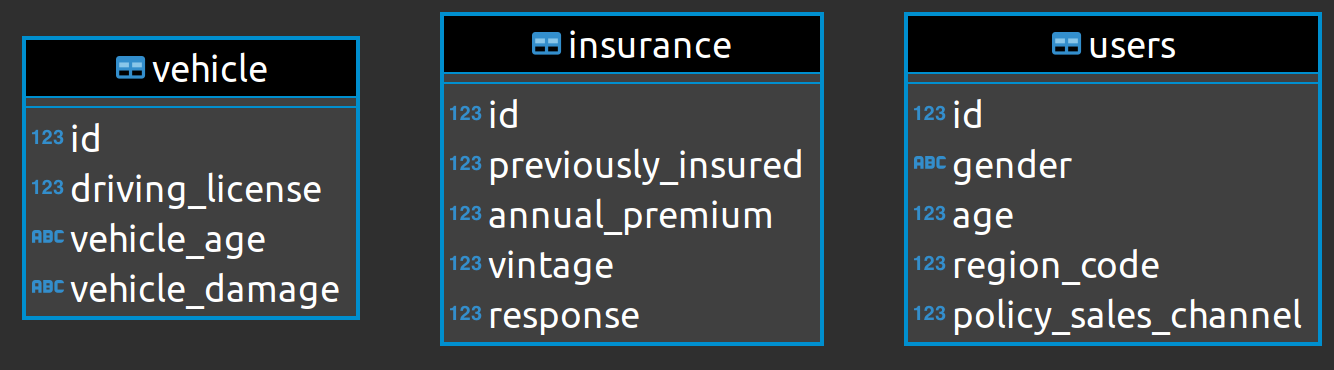

In [12]:
## Entity-relationship diagram from DBMS (DBeaver)
Image("../images/database_entity_relationship_diagram.png")

In [13]:
# check dataframe shapes
print( 'df_insurance shape:', df_insurance_extracted.shape )
print( 'df_vehicle shape:', df_vehicle_extracted.shape )
print( 'df_users shape:', df_vehicle_extracted.shape )

df_insurance shape: (381109, 5)
df_vehicle shape: (381109, 4)
df_users shape: (381109, 4)


In [14]:
# check if id column is the same on every dataframe
print( 'Insurance id vs vehicle id:\n', df_insurance_extracted['id'].equals( 
                                            df_vehicle_extracted['id']        ) )
print( 'Insurance id vs users id:\n' , df_insurance_extracted['id'].equals( 
                                            df_users_extracted['id']    ) )
print( 'Users id vs vehicle id:\n' , df_users_extracted['id'].equals( 
                                            df_vehicle_extracted['id']  ) )

Insurance id vs vehicle id:
 True
Insurance id vs users id:
 True
Users id vs vehicle id:
 True


In [15]:
# merge all dataframes on id columns
df_temp = pd.merge( df_users_extracted, df_insurance_extracted, 
                    on = 'id', 
                    how = 'inner' )
df_customers_extracted = pd.merge( df_temp, df_vehicle_extracted, 
                         on = 'id', 
                         how = 'inner' )

# check final dataframe
print(f'Final extraction dataframe has {df_customers_extracted.shape[0]} rows and {df_customers_extracted.shape[1]} columns')

df_customers_extracted.head()

Final extraction dataframe has 381109 rows and 12 columns


,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,1,Male,44,28.000,26.000,0,40454.000,217,1,1,> 2 Years,Yes
1,2,Male,76,3.000,26.000,0,33536.000,183,0,1,1-2 Year,No
2,3,Male,47,28.000,26.000,0,38294.000,27,1,1,> 2 Years,Yes
3,4,Male,21,11.000,152.000,1,28619.000,203,0,1,< 1 Year,No
4,5,Female,29,41.000,152.000,1,27496.000,39,0,1,< 1 Year,No


### Production Data

In [16]:
# load production data from csv file
df_production = pd.read_csv( '../data/test.csv' )

In [17]:
# check production data
print( f'Shape is {df_production.shape}')
df_production.head()

Shape is (127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.000,1,< 1 Year,No,35786.000,152.000,53
1,381111,Male,40,1,28.000,0,1-2 Year,Yes,33762.000,7.000,111
2,381112,Male,47,1,28.000,0,1-2 Year,Yes,40050.000,124.000,199
3,381113,Male,24,1,27.000,1,< 1 Year,Yes,37356.000,152.000,187
4,381114,Male,27,1,28.000,1,< 1 Year,No,59097.000,152.000,297


# DATA DESCRIPTION

## Restore point

In [18]:
# create a restore point for the previous section dataframe
df_customers_description = df_customers_extracted.copy()
df_customers_description.sample( 5 )

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
277634,277635,Female,23,6.000,152.000,1,30275.000,251,0,1,< 1 Year,No
263402,263403,Male,37,45.000,26.000,0,2630.000,193,0,1,1-2 Year,Yes
41620,41621,Male,25,10.000,160.000,1,24521.000,181,0,1,< 1 Year,No
220151,220152,Female,37,28.000,154.000,0,38539.000,118,1,1,1-2 Year,Yes
112044,112045,Male,22,8.000,160.000,0,26655.000,125,0,1,< 1 Year,Yes


## Column Names

In [19]:
# check column names
[ print( column ) for column in df_customers_description.columns ];

id
gender
age
region_code
policy_sales_channel
previously_insured
annual_premium
vintage
response
driving_license
vehicle_age
vehicle_damage


## Data Dimensions

In [20]:
# check number of rows and columns
print( f'Dataframe has {df_customers_description.shape[0]} rows and {df_customers_description.shape[1]} columns' )

Dataframe has 381109 rows and 12 columns


## Data Types

In [21]:
# check if data types on dataframe makes sense according to database information
df_customers_description.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## Check NAs

In [22]:
# check number of NA values on each column
df_customers_description.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## Descriptive Statistics

In [23]:
# split columns into numerical and categorical ones
num_dataframe = df_customers_description[ ['age', 
                                           'annual_premium',
                                           'vintage',                 ] ]


cat_dataframe = df_customers_description[ ['gender', 
                                           'region_code', 
                                           'policy_sales_channel',
                                           'previously_insured',
                                           'response',
                                           'driving_license',
                                           'vehicle_damage', 
                                           'vehicle_age'              ] ]

In [24]:
# check numerical dataframe
num_dataframe.head()

,age,annual_premium,vintage
0,44,40454.000,217
1,76,33536.000,183
2,47,38294.000,27
3,21,28619.000,203
4,29,27496.000,39


In [25]:
# check categorical dataframe
cat_dataframe.head()

,gender,region_code,policy_sales_channel,previously_insured,response,driving_license,vehicle_damage,vehicle_age
0,Male,28.000,26.000,0,1,1,Yes,> 2 Years
1,Male,3.000,26.000,0,0,1,No,1-2 Year
2,Male,28.000,26.000,0,1,1,Yes,> 2 Years
3,Male,11.000,152.000,1,0,1,No,< 1 Year
4,Female,41.000,152.000,1,0,1,No,< 1 Year


### Numerical attributes

In [26]:
# check numerical dataframe
print( f'Numerical dataframe has a {num_dataframe.shape} shape' )
num_dataframe.head()

Numerical dataframe has a (381109, 3) shape


,age,annual_premium,vintage
0,44,40454.000,217
1,76,33536.000,183
2,47,38294.000,27
3,21,28619.000,203
4,29,27496.000,39


In [27]:
# calculate statistics for numerical data
numerical_statistics( num_dataframe )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,age,38.823,36.000,15.512,20.000,85.000,65.000,0.673,-0.566
1,annual_premium,30564.390,31669.000,17213.132,2630.000,540165.000,537535.000,1.766,34.005
2,vintage,154.347,154.000,83.671,10.000,299.000,289.000,0.003,-1.201


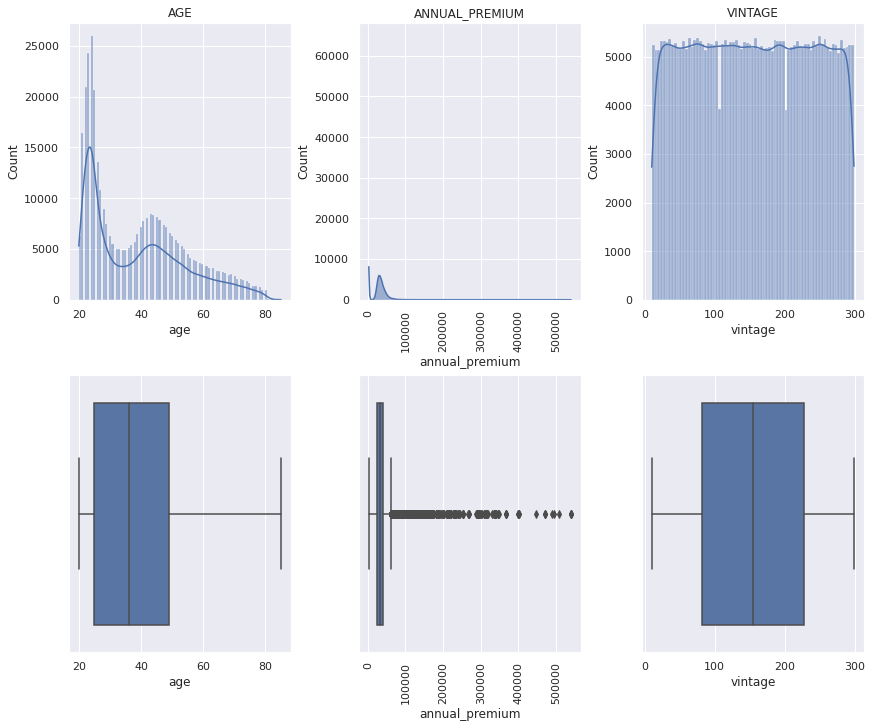

In [28]:
# create a figure object
fig = plt.figure( figsize = (12, 10) , constrained_layout = True )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 3, nrows = 2, figure = fig)

# check age distribution
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
numerical_plot( num_dataframe, 'age', ax1, ax2 )

# check annual premium distribution
ax3 = fig.add_subplot( specs[0, 1] )
ax4 = fig.add_subplot( specs[1, 1] )
numerical_plot( num_dataframe, 'annual_premium', ax3, ax4,
                hist_label_rot = 90, box_label_rot = 90)

# check vintage distribution
ax5 = fig.add_subplot( specs[0, 2] )
ax6 = fig.add_subplot( specs[1, 2] )
numerical_plot( num_dataframe, 'vintage', ax5, ax6 )

### Categorial attributes

In [29]:
# check categorical dataframe
print( f'Categorical dataframe has {cat_dataframe.shape} shape' )
cat_dataframe.head()

Categorical dataframe has (381109, 8) shape


,gender,region_code,policy_sales_channel,previously_insured,response,driving_license,vehicle_damage,vehicle_age
0,Male,28.000,26.000,0,1,1,Yes,> 2 Years
1,Male,3.000,26.000,0,0,1,No,1-2 Year
2,Male,28.000,26.000,0,1,1,Yes,> 2 Years
3,Male,11.000,152.000,1,0,1,No,< 1 Year
4,Female,41.000,152.000,1,0,1,No,< 1 Year


In [30]:
# number of unique values for every column
cat_dataframe.apply( lambda x: x.unique() )

gender                                                     [Male, Female]
region_code             [28.0, 3.0, 11.0, 41.0, 33.0, 6.0, 35.0, 50.0,...
policy_sales_channel    [26.0, 152.0, 160.0, 124.0, 14.0, 13.0, 30.0, ...
previously_insured                                                 [0, 1]
response                                                           [1, 0]
driving_license                                                    [1, 0]
vehicle_damage                                                  [Yes, No]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
dtype: object

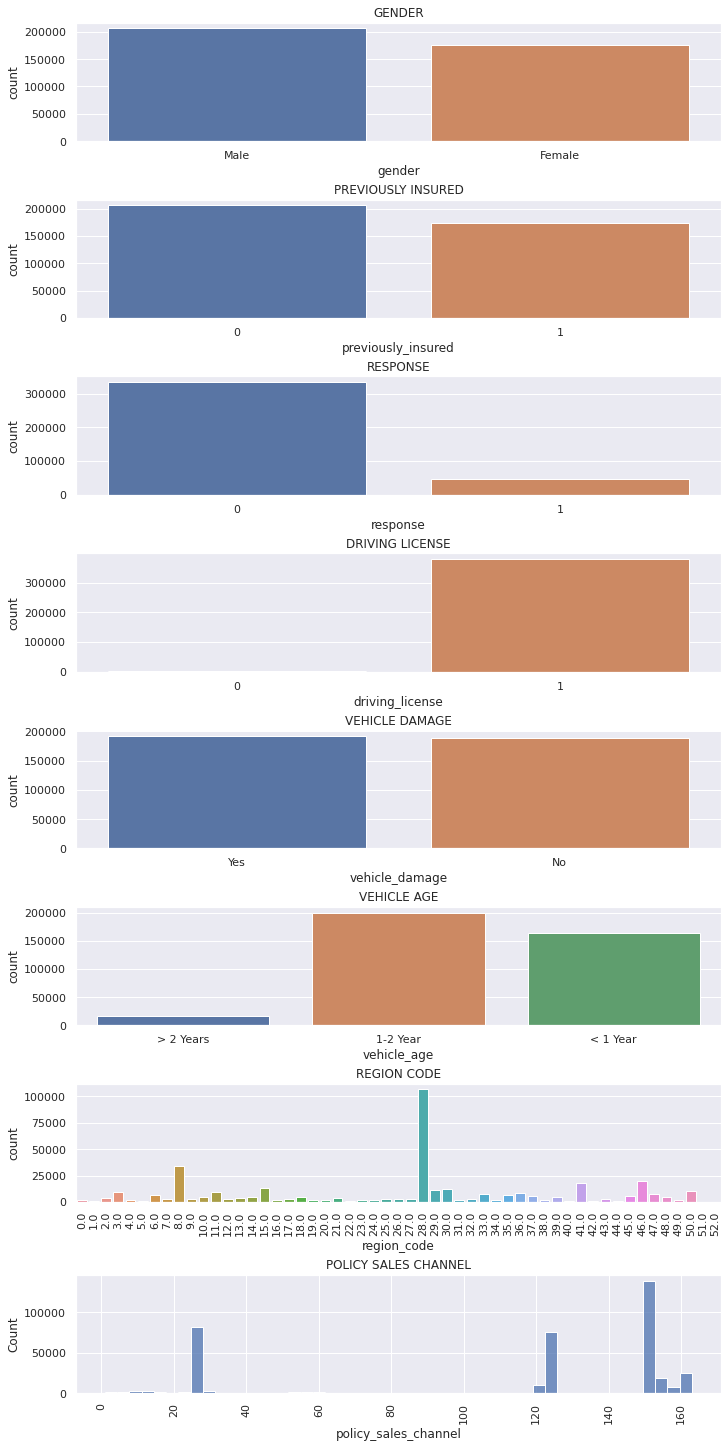

In [31]:
# create a figure object
fig = plt.figure( figsize = (10, 20), constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 8, figure = fig)

# check gender distribution
ax1 = fig.add_subplot( specs[0, 0] )
cat_count_plotting( cat_dataframe, 'gender', ax1 )
    
# check previously_insured distribution
ax2 = fig.add_subplot( specs[1, 0] )
cat_count_plotting( cat_dataframe, 'previously_insured', ax2 )

# check response distribution
ax3 = fig.add_subplot( specs[2, 0] )
cat_count_plotting( cat_dataframe, 'response', ax3 )

# check driving license distribution
ax4 = fig.add_subplot( specs[3, 0] )
cat_count_plotting( cat_dataframe, 'driving_license', ax4 )

# check vehicle damage distribution
ax5 = fig.add_subplot( specs[4, 0] )
cat_count_plotting( cat_dataframe, 'vehicle_damage', ax5 )

# check vehicle age distribution
ax6 = fig.add_subplot( specs[5, 0] )
cat_count_plotting( cat_dataframe, 'vehicle_age', ax6 )

# check region code distribution
ax7 = fig.add_subplot( specs[6, 0] )
cat_count_plotting( cat_dataframe, 'region_code', ax7, x_label_rotation = True )

# check policy sales channel distribution
ax8 = fig.add_subplot( specs[7, 0] )
sns.histplot(x = 'policy_sales_channel', data = cat_dataframe, ax = ax8)
ax8.set_title( 'POLICY SALES CHANNEL' )
plt.xticks(rotation=90);

# FEATURE ENGINEERING

## Restore point

In [32]:
# create a restore point for the previous section dataframe
df_customers_f_eng = df_customers_description.copy()

# check dataframe
check_dataframe( df_customers_f_eng )  

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object 

Dataframe shape is (381109, 12) 



,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
198287,198288,Male,64,28.000,124.000,0,104535.000,214,0,1,> 2 Years,Yes
198459,198460,Male,33,46.000,124.000,0,33111.000,221,1,1,< 1 Year,No
183826,183827,Female,26,16.000,160.000,0,28518.000,241,0,1,< 1 Year,Yes
353698,353699,Female,41,46.000,124.000,0,23458.000,29,0,1,1-2 Year,Yes
226386,226387,Female,36,4.000,124.000,0,25807.000,141,1,1,1-2 Year,Yes


## Hypothesis Mind Map

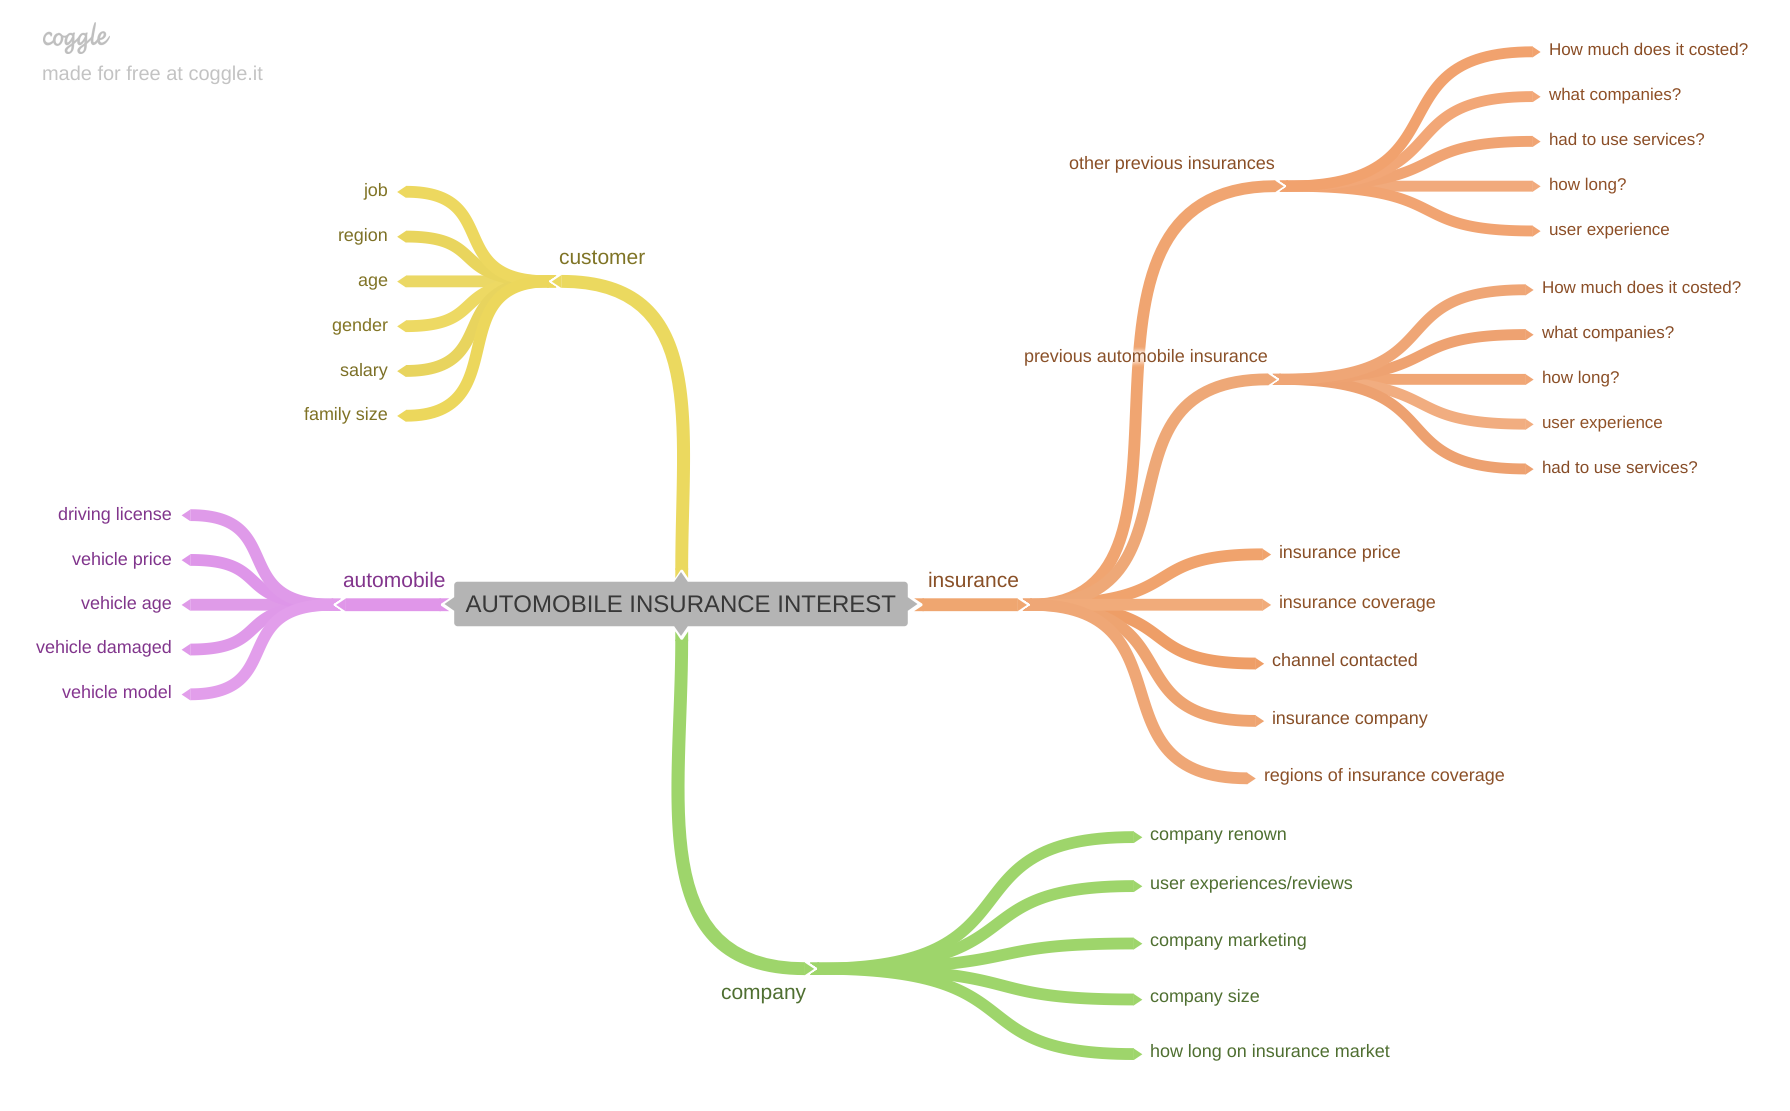

In [33]:
## Hypothesis mind map of automobile insuranc interest phenomenon
Image("../images/hypothesis_mind_map.png")

## Hypothesis Creation

### automobile hypothesis

***1.*** Customers with driving licenses are more interested in automobile insurance

***2.*** The higher the vehicle price, the more interested the customer is in automobile insurance

***3.*** The older the car, the less interested the customer is in automobile insurance

***4.*** Customers that already had their vehicle damaged in the past are more interested in automobile insurance

***5.*** Customer's interest in automobile insurance depends on the vehicle model

### customer hypothesis

***1.*** Customer's interest in automobile insurance depends on the customer's job

***2.*** Customer's interest in automobile insurance depends on the region of the customer

***3.*** The older the customer, the more interested he/she is in automobile insurance 

***4.*** Women are more interested in automobile insurance than men

***5.*** The higher the salary of the customer, the more interested he/she is in automobile insurance

***6.*** The larger the family size, the more interested the customer is in automobile insurance

### company hypothesis

***1.*** The more renown the company has, the more interested customer will be

***2.*** The better the user experiences/reviews, the more interested customers will be

***3.*** The more money a company invest in marketing, the more interested customers will be

***4.*** The larger the company, the more interested customers will be

***5.*** The older the company, the more interested customers will be

### insurance hypothesis

***1.*** The more expensive the insurance price, the less interested the customers will be

***2.*** The larger the insurance coverage, the more interested the customers will be

***3.*** Customers interest depends on the channel at which he/she was contacted by the company

***4.*** Different sales channels have a large variation in terms of the number of interested customers

***5.*** The more geographic regions the insurance can cover, the more interested the customer will be

***6.*** If the customer already had contracted automobile insurance in the past, he/she is more likely to be interested in another automobile insurance

**7.** If the customer already had contracted automobile insurance in the past, his(her) would be more interested in another automobile insurance if he/she paid a lower premium price on the past contract

***8.*** If the customer already had contracted automobile insurance in the past, his(her) interest in another automobile insurance depends on what company he/she had contracted in the past

***9.*** If the customer already had contracted automobile insurance in the past, his(her) interest in another automobile insurance depends on how long the past contract was

***10.*** If the customer already had contracted automobile insurance in the past, his(her) interest in another automobile insurance depends on what was his/her experience with the service in the past

***11.*** If the customer already had contracted automobile insurance in the past, his(her) interest in another automobile insurance depends on if he/she had to use the insurance service in the past

***12.*** If the customer already had contracted automobile insurance in the past, his(her) interest in another automobile insurance depends on if he/she had to use the insurance service in the past

***13.*** If the customer already had contracted other types of insurance in the past, he/she is more likely to be interested in automobile insurance

***14.*** If the customer already had contracted other types of insurance in the past, his(her) would be more interested in automobile insurance if he/she paid a lower premium price on the past contract

***15.*** If the customer already had contracted other types of insurance in the past, his/her interest in automobile insurance depends on what company he/she had contracted (the other types of insurance) in the past

***16.*** If the customer already had contracted other types of insurance in the past, his/her interest in automobile insurance depends on how long the past contract was

***17.*** If the customer already had contracted other types of insurance in the past, his/her interest in automobile insurance depends on what was his/her experience with the service in the past

***18.*** If the customer already had contracted other types of insurance in the past, his/her interest in automobile insurance depends on if he/she had to use the insurance service in the past

## Final Hypothesis List

> The chosen criterion for selecting the final hypothesis list: 
     *availability of data to test a hypothesis.*

** FINAL HYPOTHESIS LIST **

##### **H1.** Considering people interested in automobile insurance, most of them have a driving license.
##### **H2.** Considering people interested in automobile insurance, most of them have newer cars.
##### **H3.** Considering people interested in automobile insurance, most of them had their vehicle damaged in the past.
##### **H4.** Considering people interested in automobile insurance, the number of customers interested in automobile insurance has a large variation according to customers' region.
##### **H5.** Considering people interested in automobile insurance, most of them are older rather than younger.
##### **H6.** Considering people interested in automobile insurance, most of them are women.
##### **H7.** Different sales channels have a large variation in terms of the number of interested customers.
##### **H8.** Considering people interested in automobile insurance, most of them had contracted automobile insurance in the past.
##### **H9.** Considering people interested in automobile insurance, most of them contracted cheaper health insurance in the past.
##### **H10.** Considering people interested in automobile insurance, most of them had contracted health insurance for a longer time interval.

## Feature Engineering

In [34]:
# check dataframe
check_dataframe( df_customers_f_eng )  

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object 

Dataframe shape is (381109, 12) 



,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
351694,351695,Male,24,41.000,152.000,1,33229.000,207,0,1,< 1 Year,No
298446,298447,Female,21,8.000,152.000,0,42317.000,158,0,1,< 1 Year,Yes
114778,114779,Male,50,28.000,26.000,0,2630.000,59,0,1,1-2 Year,Yes
203915,203916,Female,26,41.000,152.000,1,65273.000,109,0,1,< 1 Year,No
275540,275541,Male,22,40.000,152.000,1,2630.000,246,0,1,< 1 Year,No


In [35]:
# check if all region_code values are intergers
print( np.array_equal( df_customers_f_eng[ 'region_code' ],
               df_customers_f_eng[ 'region_code' ].astype( int ) ) )

# convert region_code column to integer
df_customers_f_eng[ 'region_code' ] = df_customers_f_eng[ 'region_code' ].astype( int );

True


In [36]:
# check if all policy_sales_channel values are intergers
print( np.array_equal( df_customers_f_eng[ 'policy_sales_channel' ],
               df_customers_f_eng[ 'policy_sales_channel' ].astype( int ) ) )

# convert region_code column to integer
df_customers_f_eng[ 'policy_sales_channel' ] = df_customers_f_eng[ 'policy_sales_channel' ].astype( int );

True


In [37]:
# check if all annual_premium values are intergers
np.array_equal( df_customers_f_eng[ 'annual_premium' ],
               df_customers_f_eng[ 'annual_premium' ].astype( int ) )

# convert region_code column to integer
df_customers_f_eng[ 'annual_premium' ] = df_customers_f_eng[ 'annual_premium' ].astype( int );

In [38]:
# convert damage column from Yes-No to True-False format
df_customers_f_eng['vehicle_damage'] = df_customers_f_eng[ 'vehicle_damage' ].apply( 
                                                            lambda x: True if x == 'Yes'else False )

In [39]:
# check final dataframe
check_dataframe( df_customers_f_eng )  

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
driving_license          int64
vehicle_age             object
vehicle_damage            bool
dtype: object 

Dataframe shape is (381109, 12) 



,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
92234,92235,Male,24,24,152,1,29842,238,0,1,< 1 Year,False
65071,65072,Male,22,13,152,0,34327,168,0,1,< 1 Year,True
289620,289621,Female,39,46,163,0,2630,292,0,1,> 2 Years,True
130859,130860,Male,47,50,30,0,33558,105,1,1,1-2 Year,True
212014,212015,Male,45,8,19,1,34391,144,0,1,1-2 Year,False


# DATA FILTERING

## Restore point

In [40]:
# create a restore point for the previous section dataframe
df_customers_v_filter = df_customers_f_eng.copy()

# check dataframe
check_dataframe( df_customers_v_filter )  

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
driving_license          int64
vehicle_age             object
vehicle_damage            bool
dtype: object 

Dataframe shape is (381109, 12) 



,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
157753,157754,Female,50,21,124,0,39164,104,0,1,1-2 Year,True
152782,152783,Male,24,8,152,0,39416,167,0,1,< 1 Year,True
92457,92458,Male,51,47,16,1,35281,198,0,1,1-2 Year,False
143965,143966,Male,25,37,152,0,27499,206,1,1,< 1 Year,True
165832,165833,Male,22,47,152,0,31725,121,0,1,< 1 Year,True


**Remember from database information**

## Rows Filtering

## Columns Selection

# EXPLORATORY DATA ANALYSIS

## Restore Point

In [41]:
# create a restore point for the previous section dataframe
df_customers_eda = df_customers_v_filter.copy()

# check dataframe
check_dataframe( df_customers_eda )  

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
driving_license          int64
vehicle_age             object
vehicle_damage            bool
dtype: object 

Dataframe shape is (381109, 12) 



,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
257627,257628,Female,26,15,152,1,30855,262,0,1,< 1 Year,False
153658,153659,Male,22,50,152,1,28981,115,0,1,< 1 Year,True
303595,303596,Male,40,28,55,1,63420,21,0,1,1-2 Year,False
290643,290644,Female,24,50,152,1,37498,139,0,1,< 1 Year,False
76555,76556,Male,29,28,157,0,2630,288,0,1,1-2 Year,True


## Univariate analyses

### Response variable

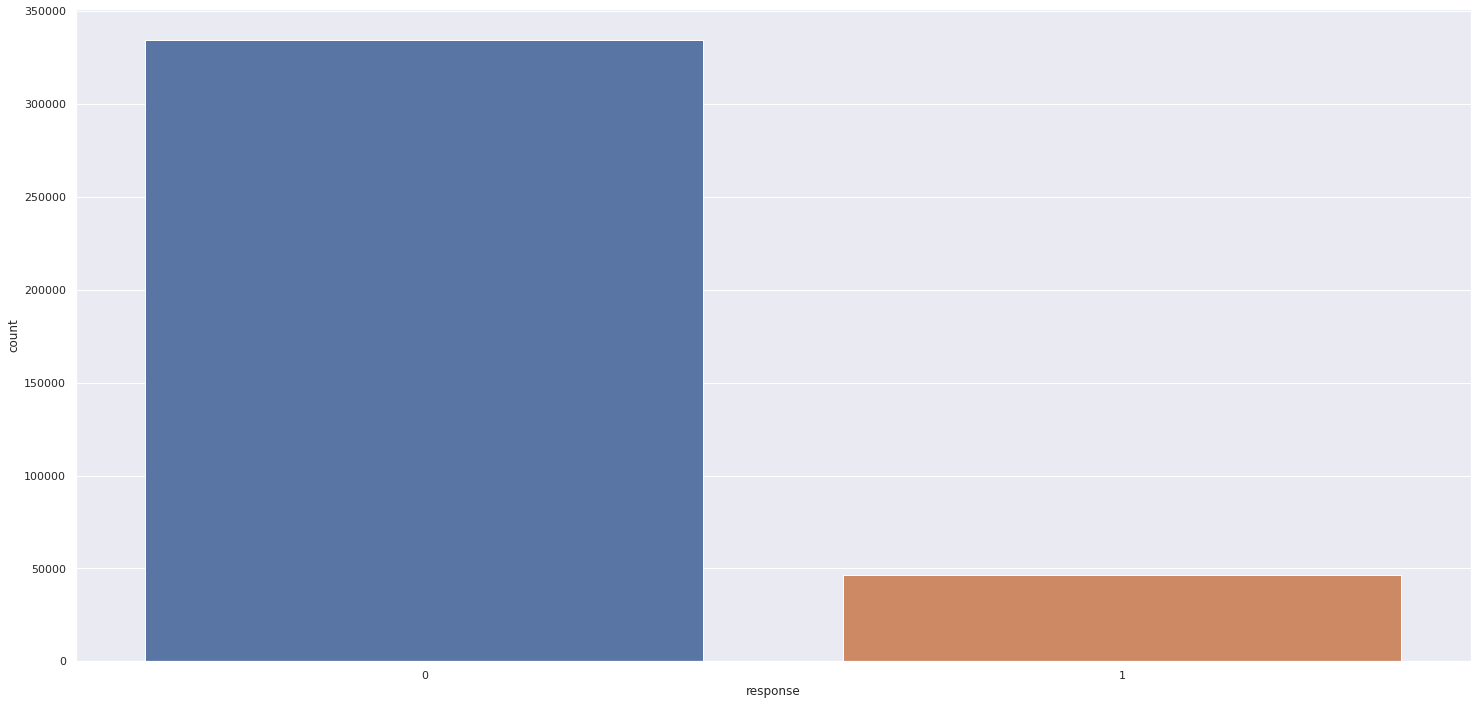

In [42]:
# plot response variable
sns.countplot( x = 'response', data = df_customers_eda );

### Numerical variables

In [43]:
# select numerical features
num_features = df_customers_eda[ ['age', 
                                  'annual_premium',
                                  'vintage'
                                 ] ]

num_features.sample( 5 )

,age,annual_premium,vintage
33112,58,51373,259
300453,29,34539,141
128594,51,43986,212
364444,24,2630,184
17217,22,36865,84


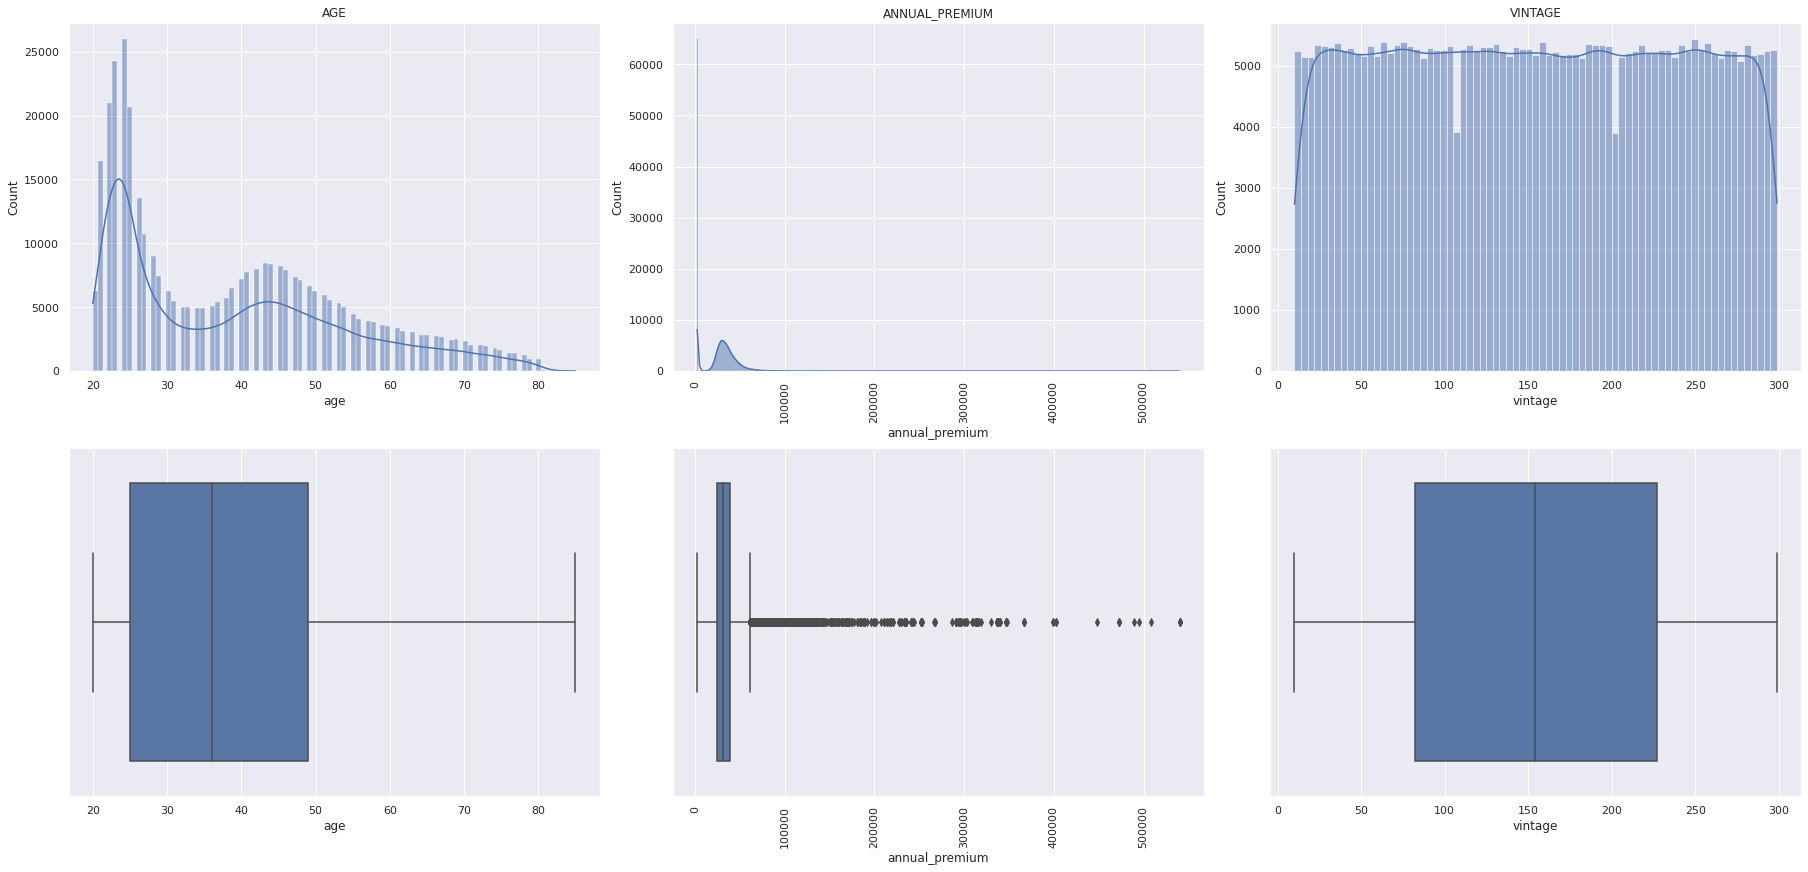

In [44]:
# create a figure object
fig = plt.figure( constrained_layout = True)

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 3, nrows = 2, figure = fig)

# check age distribution
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
numerical_plot( num_features, 'age', hist_axs = ax1 , box_axs = ax2 )

# check annual premium distribution
ax3 = fig.add_subplot( specs[0, 1] )
ax4 = fig.add_subplot( specs[1, 1] )
numerical_plot( num_features, 'annual_premium', hist_axs = ax3 , box_axs = ax4,
                hist_label_rot = 90, box_label_rot = 90 )

# check vintage distribution
ax5 = fig.add_subplot( specs[0, 2] )
ax6 = fig.add_subplot( specs[1, 2] )
numerical_plot( num_features, 'vintage', hist_axs = ax5 , box_axs = ax6 )

In [45]:
# calculate summary statistics
numerical_statistics( num_features )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,age,38.823,36.000,15.512,20.000,85.000,65.000,0.673,-0.566
1,annual_premium,30564.390,31669.000,17213.132,2630.000,540165.000,537535.000,1.766,34.005
2,vintage,154.347,154.000,83.671,10.000,299.000,289.000,0.003,-1.201


### Categorical variables

In [46]:
# select categorical features
cat_features = df_customers_eda[ ['gender', 
                                  'region_code', 
                                  'policy_sales_channel',
                                  'previously_insured',
                                  'driving_license',
                                  'vehicle_age',
                                  'vehicle_damage',
                                  ] ]

cat_features.head()

,gender,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_age,vehicle_damage
0,Male,28,26,0,1,> 2 Years,True
1,Male,3,26,0,1,1-2 Year,False
2,Male,28,26,0,1,> 2 Years,True
3,Male,11,152,1,1,< 1 Year,False
4,Female,41,152,1,1,< 1 Year,False


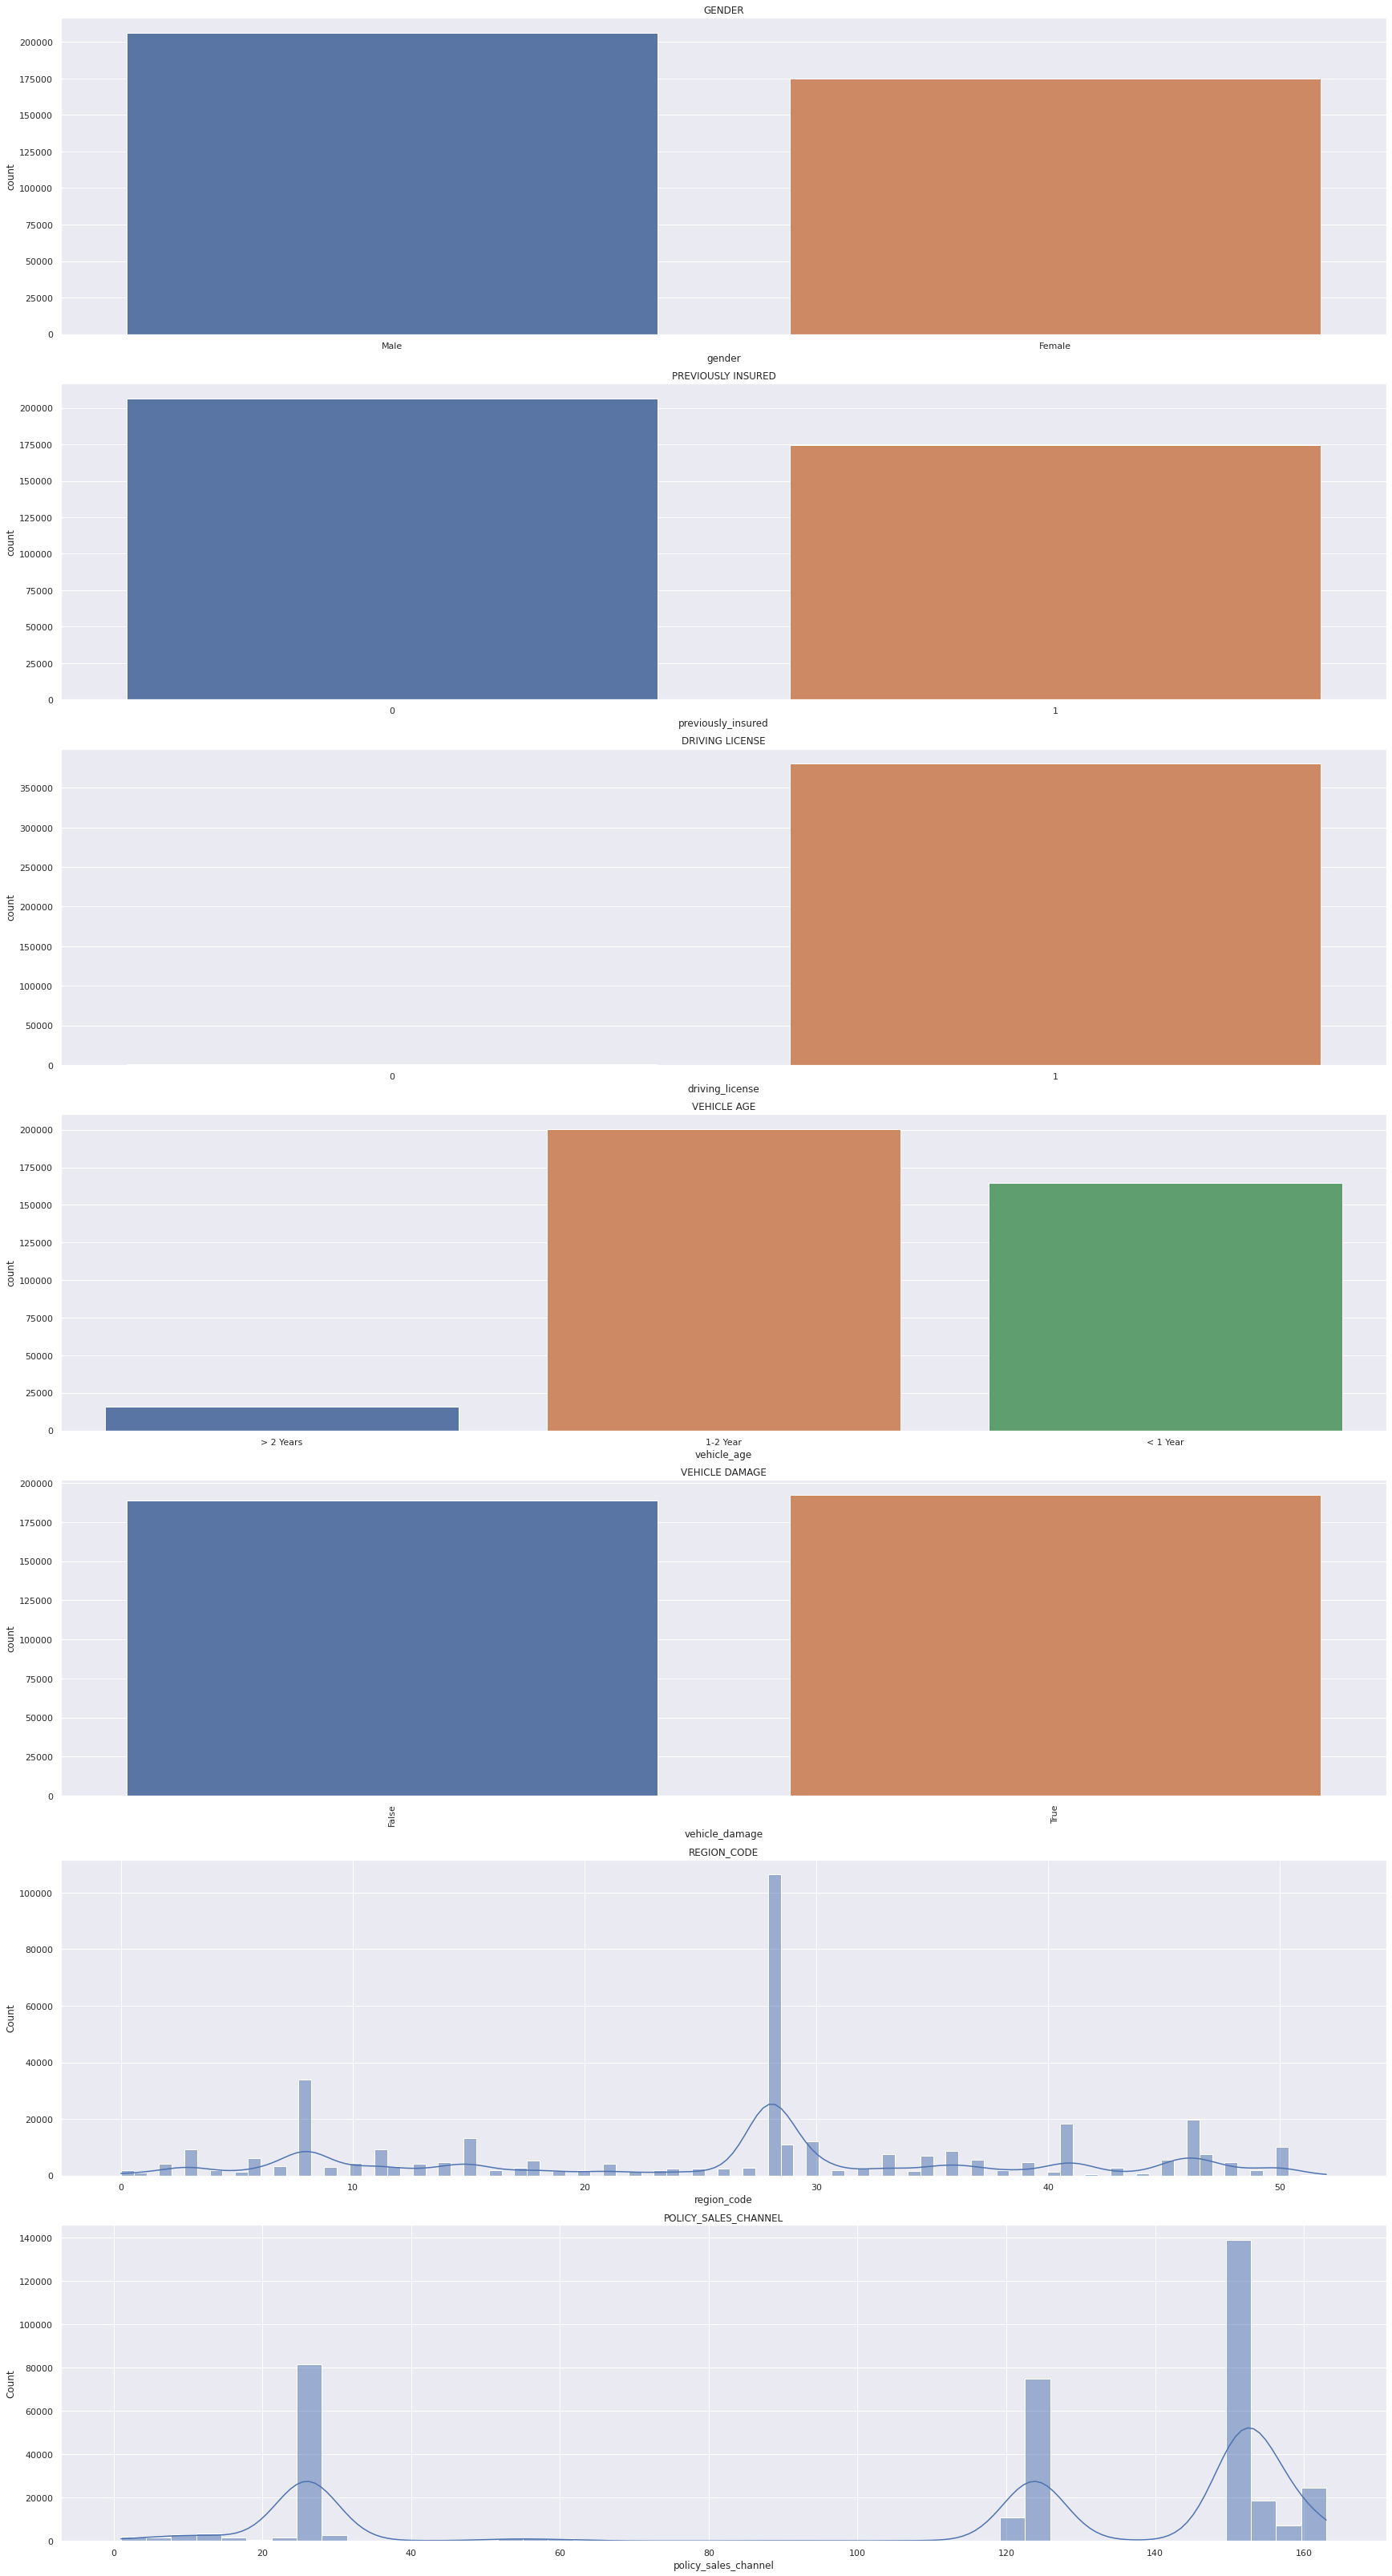

In [47]:
# create a figure object
fig = plt.figure( figsize = (24, 50),  constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 8, figure = fig)

# check gender distribution
ax1 = fig.add_subplot( specs[0, 0] )
cat_count_plotting( cat_features, 'gender', ax1 )
    
# check previously_insured distribution
ax2 = fig.add_subplot( specs[1, 0] )
cat_count_plotting( cat_features, 'previously_insured', ax2 )

# check driving_license distribution
ax3 = fig.add_subplot( specs[2, 0] )
cat_count_plotting( cat_features, 'driving_license', ax3 )

# check vehicle_age distribution
ax4 = fig.add_subplot( specs[3, 0] )
cat_count_plotting( cat_features, 'vehicle_age', ax4 )

# check vehicle_damage distribution
ax5 = fig.add_subplot( specs[4, 0] )
cat_count_plotting( cat_features, 'vehicle_damage', ax5, x_label_rotation = True )

# check region_code distribution
ax6 = fig.add_subplot( specs[5, 0] )
sns.histplot( data = cat_features, x = 'region_code', ax = ax6, kde = True )
plt.title( 'REGION_CODE' )

# check policy_sales_channel distribution
ax7 = fig.add_subplot( specs[6, 0] )
sns.histplot( data = cat_features, x = 'policy_sales_channel', ax = ax7, kde = True )
plt.title( 'POLICY_SALES_CHANNEL' );

812 customers don't have driving license, while  380297 customers have driving license


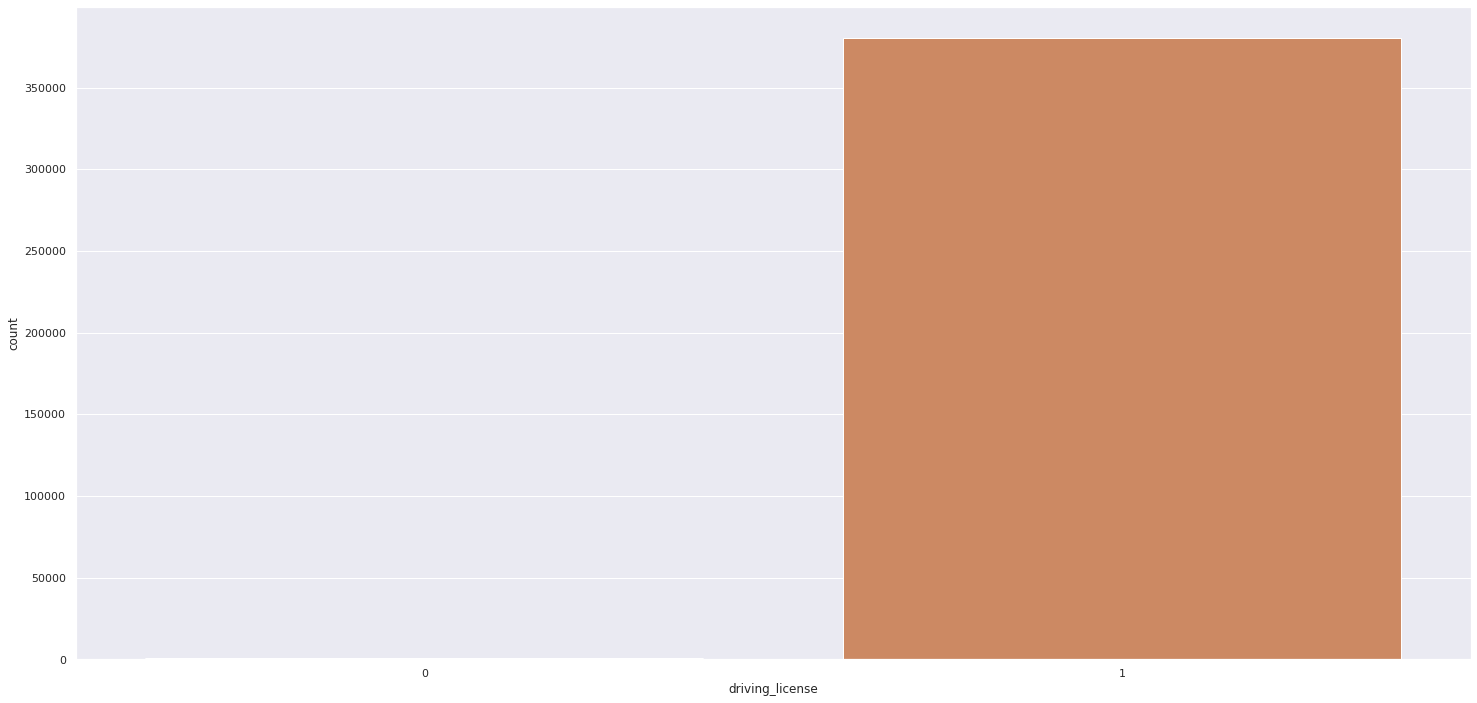

In [48]:
# check driving_license more closely
# display number of occurrences for each value
print( cat_features[ ['driving_license'] ].value_counts()[0], 
       "customers don't have driving license, while ", 
       cat_features[ ['driving_license'] ].value_counts()[1], 
       'customers have driving license' )

# plot countplot again
sns.countplot( data = cat_features, x = 'driving_license' );

## Bivariate analyses

### **H1. Considering people interested in automobile insurance, most of them have a driving license.**

> **H1 IS TRUE**. The majority of people interested in automobile insurance have a driving license.

In [49]:
# create a cross tabulation with driving_license and response
df_h1 = pd.crosstab( df_customers_eda['driving_license'], df_customers_eda['response'], 
                     normalize = 'columns',  margins = True)

df_h1

response,0,1,All
driving_license,,,
0,0.002,0.001,0.002
1,0.998,0.999,0.998


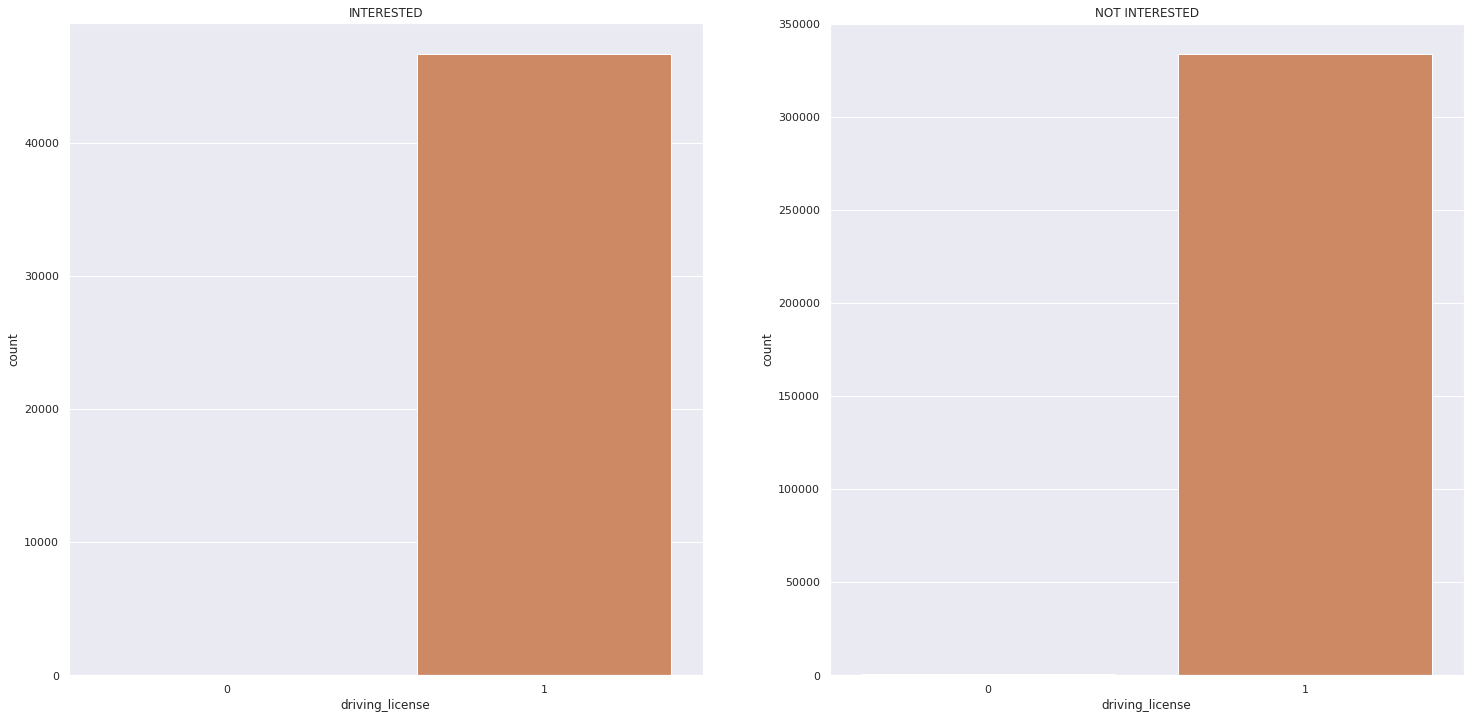

In [50]:
# create subplots for 'interested' and 'not interested'
ax1 = plt.subplot( 1 , 2, 1)
ax2 = plt.subplot( 1 , 2, 2)

# plot 'interested'
sns.countplot( x = 'driving_license', 
              data = df_customers_eda[df_customers_eda['response'] == 1], ax = ax1 )
ax1.set_title( 'INTERESTED') 

# plot 'not interested'
sns.countplot( x = 'driving_license', 
              data = df_customers_eda[df_customers_eda['response'] == 0], ax = ax2 )
ax2.set_title( 'NOT INTERESTED' );

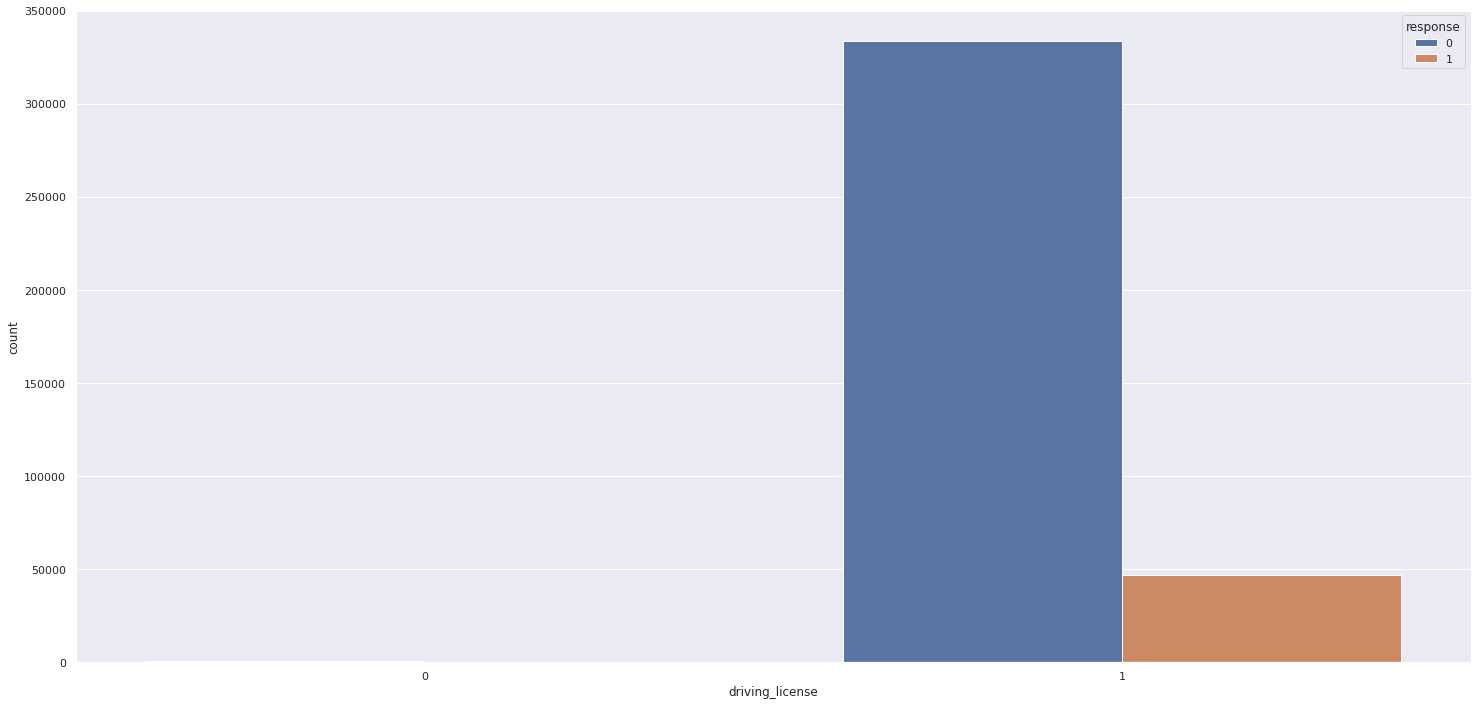

In [51]:
# get intuition about driving_license relevance
sns.countplot( x = 'driving_license', hue = 'response', data = df_customers_eda);

### **H2. Considering people interested in automobile insurance, most of them have newer cars.**

>**H2 IS TRUE**. The majority of people interested in automobile insurance have newer cars.

In [52]:
# create a cross tabulation with vehicle_age and response
df_h2 = pd.crosstab( df_customers_eda['vehicle_age'], df_customers_eda['response'],
                     normalize = 'columns')

df_h2

response,0,1
vehicle_age,,
1-2 Year,0.495,0.745
< 1 Year,0.471,0.154
> 2 Years,0.034,0.101


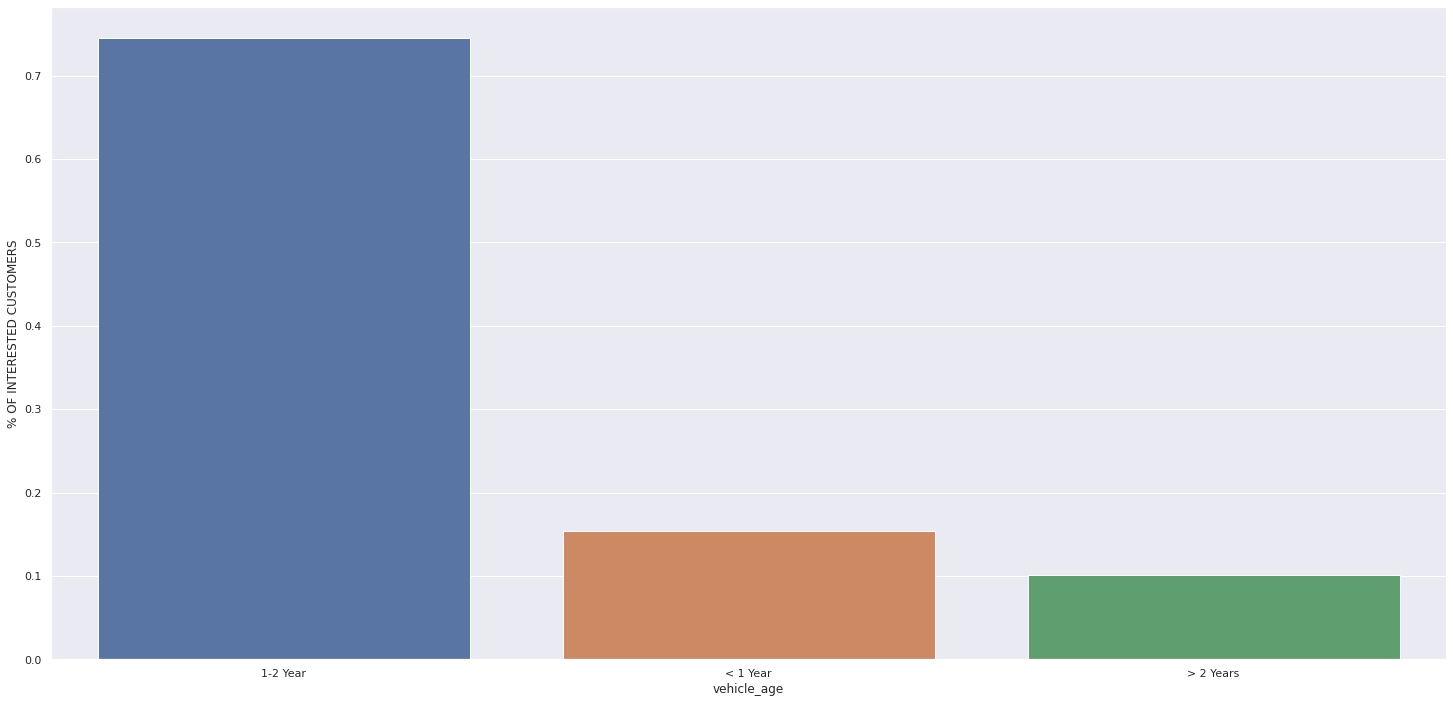

In [53]:
# plot response against vehicle_age
sns.barplot( x = 'vehicle_age', y = 1, data = df_h2.reset_index() )
plt.ylabel('% OF INTERESTED CUSTOMERS');

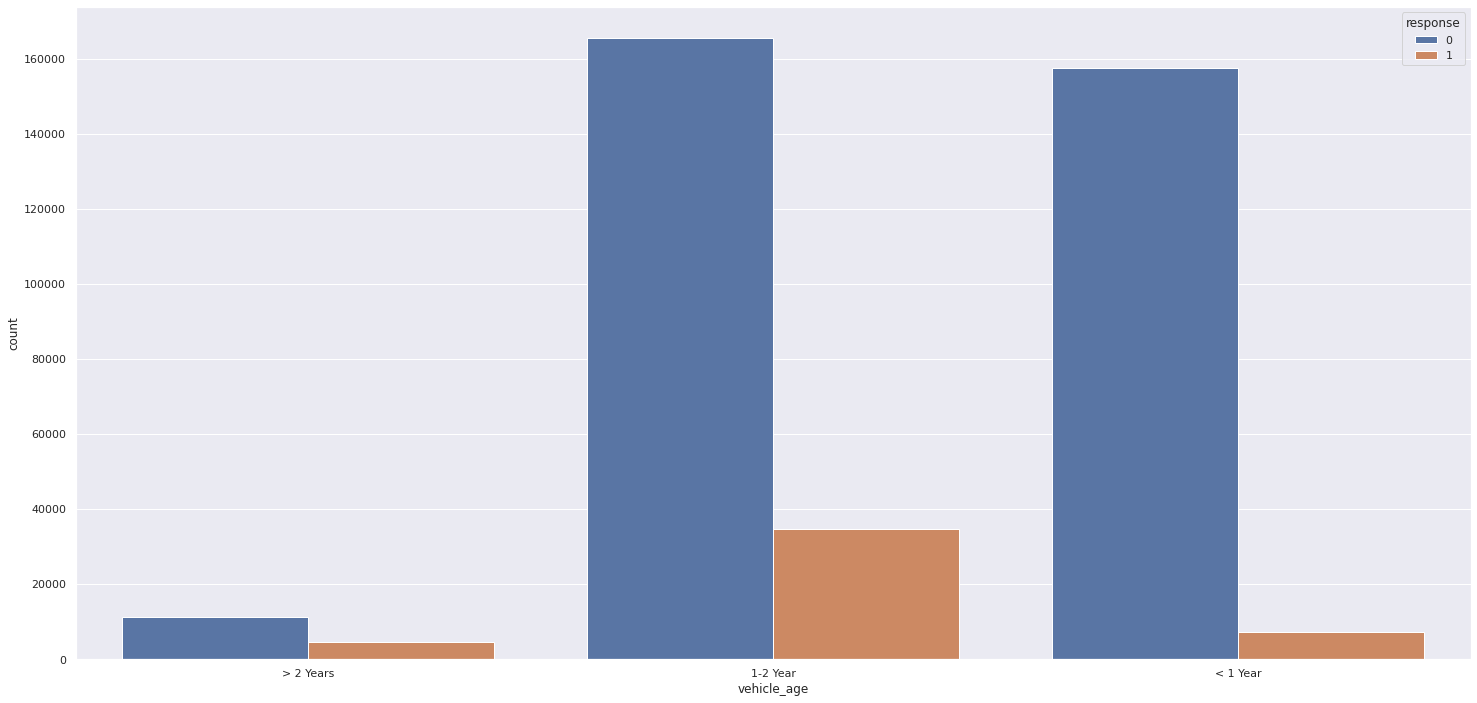

In [54]:
# get intuition about vehicle_age relevance
sns.countplot( x = 'vehicle_age', hue = 'response', data = df_customers_eda);

### **H3. Considering people interested in automobile insurance, most of them had their vehicle damaged in the past.**

>**H3 IS TRUE**. The majority of people interested in automobile insurance had their vehicle damaged in the past.

In [55]:
# create cross tabulation with vehicle_damage and response columns
df_h3 = pd.crosstab( df_customers_eda['vehicle_damage'], df_customers_eda['response'], 
                     normalize = 'columns')

df_h3

response,0,1
vehicle_damage,,
False,0.561,0.021
True,0.439,0.979


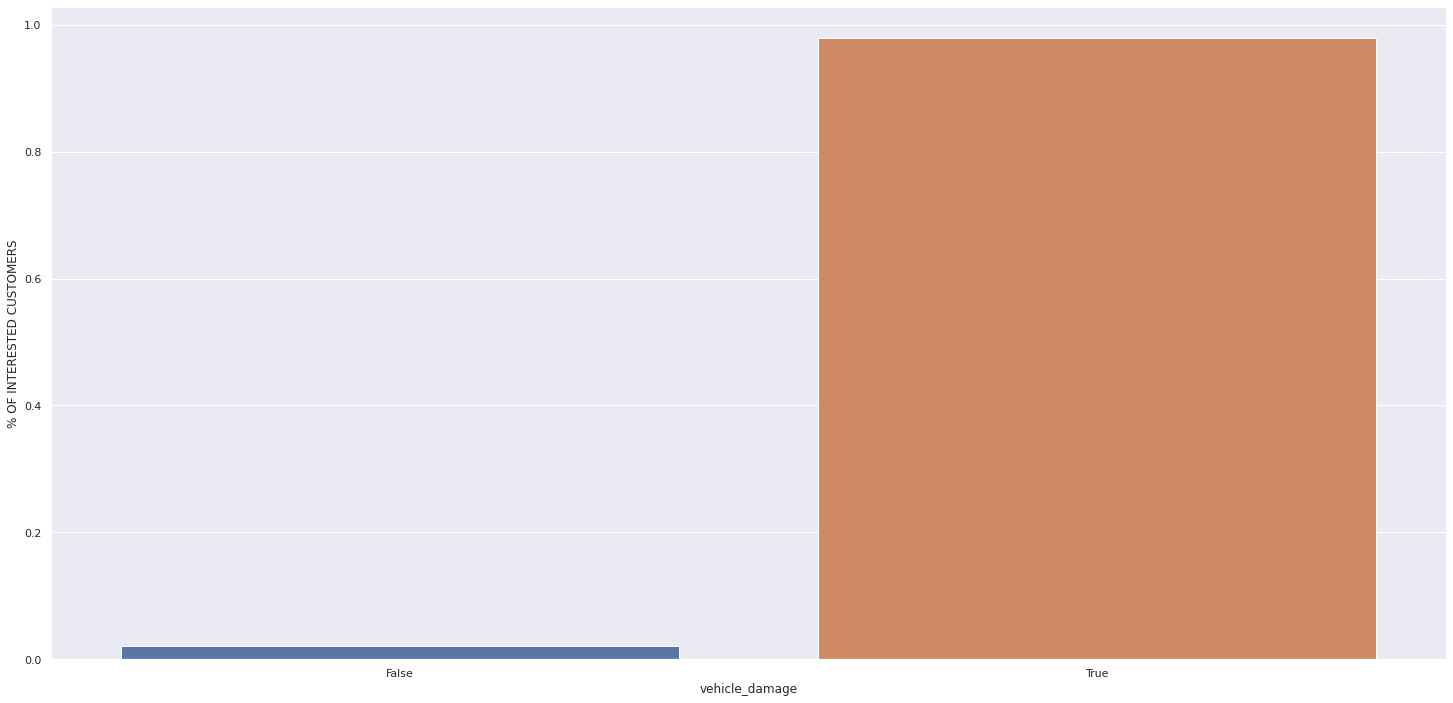

In [56]:
# percentage of interested customers per vihicle_damage category
sns.barplot(x = 'vehicle_damage', y = 1, data = df_h3.reset_index() )
plt.ylabel( '% OF INTERESTED CUSTOMERS' );

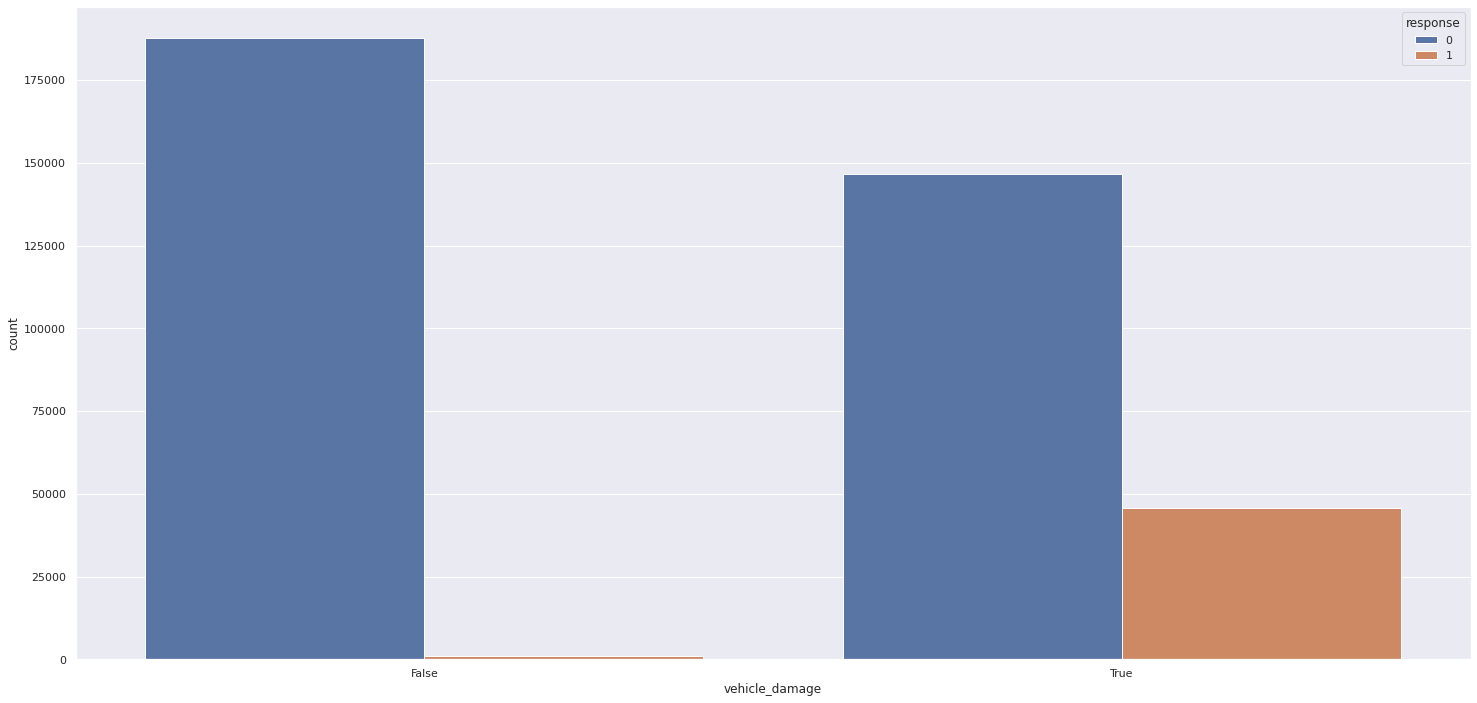

In [57]:
# get intuition about vehicle_damage relevance
sns.countplot( x = 'vehicle_damage', hue = 'response', data = df_customers_eda);

### **H4. Considering people interested in automobile insurance, the number of customers interested in automobile insurance has a large variation according to customers' region.**

>**H4 IS TRUE**. Different regions have a large variation in terms of the number of interested customers.

In [58]:
# create cross tabulation with region_code and response columns
df_h4 = pd.crosstab( df_customers_eda['region_code'], df_customers_eda['response'],
                     normalize = 'index' )

df_h4.tail()

response,0,1
region_code,,
48,0.898,0.102
49,0.925,0.075
50,0.937,0.063
51,0.847,0.153
52,0.876,0.124


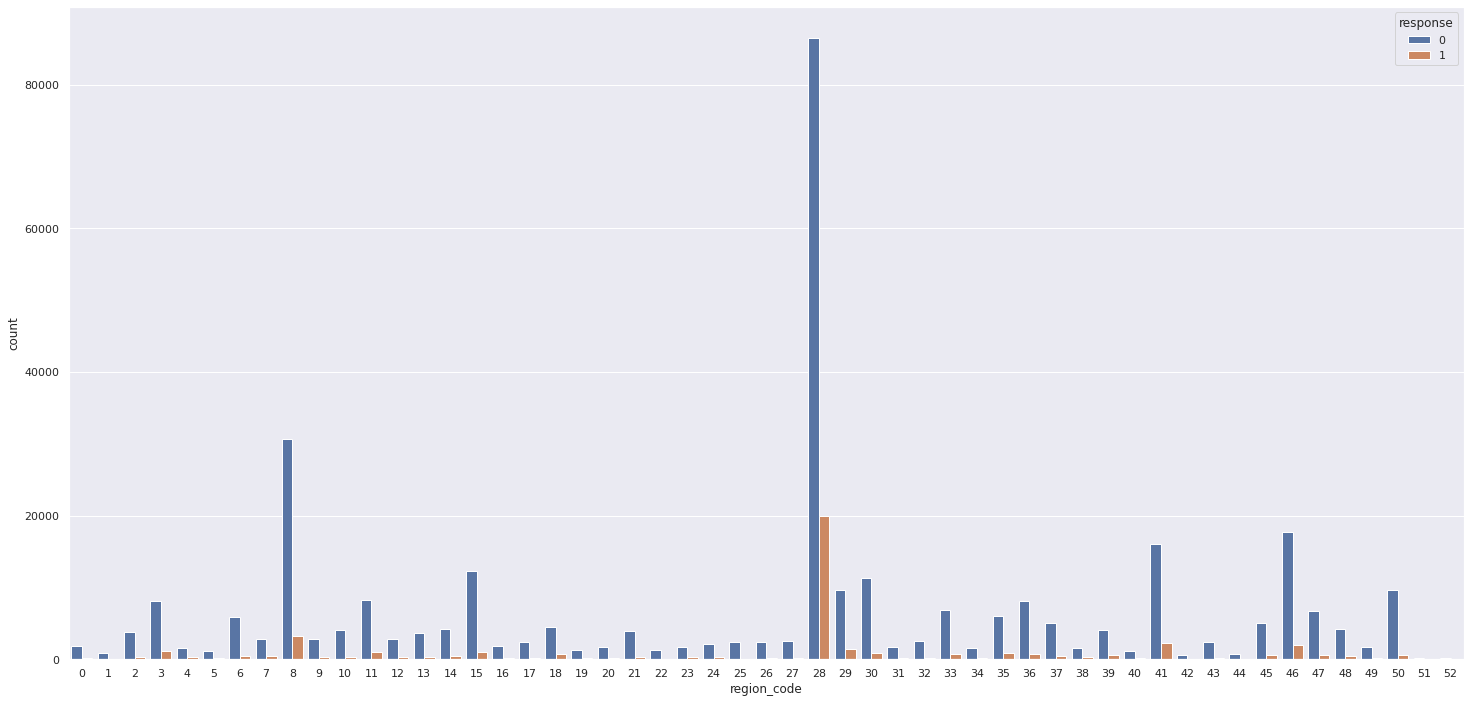

In [59]:
# plot response against region_code
sns.countplot( x = 'region_code', hue = 'response', data = df_customers_eda);

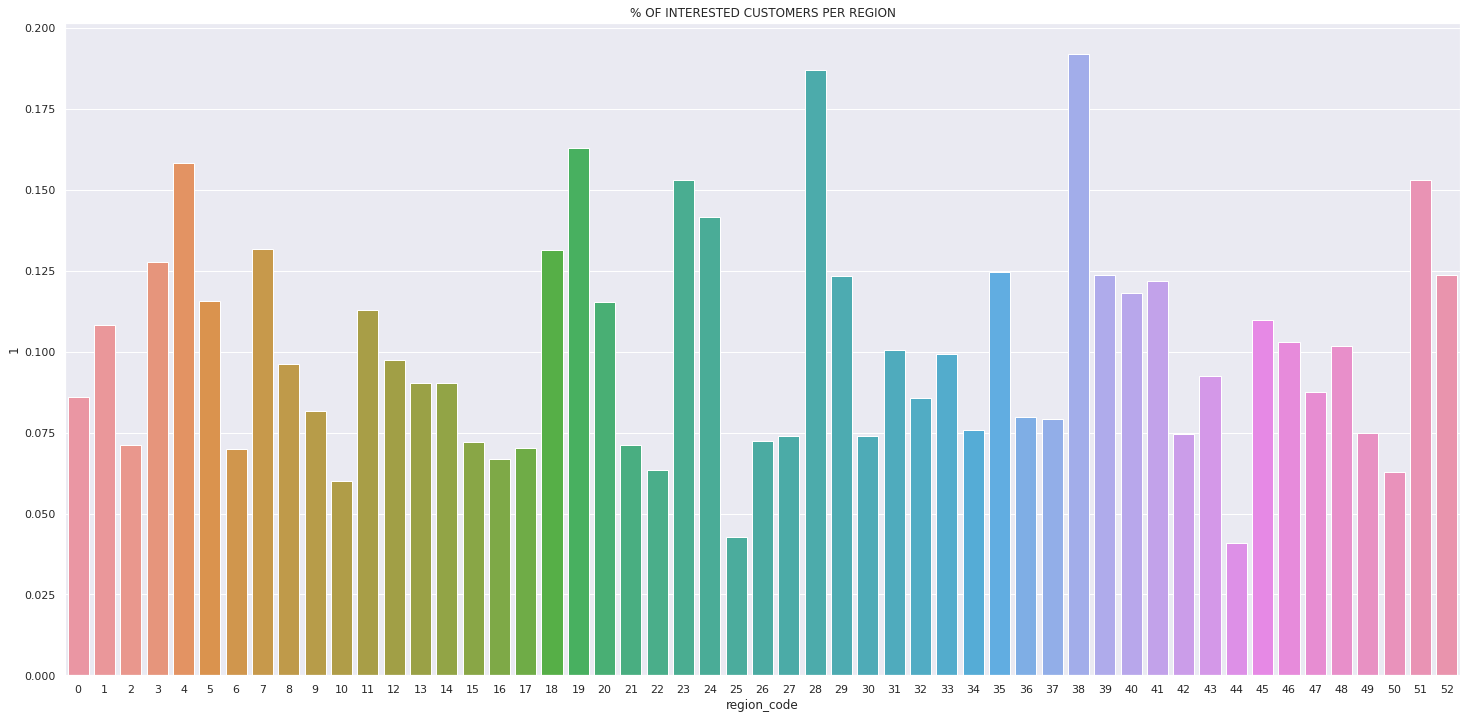

In [60]:
# plot number of interested customers per region_code
sns.barplot( x = 'region_code', y = 1, data = df_h4.reset_index() )
plt.title( '% OF INTERESTED CUSTOMERS PER REGION' );

### **H5. Considering people interested in automobile insurance, most of them are older rather than younger.**

>**H5 IS FALSE**. The majority of interested customers are about 43 years old. Above and below this age, the number of interested customers decreases.

In [61]:
# create cross tabulation with age and response columns
df_h5 = pd.crosstab( df_customers_eda['age'], df_customers_eda['response'],
                     normalize = 'columns' )

df_h5.head()

response,0,1
age,,
20,0.018,0.004
21,0.047,0.012
22,0.060,0.016
23,0.070,0.019
24,0.075,0.020


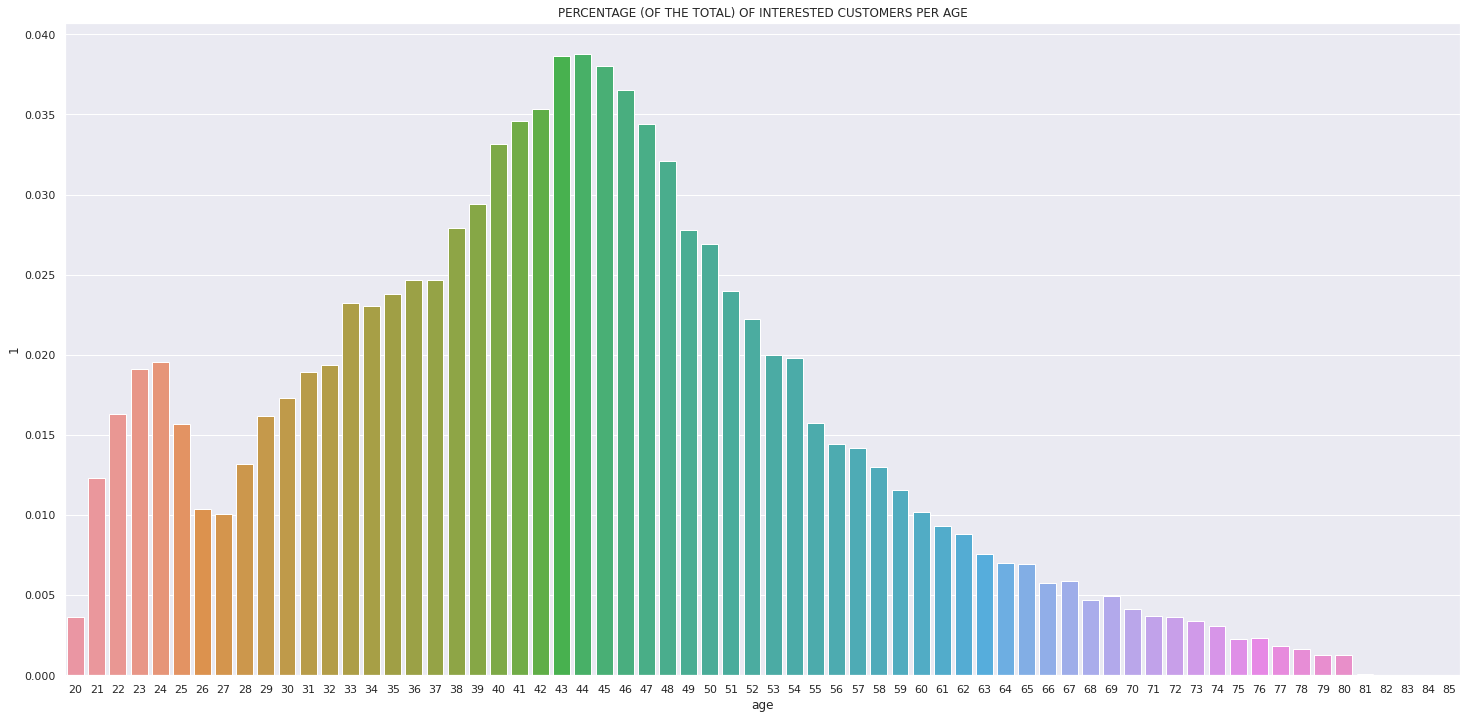

In [62]:
# plot response against percentage of interested customers per age
sns.barplot( x = 'age', y = 1, data = df_h5.reset_index() )
plt.title( 'PERCENTAGE (OF THE TOTAL) OF INTERESTED CUSTOMERS PER AGE' );

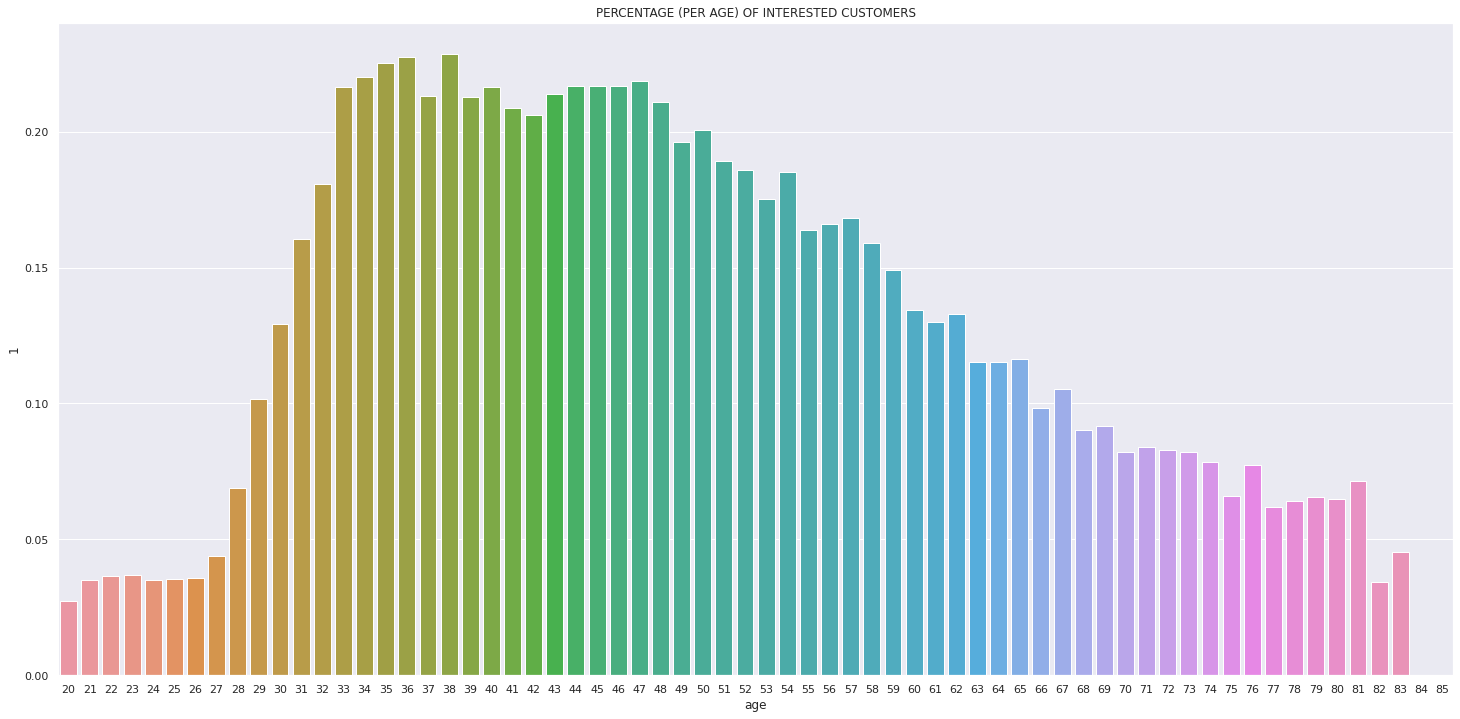

In [63]:
# create auxiliary crosstab with index normalization
df_h5_aux = pd.crosstab( df_customers_eda['age'], df_customers_eda['response'],
                     normalize = 'index' )

# plot percentage of interested customers per age
sns.barplot( x = 'age', y = 1, data = df_h5_aux.reset_index() )
plt.title( 'PERCENTAGE (PER AGE) OF INTERESTED CUSTOMERS' );

### **H6. Considering people interested in automobile insurance, most of them are women.**

>**H6 IS FALSE**. There are more men interested in automobile insurance than women.

In [64]:
# create cross tabulation with gender and response columns
df_h6 = pd.crosstab( df_customers_eda['gender'], df_customers_eda['response'],
                     normalize = 'columns' )

df_h6

response,0,1
gender,,
Female,0.469,0.389
Male,0.531,0.611


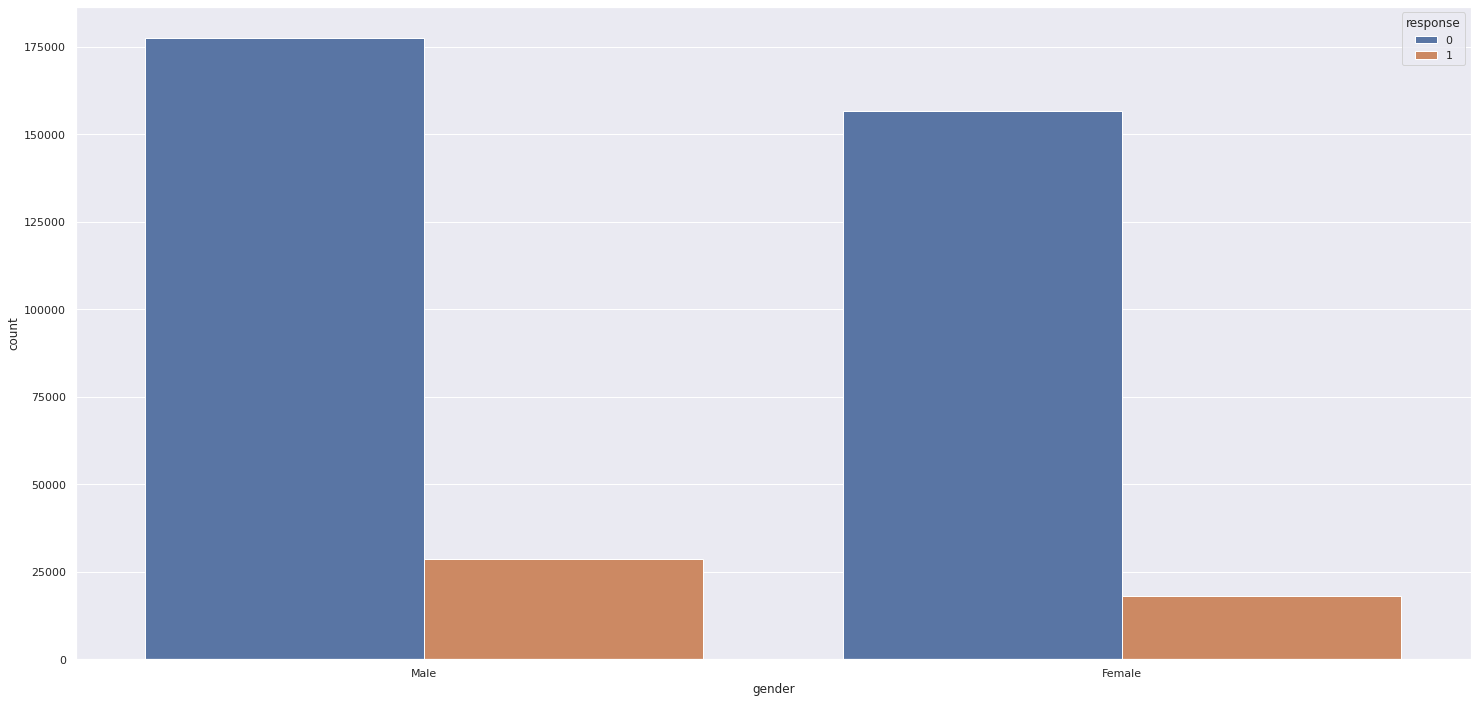

In [65]:
# plot response against gender
sns.countplot( x = 'gender', hue = 'response', data = df_customers_eda);

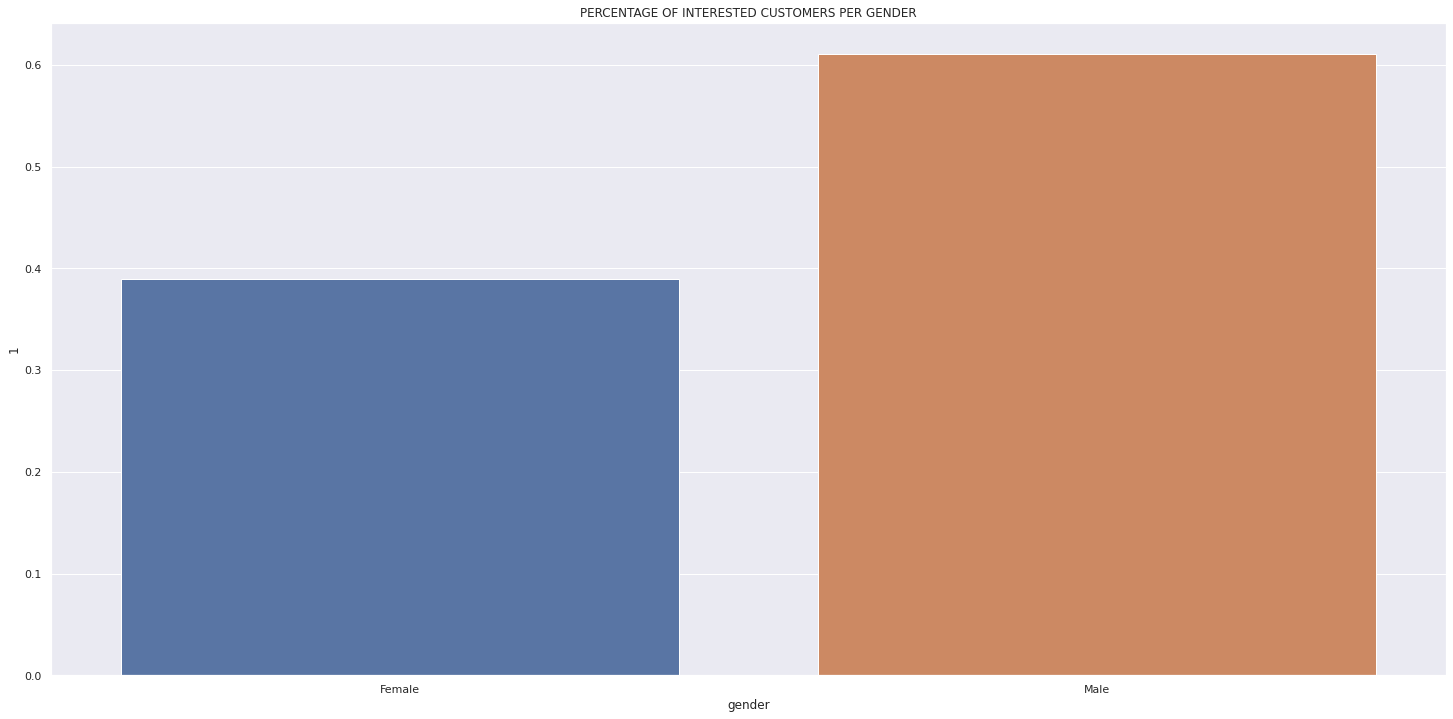

In [66]:
# plot number of interested customers per gender
sns.barplot( x = 'gender', y = 1, data = df_h6.reset_index() )
plt.title( 'PERCENTAGE OF INTERESTED CUSTOMERS PER GENDER' );

### **H7. Different sales channels have a large variation in terms of the number of interested customers.**


>**H7 IS TRUE**. The number of interested customers may vary largely among sales channels.

In [67]:
# create cross tabulation with policy_sales_channel and response columns
df_h7 = pd.crosstab( df_customers_eda['policy_sales_channel'], df_customers_eda['response'],
                     normalize = 'columns' )

df_h7.sample( 5 )

response,0,1
policy_sales_channel,,
36,0.000,0.000
154,0.014,0.032
75,0.000,0.000
14,0.002,0.001
26,0.191,0.340


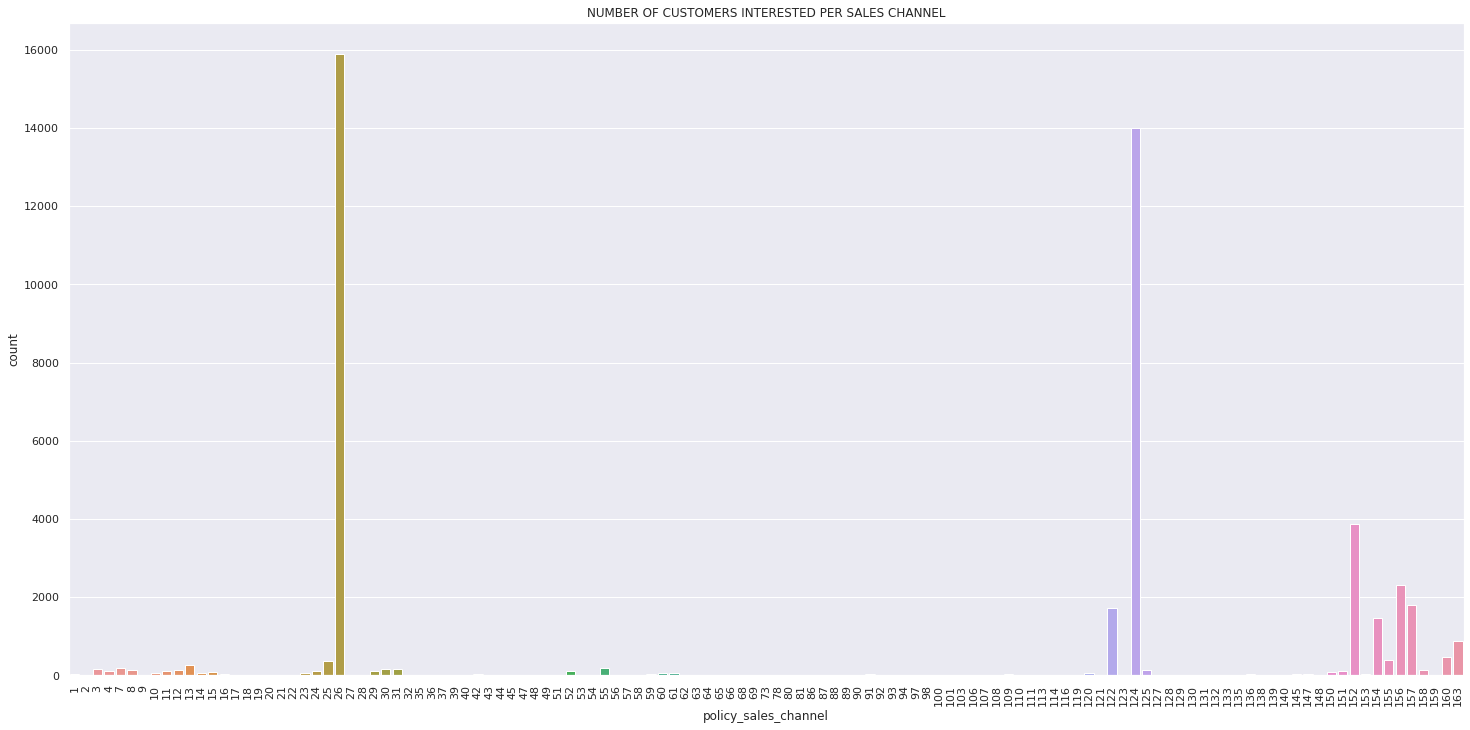

In [68]:
# plot response against policy_sales_channel
sns.countplot( x = 'policy_sales_channel', data = df_customers_eda[ df_customers_eda['response'] == 1 ])
plt.title( 'NUMBER OF CUSTOMERS INTERESTED PER SALES CHANNEL' )
plt.xticks( rotation = 90 );

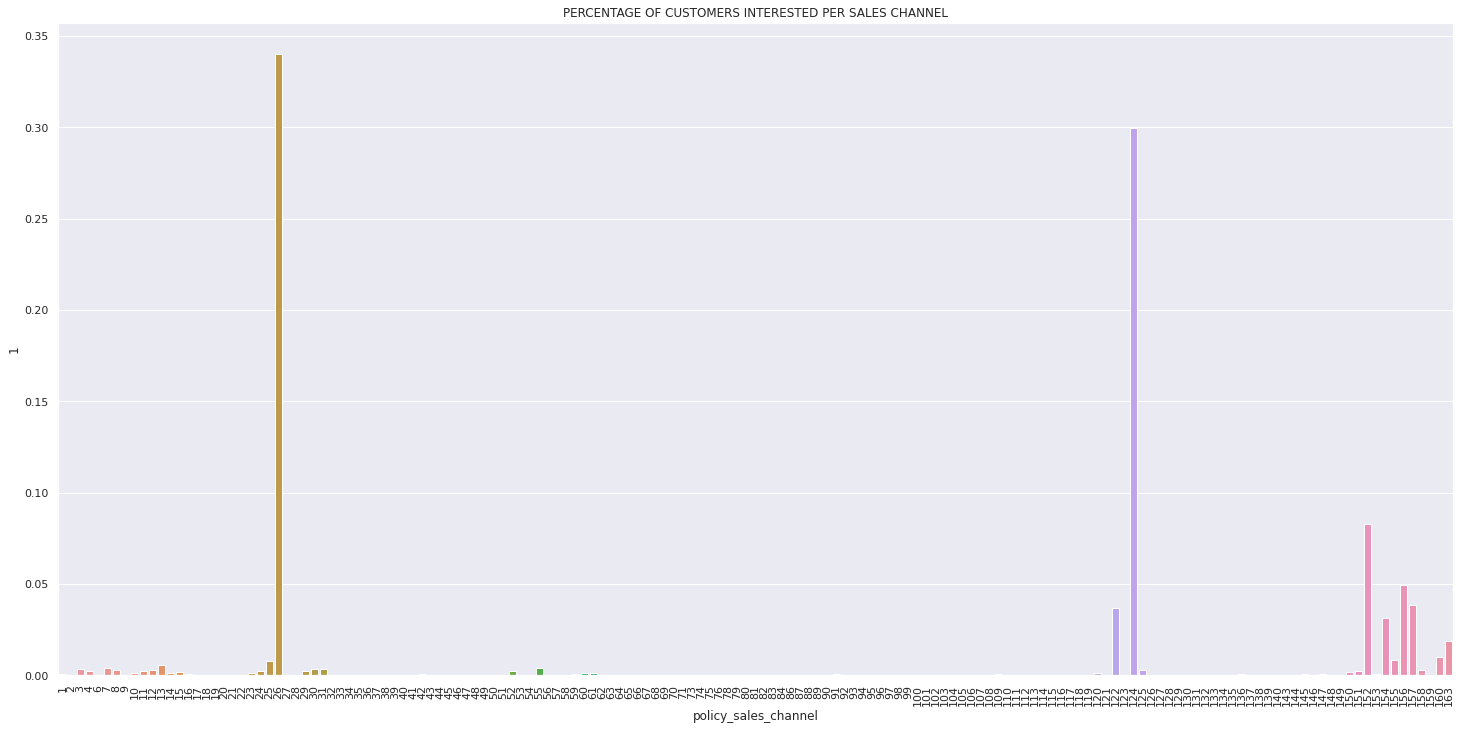

In [69]:
# plot response against policy_sales_channel
sns.barplot( x = 'policy_sales_channel', y = 1, data = df_h7.reset_index() )
plt.title( 'PERCENTAGE OF CUSTOMERS INTERESTED PER SALES CHANNEL' )
plt.xticks( rotation = 90 );

### **H8. Considering people interested in automobile insurance, most of them had contracted automobile insurance in the past.**

>**H8 IS FALSE**. The majority of interested customers have never contracted automobile insurance.

In [70]:
# create cross tabulation with previously_insured and response columns
df_h8 = pd.crosstab( df_customers_eda['previously_insured'], df_customers_eda['response'],
                     normalize = 'columns')

df_h8

response,0,1
previously_insured,,
0,0.478,0.997
1,0.522,0.003


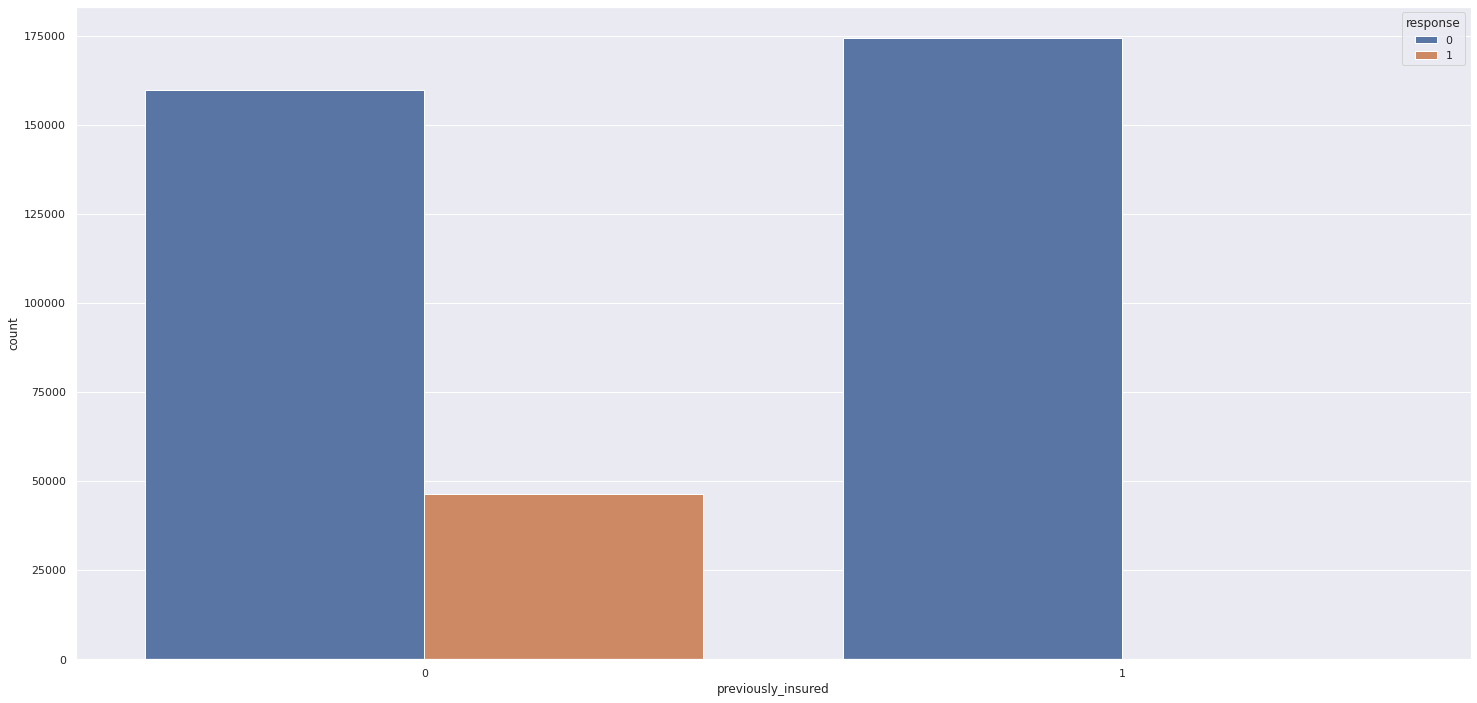

In [71]:
# plot response against previously_insured
sns.countplot( x = 'previously_insured', hue = 'response', data = df_customers_eda);

### **H9. Considering people interested in automobile insurance, most of them contracted cheaper health insurance in the past.**

>**H9 IS FALSE**. The number of interested customers doesn't always decrease with increasing annual health insurance premium of past contracts. There is a region of annual premium about 35000 where, the higher the annual premium, the higher the number of interested customers.

In [72]:
# create cross tabulation with annual_premium and response columns
df_h9 = pd.crosstab( df_customers_eda['annual_premium'], df_customers_eda['response'] )
                     
df_h9.head()

response,0,1
annual_premium,,
2630,56372,8505
6098,1,0
7670,1,0
8739,1,0
9792,1,0


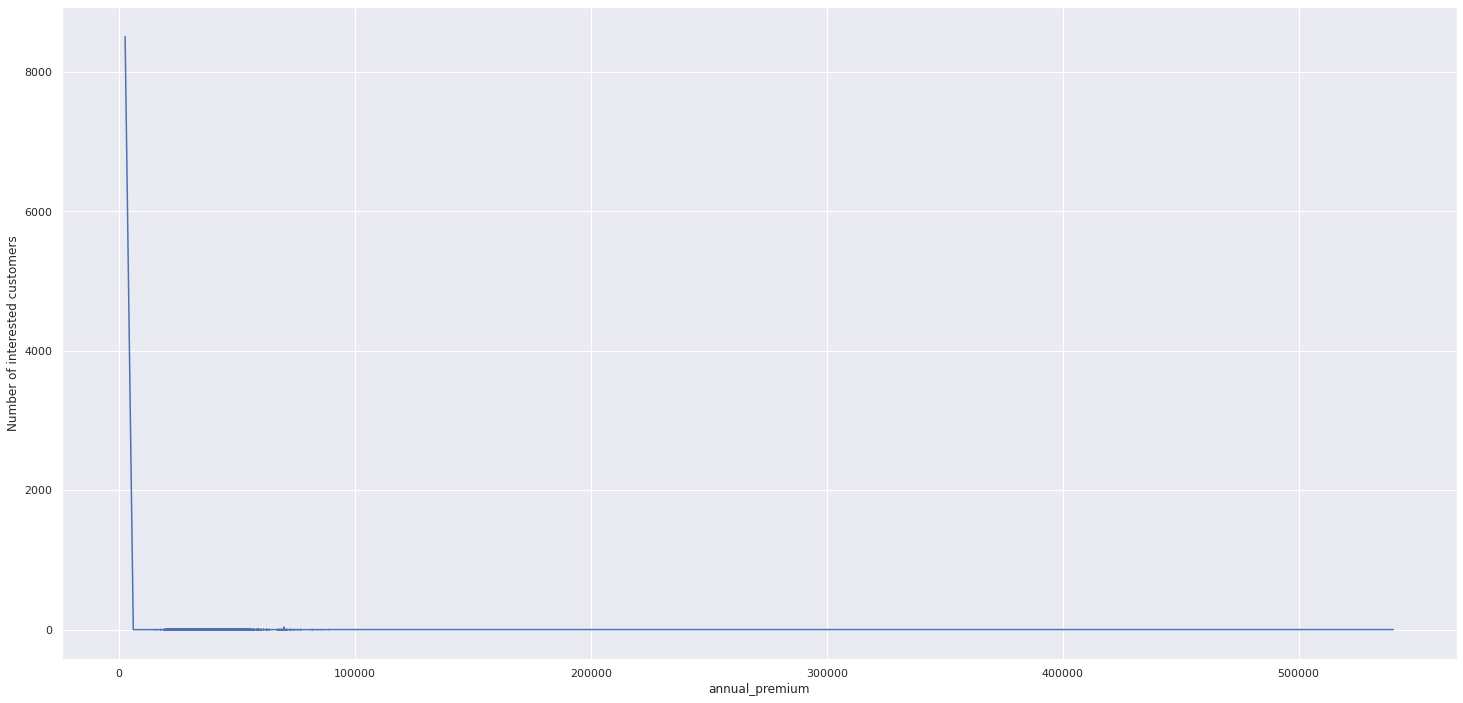

In [73]:
# plot number of interested customers against annual_premium
sns.lineplot( x = 'annual_premium', y = 1, data = df_h9.reset_index() )
plt.ylabel( 'Number of interested customers' );

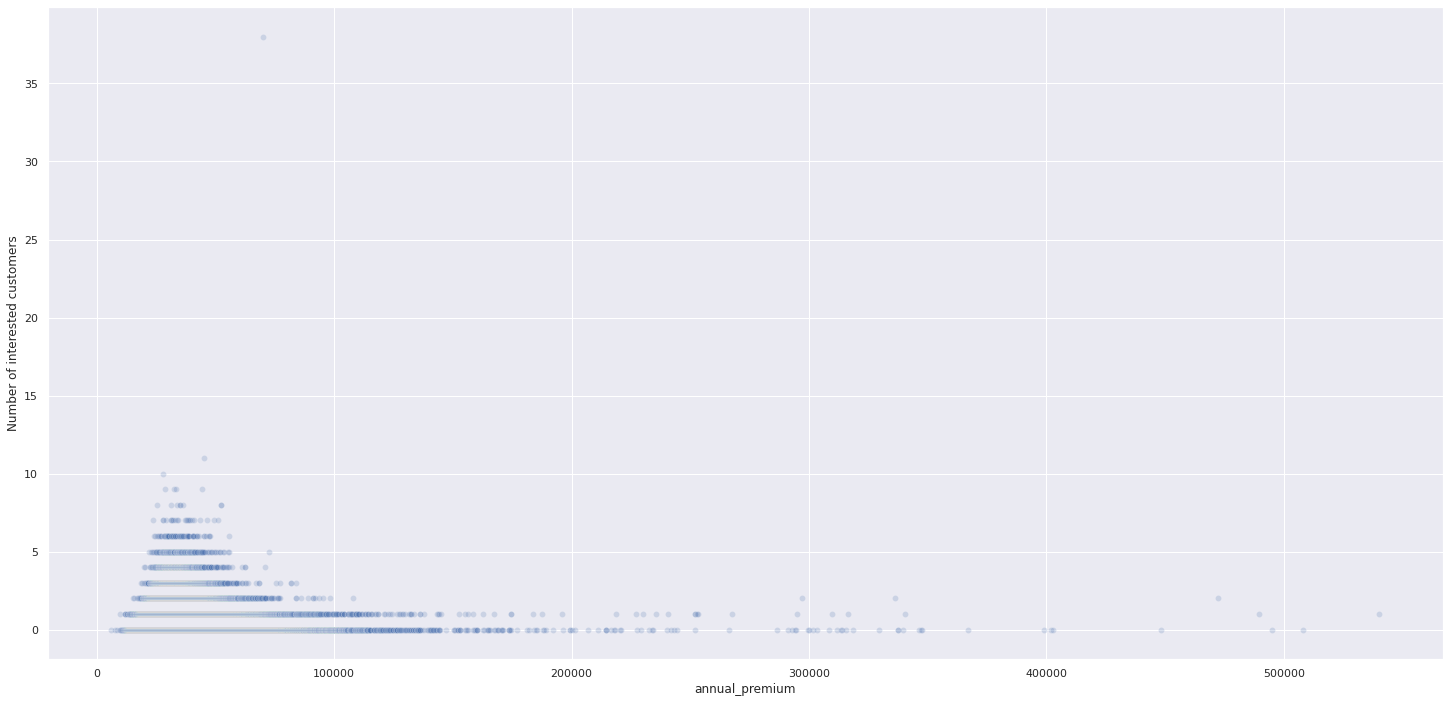

In [74]:
# create auxiliary dataframe
df_aux = df_h9.reset_index()

# plot number of interested customers against 'annual_premium > 3000'
sns.scatterplot( x = 'annual_premium', y = 1, data = df_aux[ df_aux['annual_premium'] > 3000], alpha = 0.2 )
plt.ylabel( 'Number of interested customers' );

In [75]:
# create auxiliary dataframe with percentage of interest per annual_premium
# normalize over rows
df_h9_aux = pd.crosstab( df_customers_eda['annual_premium'], df_customers_eda['response'],
                         normalize = 'index')

df_h9_aux.head()

response,0,1
annual_premium,,
2630,0.869,0.131
6098,1.000,0.000
7670,1.000,0.000
8739,1.000,0.000
9792,1.000,0.000


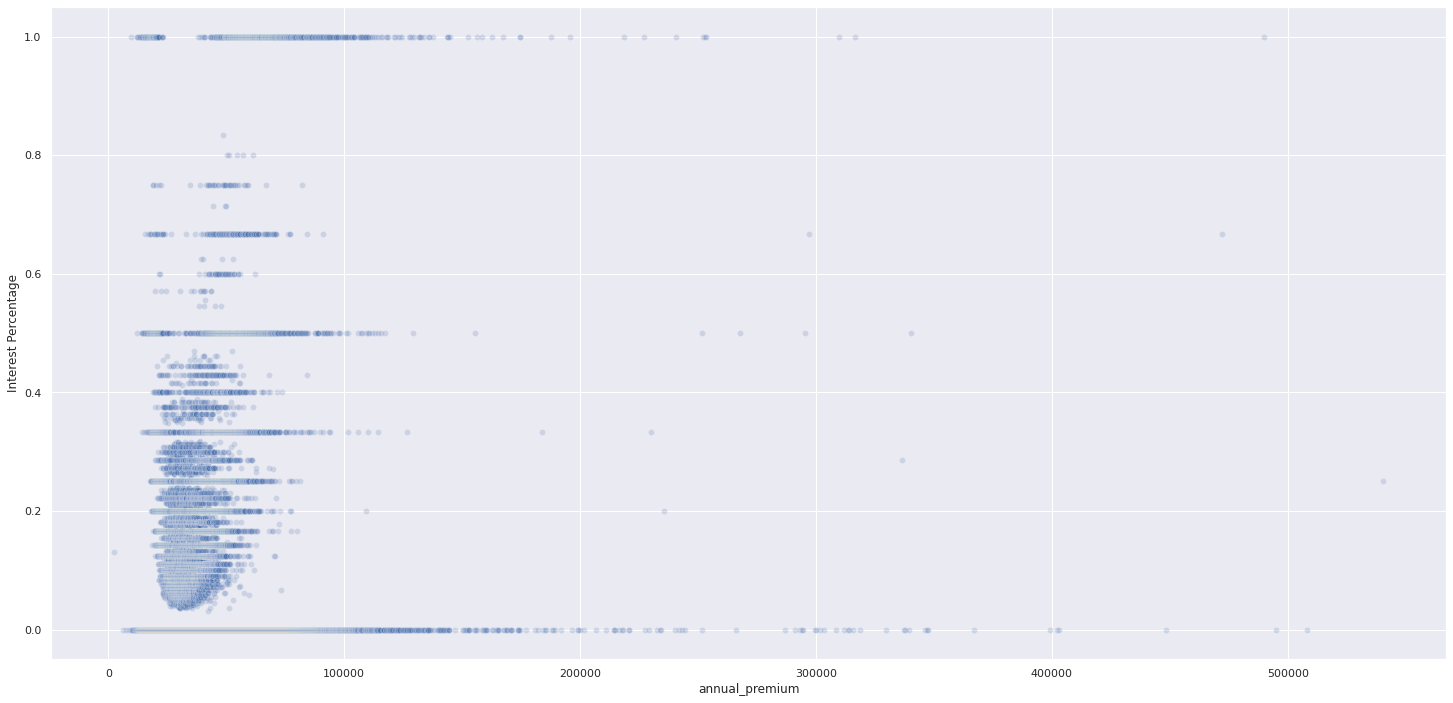

In [76]:
# plot interest percentage over annual_premium
sns.scatterplot( x = 'annual_premium', y = 1, data = df_h9_aux.reset_index(), alpha = 0.2 )
plt.ylabel( 'Interest Percentage' );

### **H10. Considering people interested in automobile insurance, most of them had contracted health insurance for a longer time interval.**

>**H10 IS FALSE**. There is no clear relationship between the number of interested customers and how long the customers' previous insurance contracts were.

In [77]:
# create cross tabulation with vintage and response columns
df_h10 = pd.crosstab( df_customers_eda['vintage'], df_customers_eda['response'],
                      normalize = 'columns')

df_h10

response,0,1
vintage,,
10,0.003,0.003
11,0.003,0.004
12,0.003,0.004
13,0.003,0.004
14,0.003,0.003
...,...,...
295,0.003,0.003
296,0.003,0.003
297,0.003,0.003


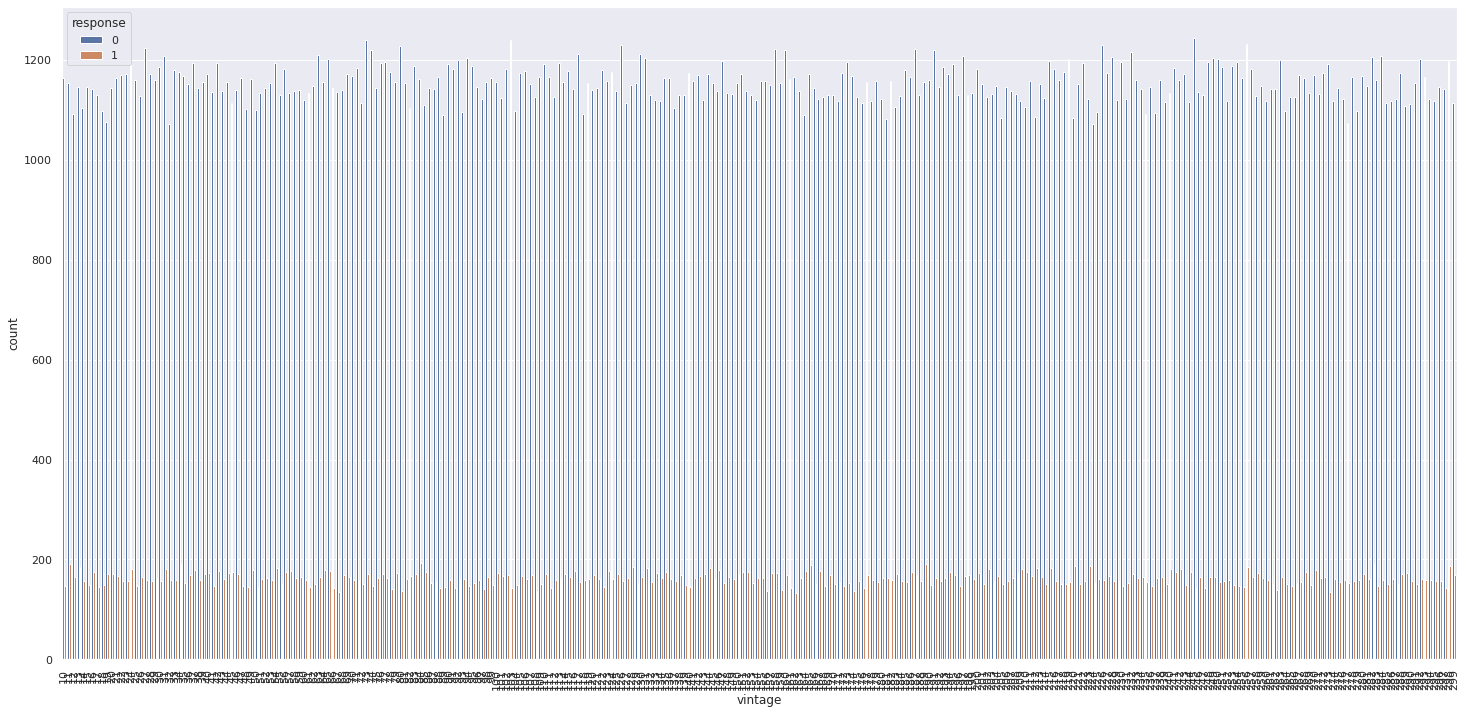

In [78]:
# plot response against vintage
sns.countplot(x = 'vintage', hue = 'response', data = df_customers_eda)
plt.xticks( rotation = 90 );

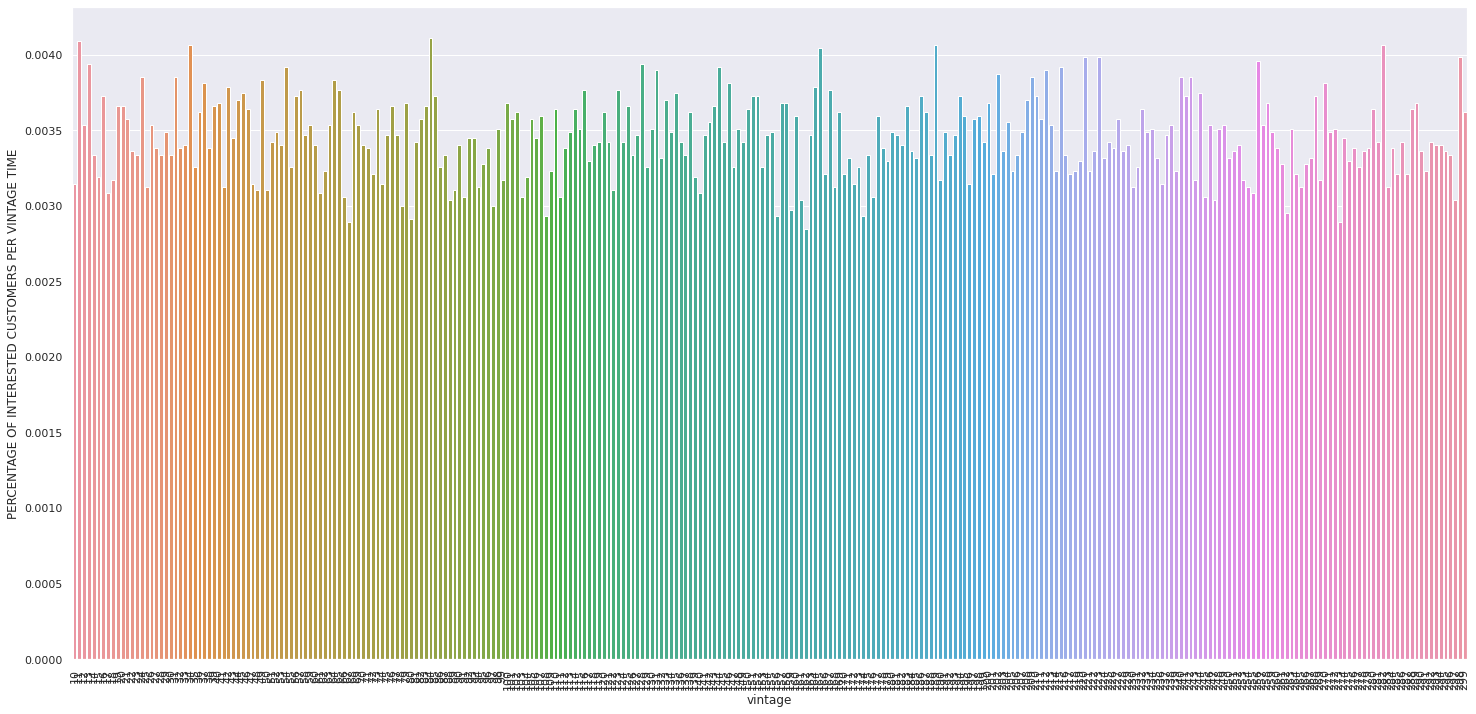

In [79]:
# plot percentage of interested customers per vintage time
sns.barplot( x = 'vintage', y = 1, data = df_h10.reset_index() )
plt.ylabel( 'PERCENTAGE OF INTERESTED CUSTOMERS PER VINTAGE TIME' )
plt.xticks( rotation = 90 );

### Summary

In [80]:
hypothesis_tab = [
['H1', 'True'],
['H2', 'True'],
['H3', 'True'],
['H4', 'True'],
['H5', 'False'],
['H6', 'False'],
['H7', 'True'],
['H8', 'False'],
['H9', 'False'],
['H10', 'False'] 
]

pd.DataFrame( hypothesis_tab, columns = ['HYPOTHESIS', 'CONCLUSION'] )

,HYPOTHESIS,CONCLUSION
0,H1,True
1,H2,True
2,H3,True
3,H4,True
4,H5,False
5,H6,False
6,H7,True
7,H8,False
8,H9,False
9,H10,False


In [81]:
features_tab = [
['gender', 'medium'],
['age', 'high'],
['region_code', 'medium'],
['policy_sales_channel', 'high' ],
['previously_insured', 'medium' ],
['annual_premium', 'high'],
['vintage', 'low'],
['driving_license', 'low' ],
['vehicle_age', 'medium'],
['vehicle_damage', 'medium'],
]

pd.DataFrame( features_tab, columns = ['FEATURES', 'RELEVANCE INTUITION'] )

,FEATURES,RELEVANCE INTUITION
0,gender,medium
1,age,high
2,region_code,medium
3,policy_sales_channel,high
4,previously_insured,medium
5,annual_premium,high
6,vintage,low
7,driving_license,low
8,vehicle_age,medium
9,vehicle_damage,medium


## Multivariate analyses

### Numerical Features

In [82]:
# create dataframe with numerical features plus response column
bi_num_columns = list(num_features.columns)
multivar_num_analyses = df_customers_eda[ bi_num_columns ]
multivar_num_analyses.head()

,age,annual_premium,vintage
0,44,40454,217
1,76,33536,183
2,47,38294,27
3,21,28619,203
4,29,27496,39


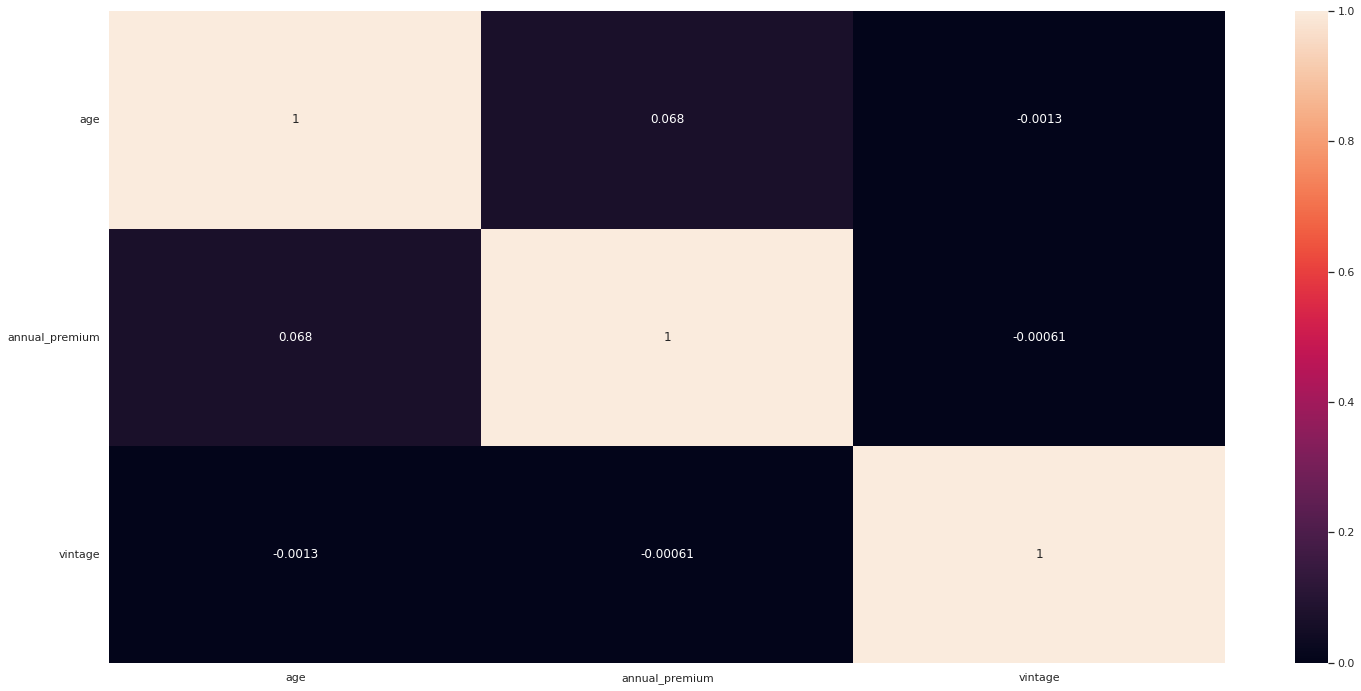

In [83]:
# calculate correlation for numerical features
correlation = multivar_num_analyses.corr( method = 'pearson' )

# display heatmap of correlation
sns.heatmap( correlation, annot = True)
plt.yticks( rotation = 0 );

### Categorical Features

In [84]:
# create dataframe with categorical features plus response column
bi_cat_columns = list(cat_features.columns)
bi_cat_columns.append('response')
multivar_cat_analysis = df_customers_eda[ bi_cat_columns ]

# check dataframe
multivar_cat_analysis.head()

,gender,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_age,vehicle_damage,response
0,Male,28,26,0,1,> 2 Years,True,1
1,Male,3,26,0,1,1-2 Year,False,0
2,Male,28,26,0,1,> 2 Years,True,1
3,Male,11,152,1,1,< 1 Year,False,0
4,Female,41,152,1,1,< 1 Year,False,0


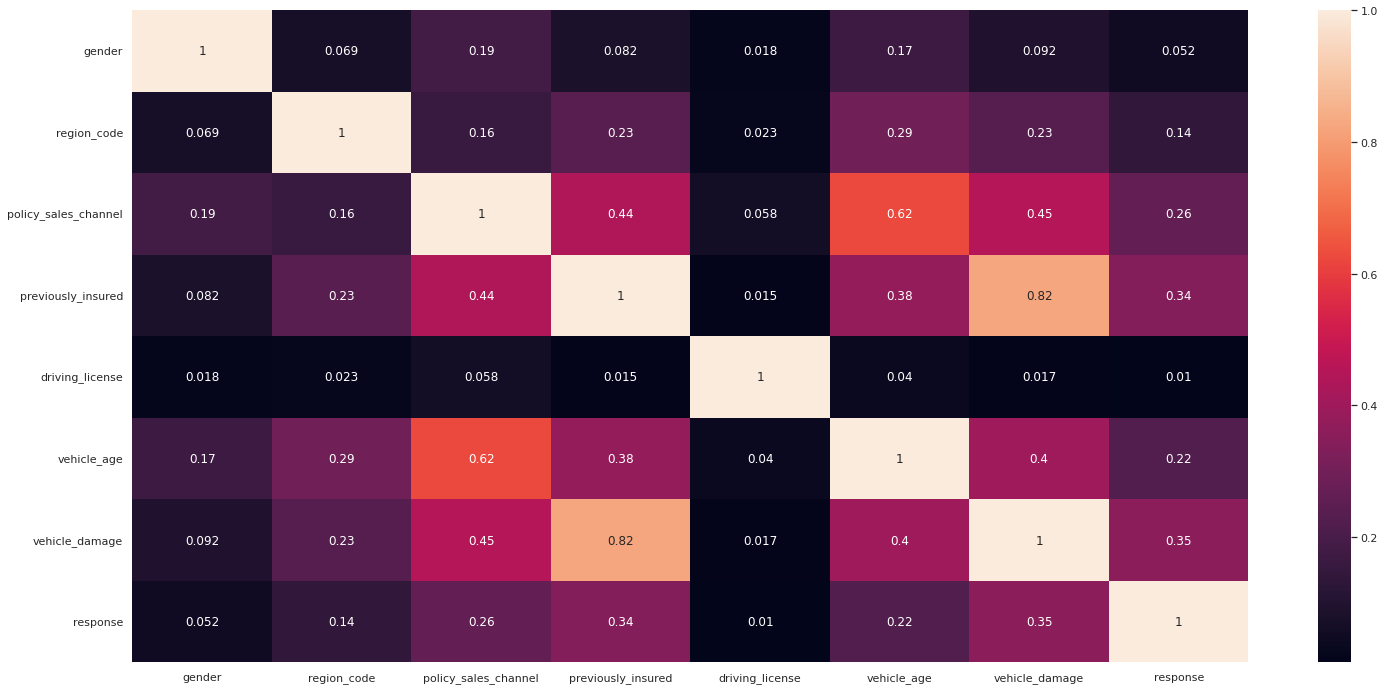

In [85]:
# create a dataframe with cramer-v for every row-column pair
cramer_v_corr = create_cramer_v_dataframe( multivar_cat_analysis )

# display heatmap
sns.heatmap( cramer_v_corr, annot = True);

# DATA PREPARATION

## Restore Point

In [86]:
# create a restore point for the previous section dataframe
df_customers_prep = df_customers_eda.copy()

# check dataframe
check_dataframe( df_customers_prep )

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
driving_license          int64
vehicle_age             object
vehicle_damage            bool
dtype: object 

Dataframe shape is (381109, 12) 



,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
7771,7772,Male,20,30,160,0,31840,231,0,1,< 1 Year,True
119418,119419,Female,21,32,152,0,27238,53,0,1,< 1 Year,True
241723,241724,Female,23,8,152,1,47469,108,0,1,< 1 Year,False
71063,71064,Female,79,28,23,0,29196,74,0,1,1-2 Year,True
46525,46526,Female,29,28,26,0,42393,112,0,1,1-2 Year,True


## Split dataframe into training and test dataset

In [87]:
# split original dataset into train and not_to_train dataset
df_not_test, df_test = train_test_split( df_customers_prep, test_size = 0.10, random_state = 10 )

# split df_not_test into cross-validation and test dataset
df_validation, df_train = train_test_split( df_not_test, test_size = 0.78, random_state = 10 )

# check splits
assert len( df_customers_prep ) == len( df_train ) + len( df_validation ) + len( df_test )

In [88]:
print( 
f'''From the initial dataset:
{round( (df_train.shape[0] / df_customers_prep.shape[0]) * 100, 0) }% is the training set, 
{round( (df_validation.shape[0] / df_customers_prep.shape[0]) * 100, 0)}% is the validation set,
{round( (df_test.shape[0] / df_customers_prep.shape[0]) * 100, 0)}% is the testing set'''
)

From the initial dataset:
70.0% is the training set, 
20.0% is the validation set,
10.0% is the testing set


In [89]:
# split train dataset into x and y
y_train = df_train[ 'response' ]
X_train = df_train.drop( 'response', axis = 1 )

# split cross-validation dataset into x and y
y_validation = df_validation[ 'response' ]
X_validation = df_validation.drop( 'response', axis = 1 )

# split test dataset into x and y
y_test = df_test[ 'response' ]
X_test = df_test.drop( 'response', axis = 1 )

## Normalization

## Rescaling

In [90]:
# create robust scaler and min-max objects
rs = RobustScaler()
mms = MinMaxScaler()

### RESCALE WITH MIN-MAX SCALER (due to no outliers)

In [91]:
# NOTE: rescaling will be made by calling rescale_and_encode function

# # make min-max scaler learn on age column of training dataset
# with open('../src/features/age_mms.pkl', 'wb') as file: 
#     mms.fit( X_train['age'].values.reshape(-1,1) )
#     pickle.dump( mms, file)

# # make min-max scaler learn on vintage column of training dataset   
# with open('../src/features/vintage_mms.pkl', 'wb') as file: 
#     mms.fit( X_train['vintage'].values.reshape(-1,1) )
#     pickle.dump( mms, file)

### RESCALE WITH ROBUST SCALER (due to outliers)

In [92]:
# NOTE: rescaling will be made by calling rescale_and_encode function

# make robust scaler learn on annual_premium column of training dataset 
# with open('../src/features/annual_premium_rs.pkl', 'wb') as file: 
#     rs.fit( X_train['annual_premium'].values.reshape(-1,1) )
#     pickle.dump( rs, file)

## Encoding

In [93]:
# NOTE: all encodings will be made by calling rescale_and_encode function


# encode gender column -> convert to number
'''map( { 'Male': 1, 
          'Female': 0 } )'''

# encode vehicle_damage column -> convert boolean to integers
'''.astype( int )'''

# encode vehicle_age column -> ordinal encoding
'''map( {'< 1 Year': 0, 
         '1-2 Year': 1, 
        '> 2 Years': 2 } )'''

# encode policy_sales_channel -> frequency encoding
'''.groupby( 'policy_sales_channel' ).size() / len( X_train )'''

# encode region_code -> frequency encoding
'''groupby( 'region_code' ).size() / len( X_train )''';

## Transformation

In [94]:
X_train = rescale_and_encode( X_train )

In [95]:
numerical_statistics( X_train )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,id,190567.984,190489.000,109987.463,1.000,381109.000,381108.000,-0.000,-1.199
1,gender,0.542,1.000,0.498,0.000,1.000,1.000,-0.169,-1.971
2,age,0.290,0.246,0.238,0.000,1.000,1.000,0.670,-0.569
3,region_code,0.000,0.000,0.001,0.000,0.279,0.279,398.374,179549.150
4,policy_sales_channel,0.000,0.000,0.000,0.000,0.210,0.210,447.919,214901.564
5,previously_insured,0.459,0.000,0.498,0.000,1.000,1.000,0.165,-1.973
6,annual_premium,-0.073,0.000,1.158,-1.938,33.959,35.897,1.990,38.549
7,vintage,0.499,0.498,0.289,0.000,1.000,1.000,0.004,-1.199
8,driving_license,0.998,1.000,0.047,0.000,1.000,1.000,-21.389,455.491
9,vehicle_age,0.610,1.000,0.567,0.000,2.000,2.000,0.250,-0.794


### Response Variable Transformation

In [96]:
# check response variable
y_train.value_counts()

0    234686
1     32853
Name: response, dtype: int64

### Nature Transformation

# FEATURE SELECTION

## Boruta as feature selector

In [97]:
# # prepare x_train for buruta
# X_train_model = X_train.drop('id', axis = 'columns').fillna(0).values

# # prepare y_train for buruta
# y_train_model = y_train.fillna(0).values

# # create random forest classifier object
# rf = RandomForestClassifier( n_jobs = -1 )

# # run boruta to select besst features
# boruta = BorutaPy( rf, n_estimators = 'auto', 
#                    verbose = 2, random_state = 10 ).fit( X_train_model, y_train_model)

In [98]:
# # columns selected by Boruta
# cols_selected_bool = boruta.support_.tolist()

# # columns selected by boruta
# cols_selected_boruta_list = X_train.drop('id', axis = 'columns').loc[ :, cols_selected_bool ].columns.to_list()

# cols_selected_boruta_list

In [99]:
# Columns selected by Boruta
'''Columns selected by Boruta: None
''';

## Feature Importance

In [100]:
# # prepare x_train
# X_train_model = X_train.drop('id', axis = 'columns').fillna(0).values

# # prepare y_train
# y_train_model = y_train.fillna(0).values

# # model definition
# rf = RandomForestClassifier( n_estimators = 250, random_state = 0 , n_jobs = -1 )

# # fit random forest classifier to training data
# rf.fit( X_train_model, y_train_model )

In [101]:
# # importance for features
# importances = rf.feature_importances_

# # std for features along tress
# std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# # indices to sort importance
# indices = np.argsort(importances)[::-1]

# # create dataframe with features, importance and std
# data = {'feature': X_train.drop('id', axis = 'columns').columns, 'importance': importances, 'std': std}
# feature_rank = pd.DataFrame( data = data ).sort_values( 'importance', ascending = False )

# # show feature rank dataframe
# feature_rank

In [102]:
# # plot bar with importance and std
# sns.barplot( x = 'feature', y = 'importance', yerr = feature_rank['std'], data = feature_rank )
# plt.xlabel( 'FEATURE' )
# plt.ylabel( 'IMPORTANCE' );

## Manual Feature Selection

In [103]:
cols_selected = [
'vintage', 
'annual_premium', 
'age', 
'vehicle_damage', 
'previously_insured',
'vehicle_age']

# MACHINE LEARNING MODELLING

In [104]:
# select features of X_train
X_train = X_train[ cols_selected ]

# prepare x_train for ML models
X_train_model = X_train.fillna(0).values

# prepare y_train ML models
y_train_model = y_train.fillna(0).values

# apply transformations (rescale and encoding) for X_validation dataframe
X_validation = rescale_and_encode( X_validation )

# select features of X_validation
X_validation = X_validation[ cols_selected ]

# prepare x_validation for ML models
X_validation_model = X_validation.fillna(0).values

# prepare y_validation ML models
y_validation_model = y_validation.fillna(0).values

## Logistic Regression

In [105]:
# # model definition
# logreg = LogisticRegression( n_jobs = -1, random_state = 10 )

# # model training
# logreg.fit(X_train_model, y_train_model)

In [106]:
# # save the logreg trained model
# with open( '../models/logreg.pkl', 'wb') as file:
#     pickle.dump( logreg, file )

In [107]:
# Load the Model back from file
with open('../models/logreg.pkl', 'rb') as file:  
    logreg = pickle.load( file )

In [108]:
# model prediction - probability
yhat_lr = logreg.predict_proba( X_validation_model )

In [109]:
# model size
logreg_size_mb = round( os.path.getsize('../models/logreg.pkl') / (1024**2), 2)
logreg_size_mb

0.0

## k-Nearest Neighbours

In [110]:
# # model definition
# knn = KNeighborsClassifier( n_jobs = -1 )

# # model training
# knn.fit( X_train_model, y_train_model )

In [111]:
# # Save the knn trained model
# with open( '../models/knn.pkl', 'wb' ) as file:
#     pickle.dump( knn, file )

In [112]:
# Load the Model back from file
with open('../models/knn.pkl', 'rb') as file:  
    knn = pickle.load( file )

In [113]:
# model prediction - probability
yhat_knn = knn.predict_proba( X_validation_model )

In [114]:
# model size
knn_size_mb = round( os.path.getsize('../models/knn.pkl') / (1024**2), 2)
knn_size_mb

30.58

## Naive Bayes

In [115]:
# # model definition
# naive = GaussianNB()

# # model training
# naive.fit(X_train_model, y_train_model)

In [116]:
# # Save the naive trained model
# with open( '../models/naive.pkl', 'wb' ) as file:
#     pickle.dump( naive, file)

In [117]:
# Load the trained model
with open( '../models/naive.pkl', 'rb') as file:  
    naive = pickle.load(file)

In [118]:
# model prediction - probability
yhat_naive  =  naive.predict_proba(X_validation_model)

In [119]:
# model size
naive_size_mb = round( os.path.getsize('../models/naive.pkl') / (1024**2), 2)
naive_size_mb

0.0

## ExtraTrees

In [120]:
# # model definition
# et = ExtraTreesClassifier( n_jobs = -1, random_state = 10 )

# # model training
# et.fit(X_train_model, y_train_model)

In [121]:
# # save the ExtraTrees trained model
# with open( '../models/et.pkl', 'wb') as file:
#     pickle.dump( et, file )

In [122]:
# Load the Model back from file
with open('../models/et.pkl', 'rb') as file:  
    et = pickle.load( file )

In [123]:
# model prediction - probability
yhat_et = et.predict_proba( X_validation_model )

In [124]:
# model size
et_size_mb = round( os.path.getsize('../models/et.pkl') / (1024**2), 2)
et_size_mb

1074.62

## Random Forest

In [125]:
# # model definition
# rf = RandomForestClassifier( n_jobs = -1, random_state = 10 )

# # model training
# rf.fit( X_train_model, y_train_model )

In [126]:
# # save random forest trained model
# with open( '../models/rf.pkl' , 'wb' ) as file:
#     pickle.dump( rf, file )

In [127]:
# Load the random forest model back from file
with open('../models/rf.pkl', 'rb') as file:  
    rf = pickle.load( file )

In [128]:
# model prediction - probability
yhat_rf = rf.predict_proba( X_validation_model )

In [129]:
# model size
rf_size_mb = round( os.path.getsize('../models/rf.pkl') / (1024**2), 2)
rf_size_mb

426.9

## XGBoost

In [130]:
# # model definition
# xgb = XGBClassifier( use_label_encoder = False, n_jobs = -1, seed = 10 )

# # model training
# xgb.fit(X_train_model, y_train_model);

In [131]:
# # save the XGBoost trained model
# with open( '../models/xgb.pkl', 'wb') as file:
#     pickle.dump( xgb, file )

In [132]:
# Load the Model back from file
with open('../models/xgb.pkl', 'rb') as file:  
    xgb = pickle.load( file )

In [133]:
# model prediction - probability
yhat_xgb = xgb.predict_proba( X_validation_model )

In [134]:
# model size
xgb_size_mb = round( os.path.getsize('../models/xgb.pkl') / (1024**2), 2)
xgb_size_mb

0.53

## LightGBM

In [135]:
# # model definition
# lgbm = LGBMClassifier( n_jobs = -1, random_state = 10 )

# # # model training
# lgbm.fit(X_train_model, y_train_model)

In [136]:
# # save the lgbm trained model
# with open( '../models/lgbm.pkl', 'wb') as file:
#     pickle.dump( lgbm, file )

In [137]:
# Load the Model back from file
with open('../models/lgbm.pkl', 'rb') as file:  
    lgbm = pickle.load( file )

In [138]:
# model prediction - probability
yhat_lgbm = lgbm.predict_proba( X_validation_model )

In [139]:
# model size
lgbm_size_mb = round( os.path.getsize('../models/lgbm.pkl') / (1024**2), 2)
lgbm_size_mb

0.33

## CatBoost

In [140]:
# # model definition
# cat = CatBoostClassifier( verbose = False, random_state = 10 )

# # model training
# cat.fit(X_train_model, y_train_model)

In [141]:
# # save the cat trained model
# with open( '../models/cat.pkl', 'wb') as file:
#     pickle.dump( cat, file )

In [142]:
# Load the Model back from file
with open('../models/cat.pkl', 'rb') as file:  
    cat = pickle.load( file )

In [143]:
# model prediction - probability
yhat_cat = cat.predict_proba( X_validation_model )

In [144]:
# model size
cat_size_mb = round( os.path.getsize('../models/cat.pkl') / (1024**2), 2)
cat_size_mb

1.03

## Model Comparison

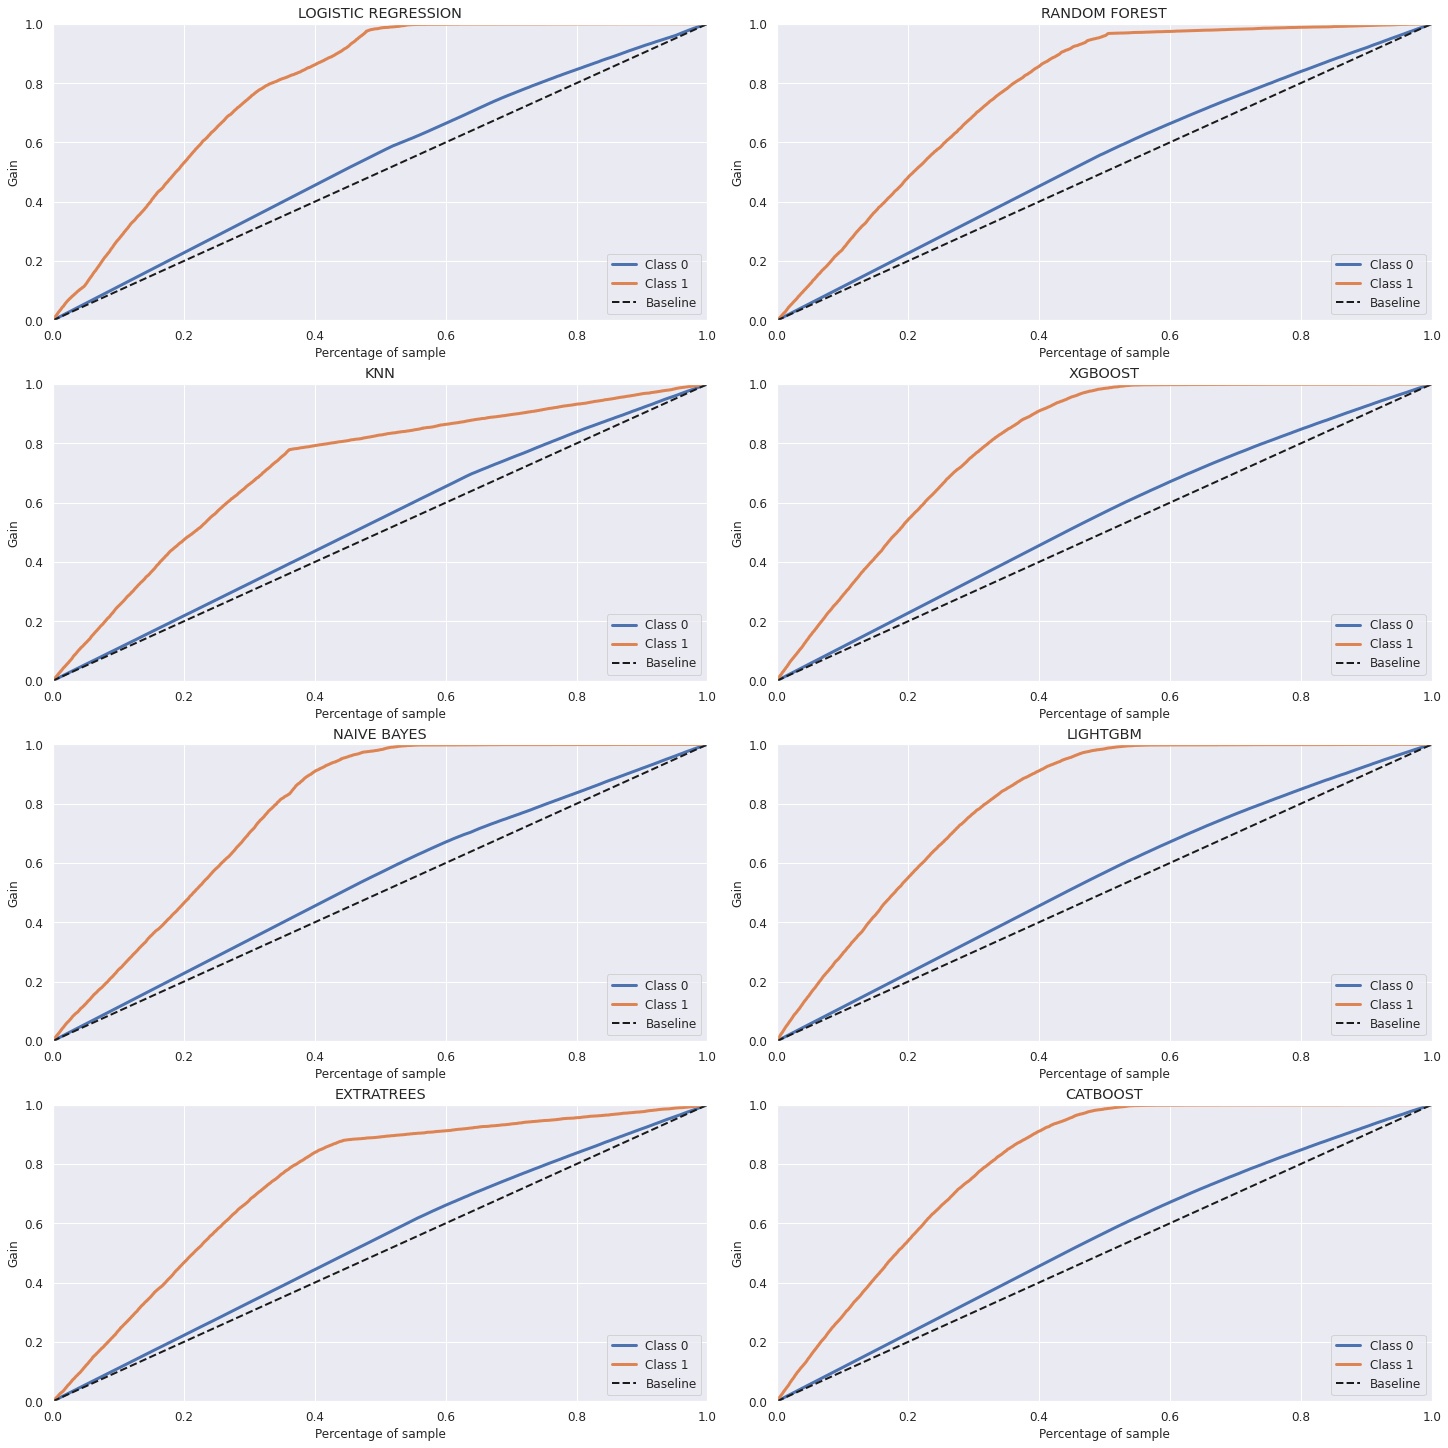

In [145]:
# create a figure object
fig = plt.figure( figsize = (20, 20) , constrained_layout = True )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 2, nrows = 4, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )
ax4 = fig.add_subplot( specs[ 3, 0 ] )
ax5 = fig.add_subplot( specs[ 0, 1 ] )
ax6 = fig.add_subplot( specs[ 1, 1 ] )
ax7 = fig.add_subplot( specs[ 2, 1 ] )
ax8 = fig.add_subplot( specs[ 3, 1 ] )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_lr, 
                                    title = 'LOGISTIC REGRESSION', ax = ax1    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_knn,
                                    title = 'KNN',                 ax = ax2    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_naive,
                                    title = 'NAIVE BAYES',         ax = ax3    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_et,
                                    title = 'EXTRATREES',          ax = ax4    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_rf,
                                    title = 'RANDOM FOREST',       ax = ax5    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_xgb,
                                    title = 'XGBOOST',             ax = ax6    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_lgbm, 
                                    title = 'LIGHTGBM',            ax = ax7    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model,            yhat_cat,
                                    title = 'CATBOOST',            ax = ax8   );

In [146]:
# list predictions made
yhat_predictions = { 'Logistic Regression': [yhat_lr, logreg_size_mb] , 
                     'KNN': [yhat_knn, knn_size_mb], 
                     'Naive Bayes': [yhat_naive, naive_size_mb], 
                     'ExtraTrees': [yhat_et, et_size_mb], 
                     'Random Forest': [yhat_rf, rf_size_mb],
                     'XGBoost': [yhat_xgb, xgb_size_mb],
                     'LightGBM': [yhat_lgbm, lgbm_size_mb],
                     'CatBoost': [yhat_cat, cat_size_mb]
                   }

# create dataframe to compare models
performance_comparison = pd.DataFrame()

for model_name, model in yhat_predictions.items():
    # create model key
    row = {'Model': model_name}
    
    # create model 
    row['Size in MB'] = model[1]
        
    # order validation according to propensity score
    df_propensity_ordered = propensity_score_ordering( X_validation, y_validation, model[0])

    # compute precision at k
    row['recall_at_20000'] = recall_at_k(  df_propensity_ordered, k = 20000 )
    row['recall_at_40000'] = recall_at_k(  df_propensity_ordered, k = 40000 )
        
    # compute precision at k
    row['precision_at_20000'] = precision_at_k( df_propensity_ordered, k = 20000 )
    row['precision_at_40000'] = precision_at_k( df_propensity_ordered, k = 40000 )
            
    # append to comparison dataframe    
    performance_comparison = performance_comparison.append(row, ignore_index = True)

performance_comparison.sort_values( ['recall_at_20000', 'recall_at_40000'], 
                                    ascending = False )    

,Model,Size in MB,recall_at_20000,recall_at_40000,precision_at_20000,precision_at_40000
6,LightGBM,0.330,0.696,0.994,0.320,0.229
5,XGBoost,0.530,0.691,0.994,0.318,0.229
7,CatBoost,1.030,0.689,0.994,0.317,0.229
0,Logistic Regression,0.000,0.683,0.992,0.314,0.228
4,Random Forest,426.900,0.617,0.969,0.284,0.223
2,Naive Bayes,0.000,0.615,0.994,0.283,0.229
3,ExtraTrees,1074.620,0.609,0.898,0.280,0.207
1,KNN,30.580,0.603,0.838,0.277,0.193


In [147]:
print( "\
NOTE: \
\n \
\nk = 20.000 is based on the business problem, \
\nwhere the 'production' data will be about 127.000 customers. \
\n \
\nHowever, validation data is about 75.000 customers. \
\nTherefore, to use the same proportion in the above comparison as the production context, \
\nk needs to be about 12.000. \
\n \
\nEquivalent k calculation: \
\n\tequivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]")

NOTE: 
 
k = 20.000 is based on the business problem, 
where the 'production' data will be about 127.000 customers. 
 
However, validation data is about 75.000 customers. 
Therefore, to use the same proportion in the above comparison as the production context, 
k needs to be about 12.000. 
 
Equivalent k calculation: 
	equivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]


## Model Selection

Due to the above explanation, the chosen model is **LightGBM**.

# HYPERPARAMETER FINE TUNING

In [148]:
# params_search = { 
#     'n_estimators': [30, 100, 300],
#     'learning_rate': [0.03, 0.1, 0.3],
#     'num_leaves': [10, 30, 100],
#     }

# # create best params dataframe
# df_params_performance = pd.DataFrame()

# # number of iterations
# total_iterations = np.prod( [len(value) for value in params_search.values()] )

# # initialize iterations
# iteration = 1

# # perform RANDOM SEARCH to find best params
# for n_est in params_search['n_estimators']:
#     for l_rate in params_search['learning_rate']:
#         for n_lvs in params_search['num_leaves']:
#             # display iteration number
#             print( f'At {iteration} / {total_iterations} iteration.')
            
#             # define choosen params
#             chosen_params = { 'n_estimators':  n_est,
#                               'learning_rate': l_rate,
#                               'num_leaves':    n_lvs
#                             }                            
                
#             # define model with random params
#             lgbm = LGBMClassifier( n_estimators  = n_est,
#                                    learning_rate = l_rate,
#                                    num_leaves    = n_lvs,
#                                    n_jobs        = -1,
#                                    random_state  = 10
#                                  )  

#             # train model
#             lgbm.fit( X_train_model, y_train_model )

#             # model prediction
#             yhat_lgbm = lgbm.predict_proba( X_validation_model )

#             # order validation according to propensity score
#             df_propensity_ordered = propensity_score_ordering( X_validation, y_validation, yhat_lgbm )

#             # compute precision at k
#             precision_at_20000 = precision_at_k( df_propensity_ordered, k = 20000 )
#             precision_at_40000 = precision_at_k( df_propensity_ordered, k = 40000 )

#             # compute precision at k
#             recall_at_20000 = recall_at_k( df_propensity_ordered, k = 20000 )
#             recall_at_40000 = recall_at_k( df_propensity_ordered, k = 40000 )

#             # create row for dataframe appending
#             row = chosen_params
#             row['recall_at_20000']    = recall_at_20000
#             row['recall_at_40000']    = recall_at_40000
#             row['precision_at_40000'] = precision_at_40000,
#             row['precision_at_20000'] = precision_at_20000,

#             # append row to dataframe
#             df_params_performance = df_params_performance.append(row, ignore_index = True)

#             # increase iteration number
#             iteration += 1

            
# df_params_performance.sort_values( ['recall_at_20000', 'recall_at_40000', 
#                                     'precision_at_20000', 'precision_at_40000'], ascending = False )

In [149]:
print( "\
NOTE: \
\n \
\nk = 20.000 is based on the business problem, \
\nwhere the 'production' data will be about 127.000 customers. \
\n \
\nHowever, validation data is about 75.000 customers. \
\nTherefore, to use the same proportion in the above comparison as the production context, \
\nk needs to be about 12.000. \
\n \
\nEquivalent k calculation: \
\n\tequivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]")

NOTE: 
 
k = 20.000 is based on the business problem, 
where the 'production' data will be about 127.000 customers. 
 
However, validation data is about 75.000 customers. 
Therefore, to use the same proportion in the above comparison as the production context, 
k needs to be about 12.000. 
 
Equivalent k calculation: 
	equivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]


In [150]:
# best params according to random search
best_params = { 'n_estimators': 30,
                'learning_rate': 0.1,
                'num_leaves': 10,
              }

# PERFORMANCE EVALUATION AND INTERPRETATION

## Learning Performance

In [151]:
# define final model with optimal hyperparameters
lgbm_tuned = LGBMClassifier( n_estimators = 30, learning_rate = 0.1,
                             num_leaves = 10,  n_jobs = -1, random_state = 10 )                     

# model training
lgbm_tuned.fit( X_train_model, y_train_model )

LGBMClassifier(n_estimators=30, num_leaves=10, random_state=10)

In [152]:
# model prediction - probability
yhat_lgbm_tuned = lgbm_tuned.predict_proba( X_validation_model )

Recall    at 20.000: 0.697348402521191
Recall    at 40.000: 0.9941317104977179
Precision at 20.000: 0.3208339583020849
Precision at 40.000: 0.22869428264293393


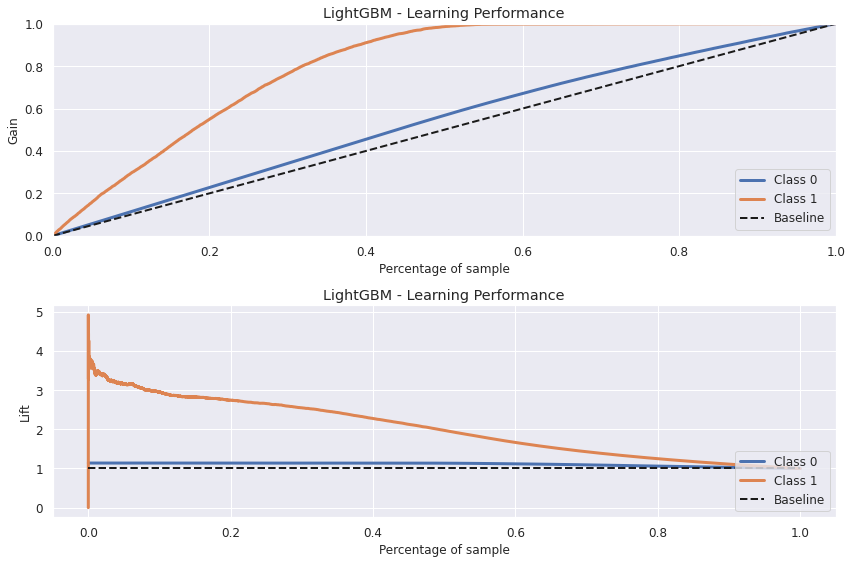

In [153]:
# order validation according to propensity score
df_propensity_ordered = propensity_score_ordering( X_validation, y_validation, yhat_lgbm_tuned)

# compute recall at k
recall_at_20000 = recall_at_k( df_propensity_ordered, k = 20000 )
print( f'Recall    at 20.000: {recall_at_20000}' )    
recall_at_40000 = recall_at_k( df_propensity_ordered, k = 40000 )
print( f'Recall    at 40.000: {recall_at_40000}' )    

# compute precision at k
precision_at_20000 = precision_at_k( df_propensity_ordered, k = 20000 )
print( f'Precision at 20.000: {precision_at_20000}' )
precision_at_40000 = precision_at_k( df_propensity_ordered, k = 40000 )
print( f'Precision at 40.000: {precision_at_40000}' )

# prepare figure
fig = plt.figure( figsize = (12,8), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 211 )
ax2 = fig.add_subplot( 212 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model, yhat_lgbm_tuned, 
                                    title = 'LightGBM - Learning Performance', ax = ax1 )

# plot lift curve
skplt.metrics.plot_lift_curve( y_validation_model, yhat_lgbm_tuned, 
                               title = 'LightGBM - Learning Performance', ax = ax2 );

In [154]:
print( "\
NOTE: \
\n \
\nk = 20.000 is based on the business problem, \
\nwhere the 'production' data will be about 127.000 customers. \
\n \
\nHowever, validation data is about 75.000 customers. \
\nTherefore, to use the same proportion in the above comparison as the production context, \
\nk needs to be about 12.000. \
\n \
\nEquivalent k calculation: \
\n\tequivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]")

NOTE: 
 
k = 20.000 is based on the business problem, 
where the 'production' data will be about 127.000 customers. 
 
However, validation data is about 75.000 customers. 
Therefore, to use the same proportion in the above comparison as the production context, 
k needs to be about 12.000. 
 
Equivalent k calculation: 
	equivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]


In [155]:
# concatenate X_train with X_validation to train final model
X_train_plus_val_model = np.concatenate( (X_train_model, X_validation_model), axis = 0)

# concatenate Y_train with Y_validation to train final model
y_train_plus_val_model = np.concatenate( (y_train_model, y_validation_model), axis = 0)

In [156]:
# train final model on train + validation data
lgbm_tuned.fit( X_train_plus_val_model, y_train_plus_val_model )

LGBMClassifier(n_estimators=30, num_leaves=10, random_state=10)

In [157]:
# # Save the lgbm trained model
# with open( '../src/models/model_health_insurance.pkl', 'wb' ) as file:
#     pickle.dump( lgbm_tuned, file )

In [158]:
# Load the Model back from file
with open( '../src/models/model_health_insurance.pkl', 'rb') as file:  
    model_health_insurance = pickle.load( file )

In [159]:
# model size
model_size_mb = round( os.path.getsize('../src/models/model_health_insurance.pkl') / (1024**2), 2)
model_size_mb

0.04

## Generalization Performance

In [160]:
# apply transformations (rescale and encoding) for X_test dataframe
X_test = rescale_and_encode( X_test )

# select features of X_test
X_test = X_test[ cols_selected ]

# prepare x_test for generalization performance measurement
X_test_model = X_test.fillna(0).values

# # prepare y_test for generalization performance measurement
y_test_model = y_test.fillna(0).values

In [161]:
# model prediction
yhat_model_health_insurance = model_health_insurance.predict_proba( X_test_model )

In [162]:
X_test.shape

(38111, 6)

In [163]:
print( "\
NOTE: \
\n \
\nBased on the business problem, k needs to be equal to 20.000, \
\nas the 'production' data will be about 127.000 customers. \
\n \
\nHowever, test data was about 38.000 customers. \
\nTherefore, to use the same proportion as the production context, \
\nk needs to be about 6.000. \
\n \
\nEquivalent k calculation: \
\n\tequivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]")

NOTE: 
 
Based on the business problem, k needs to be equal to 20.000, 
as the 'production' data will be about 127.000 customers. 
 
However, test data was about 38.000 customers. 
Therefore, to use the same proportion as the production context, 
k needs to be about 6.000. 
 
Equivalent k calculation: 
	equivalent_k = (20000 / df_production.shape[0]) * df_validation.shape[0]


In [164]:
# calculate equivalent k (as explained above)
equivalent_k = int( (20000 / df_production.shape[0]) * df_test.shape[0] )
equivalent_k

5999

Recall    at 6.000: 0.44747583243823846
Recall    at 12.000: 0.7995703544575725
Precision at 6.000: 0.3471088151974671
Precision at 12.000: 0.31014082159820017


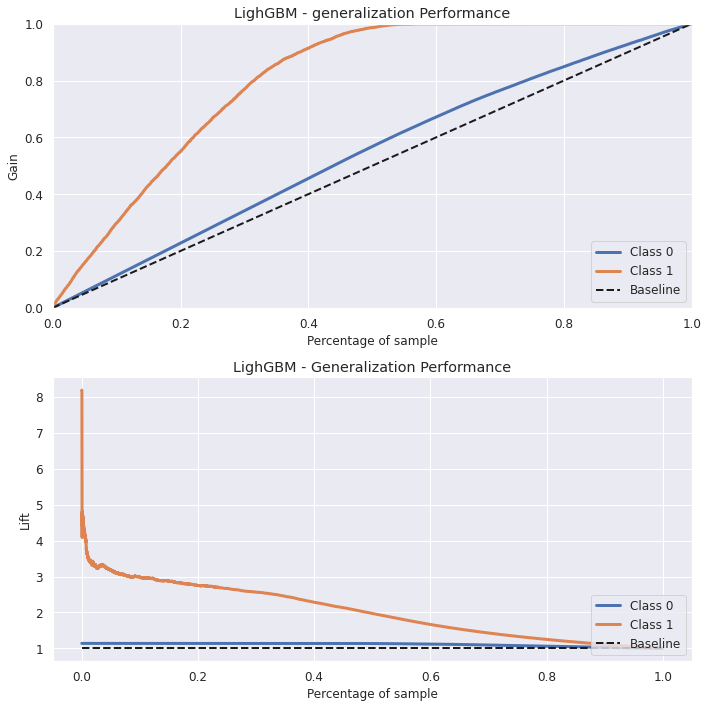

In [165]:
# order validation according to propensity score
df_propensity_ordered = propensity_score_ordering( X_test, y_test, yhat_model_health_insurance)

# compute recall at k
recall_at_6000 = recall_at_k( df_propensity_ordered, k = 6000 )
print( f'Recall    at 6.000: {recall_at_6000}' )    
recall_at_12000 = recall_at_k( df_propensity_ordered, k = 12000 )
print( f'Recall    at 12.000: {recall_at_12000}' )    

# compute precision at k
precision_at_6000 = precision_at_k( df_propensity_ordered, k = 6000 )
print( f'Precision at 6.000: {precision_at_6000}' )
precision_at_12000 = precision_at_k( df_propensity_ordered, k = 12000 )
print( f'Precision at 12.000: {precision_at_12000}' )

# prepare figure
fig = plt.figure( figsize = (10,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 211 )
ax2 = fig.add_subplot( 212 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health_insurance, 
                                    title = 'LighGBM - generalization Performance', ax = ax1 );

# plot lift curve
skplt.metrics.plot_lift_curve( y_test_model, yhat_model_health_insurance, 
                               title = 'LighGBM - Generalization Performance', ax = ax2 );

## Business Performance

In [166]:
# NOTE
print( '\
NOTE: \
\n \
\nBasic assumption to make predictions: \
\n\tthe production data will have the same interested customers proportion\
\n\tas in the test dataset.' )

NOTE: 
 
Basic assumption to make predictions: 
	the production data will have the same interested customers proportion
	as in the test dataset.


In [167]:
# calculate proportion of interested in test data
interested_percentage = y_test.sum() / y_test.shape[0]

### Making 20.000 phone calls, what percentage of interested clients the sales team will get in contact with?

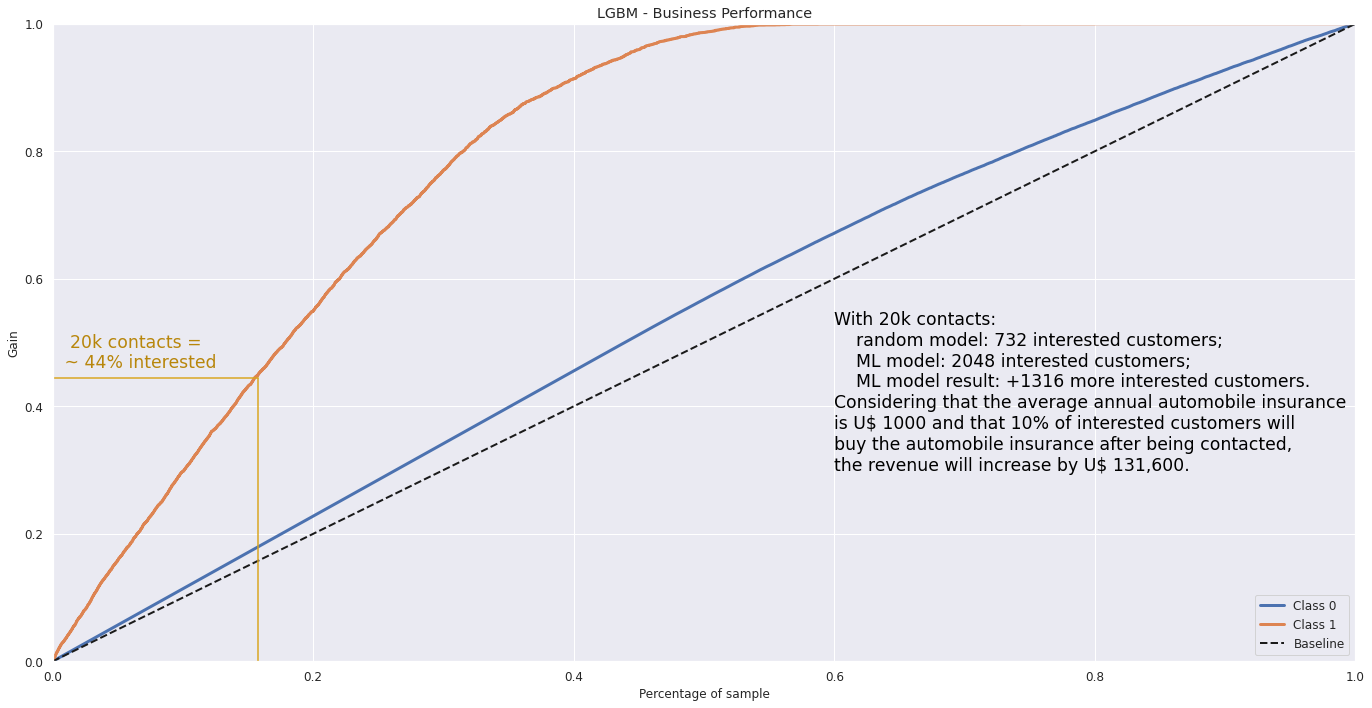

In [168]:
# calculate how much 20k represents to total sample of production data
twenty_k_percentage = ( 20000 / df_production.shape[0] ) 

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health_insurance, 
                                    title = 'LGBM - Business Performance', ax = ax1 );

# add 20000 customers contacted line
ax1.axvline( twenty_k_percentage, ymax = 0.445, color = 'goldenrod', label = '20k' )
ax1.axhline( 0.445 , xmax = twenty_k_percentage, color = 'goldenrod' )
plt.text( 0.005 , 0.45 + 0.01, '  20k contacts =\n ~ 44% interested' , 
          color = 'darkgoldenrod', fontsize = 'x-large' );

# calculate number of interested customers with ML model
ml_customers_twenty = int( y_test.shape[0] * interested_percentage * 0.44 )
# calculate number of interested customers with random model
random_customers_twenty = int( y_test.shape[0] * interested_percentage * twenty_k_percentage )
# calculate how many customers ML will increase
ml_customers_increase = int( ml_customers_twenty - random_customers_twenty )

# display business message
message = f'\
With 20k contacts: \
\n    random model: {random_customers_twenty} interested customers;\
\n    ML model: {ml_customers_twenty} interested customers;\
\n    ML model result: +{ml_customers_twenty - random_customers_twenty} more interested customers.\
\nConsidering that the average annual automobile insurance\n\
is U\$ 1000 and that 10% of interested customers will\n\
buy the automobile insurance after being contacted,\n\
the revenue will increase by U$ {int( 0.1 * ( (ml_customers_increase * 1000) ) ):,}.'
plt.text( 0.6 , 0.3, message, color = 'black', fontsize = 'x-large' );

# save image
# with open( '../images/second_business_question.png', 'wb' ) as img:
#     plt.savefig( img )

### If the sales team expand its capacity to make 40.000 phone calls, what is the percentage of interested clients the sales team will get in contact with?

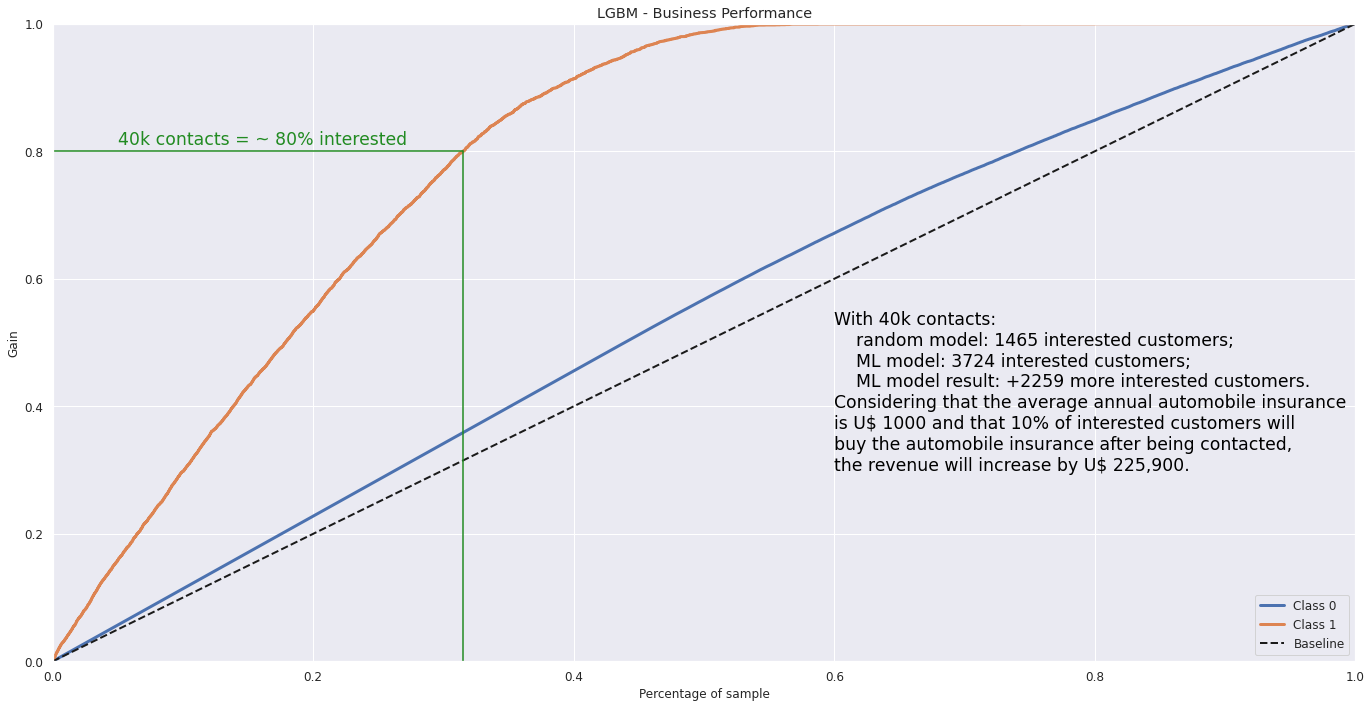

In [169]:
# calculate how much 40k represents to total sample
fourty_k_percentage = ( 40000 / df_production.shape[0] ) 

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health_insurance, 
                                    title = 'LGBM - Business Performance', ax = ax1 );

# add 40000 customers contacted line
ax1.axvline( fourty_k_percentage, ymax = 0.8, color = 'forestgreen', label = '40k' )
ax1.axhline( 0.8, xmax = fourty_k_percentage, color = 'forestgreen' )
plt.text( 0.05 , 0.8 + 0.01 , '40k contacts = ~ 80% interested' , 
          color = 'forestgreen', fontsize = 'x-large' );

# calculate number of interested customers with ML model
ml_customers_fourty = int( y_test.shape[0] * interested_percentage * 0.8 )
# calculate number of interested customers with random model
random_customers_fourty = int( y_test.shape[0] * interested_percentage * fourty_k_percentage )
# calculate how many customers ML will increase
ml_customers_increase = int( ml_customers_fourty - random_customers_fourty )

# display business message
message = f'\
With 40k contacts: \
\n    random model: {random_customers_fourty} interested customers;\
\n    ML model: {ml_customers_fourty} interested customers;\
\n    ML model result: +{ml_customers_fourty - random_customers_fourty} more interested customers.\
\nConsidering that the average annual automobile insurance\n\
is U\$ 1000 and that 10% of interested customers will\n\
buy the automobile insurance after being contacted,\n\
the revenue will increase by U$ {int( 0.1 * ( (ml_customers_increase * 1000) ) ):,}.'
plt.text( 0.6 , 0.3, message, color = 'black', fontsize = 'x-large' );


# save image
# with open( '../images/third_business_question.png', 'wb' ) as img:
#     plt.savefig( img )

### How many phone calls do the sales team has to make in order to contact 80% of automobile insurance interested clients?

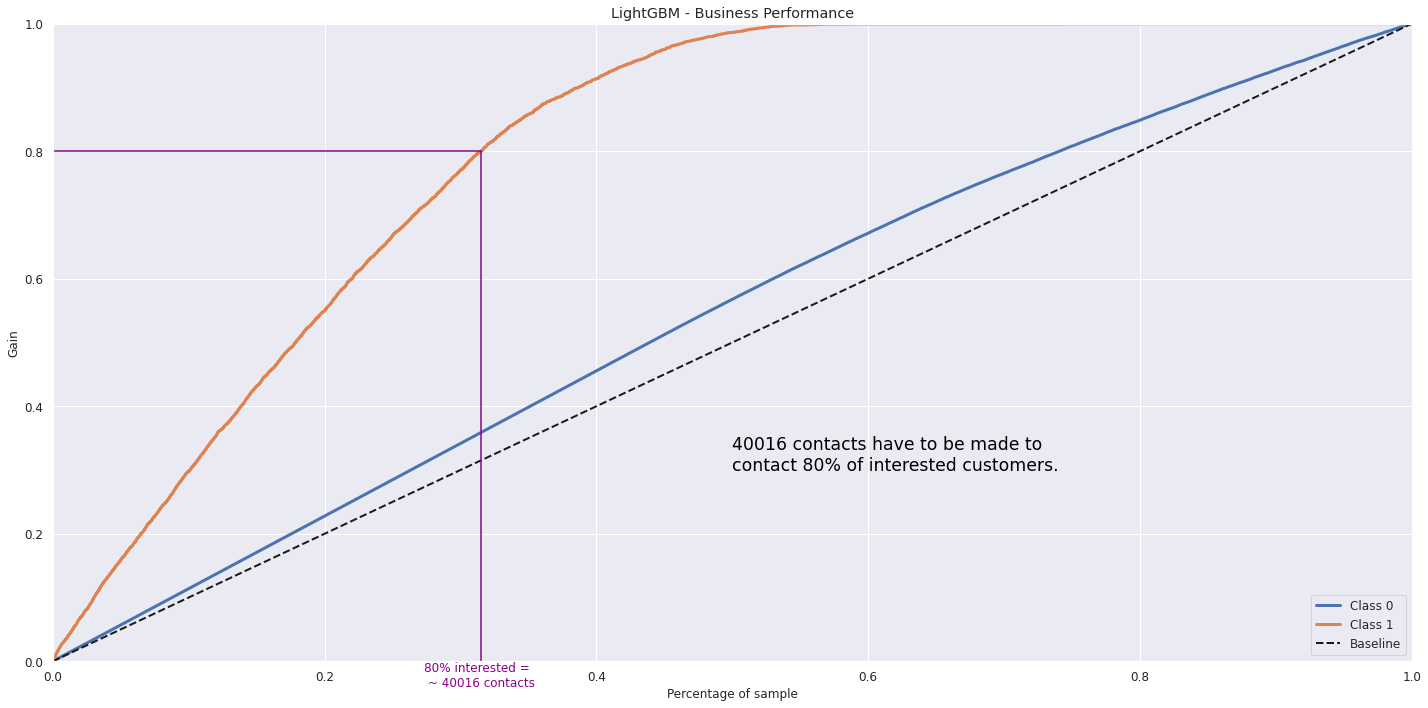

In [170]:
# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health_insurance, 
                                    title = 'LightGBM - Business Performance', ax = ax1 );

# add 80% interested customers contacted line
ax1.axhline( 0.8 , xmax = 0.315, color = 'darkmagenta' )
ax1.axvline( 0.315 , ymax = 0.8, color = 'darkmagenta' )
plt.text( 0.323 -0.05, -0.04, f'80% interested = \n ~ {int( 0.315*df_production.shape[0])} contacts',  
          color = 'darkmagenta');

# display business message
message = f'{int( 0.315*df_production.shape[0])} contacts have to be made to\
\ncontact 80% of interested customers.'
plt.text( 0.5 , 0.3, message, color = 'black', fontsize = 'x-large' );

# # save image
# with open( '../images/fourth_business_question.png', 'wb' ) as img:
#     plt.savefig( img )

### Gain Curve

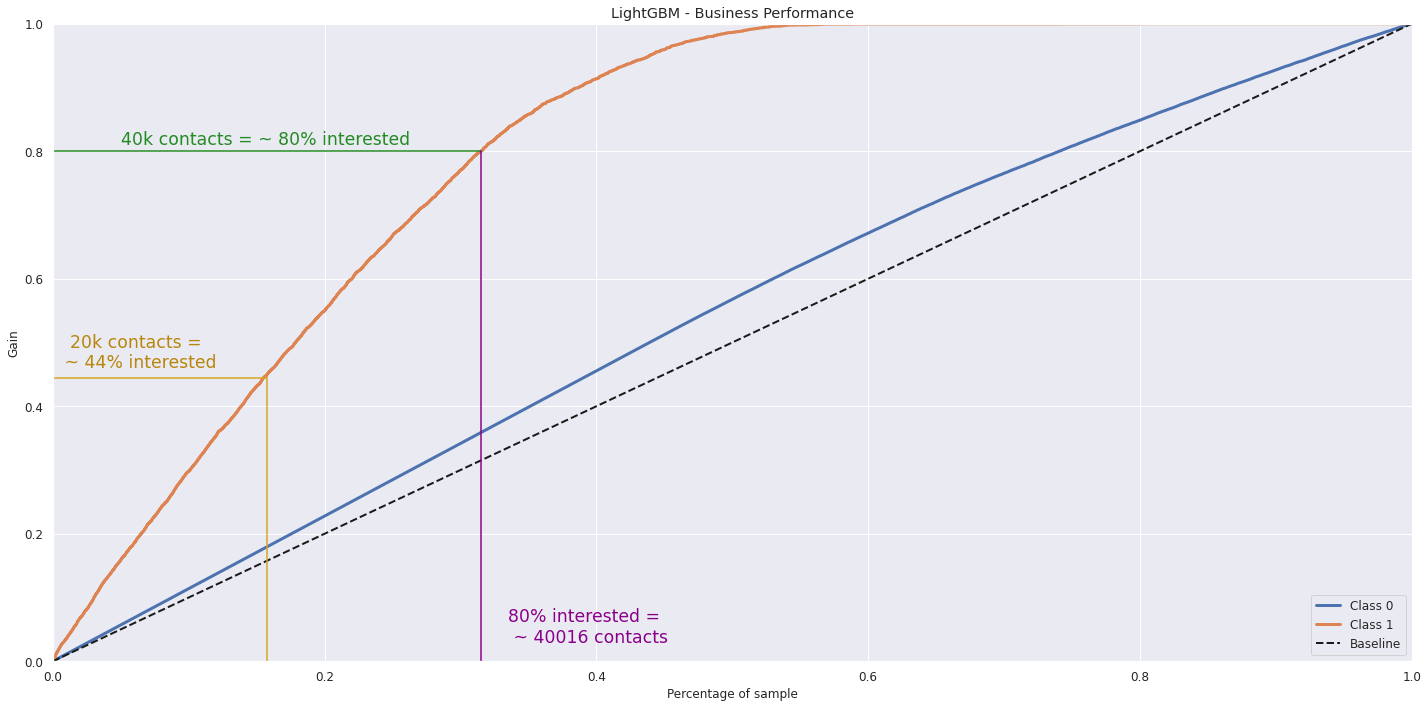

In [171]:
# calculate how much 20k represents to total sample
twenty_k_percentage = ( 20000 / df_production.shape[0] ) 

# calculate how much 40k represents to total sample
fourty_k_percentage = ( 40000 / df_production.shape[0] ) 

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health_insurance, 
                                    title = 'LightGBM - Business Performance', ax = ax1 );

# add 20000 customers contacted line
ax1.axvline( twenty_k_percentage, ymax = 0.445, color = 'goldenrod', label = '20k' )
ax1.axhline( 0.445 , xmax = twenty_k_percentage, color = 'goldenrod' )
plt.text( 0.005 , 0.45 + 0.01, '  20k contacts =\n ~ 44% interested' , 
          color = 'darkgoldenrod', fontsize = 'x-large' );

# add 40000 customers contacted line
ax1.axhline( 0.8, xmax = fourty_k_percentage, color = 'forestgreen' )
plt.text( 0.05 , 0.8 + 0.01 , '40k contacts = ~ 80% interested' , 
          color = 'forestgreen', fontsize = 'x-large' );

# add 80% interested customers contacted line
ax1.axvline( 0.315 , ymax = 0.8, color = 'darkmagenta' )
plt.text( 0.315 + 0.02, 0.03, f'80% interested = \n ~ {int( 0.315*df_production.shape[0])} contacts',  
          color = 'darkmagenta', fontsize = 'x-large');

# # save image
# with open( '../images/compiled_business_question.png', 'wb' ) as img:
#     plt.savefig( img )

### Lift Curve

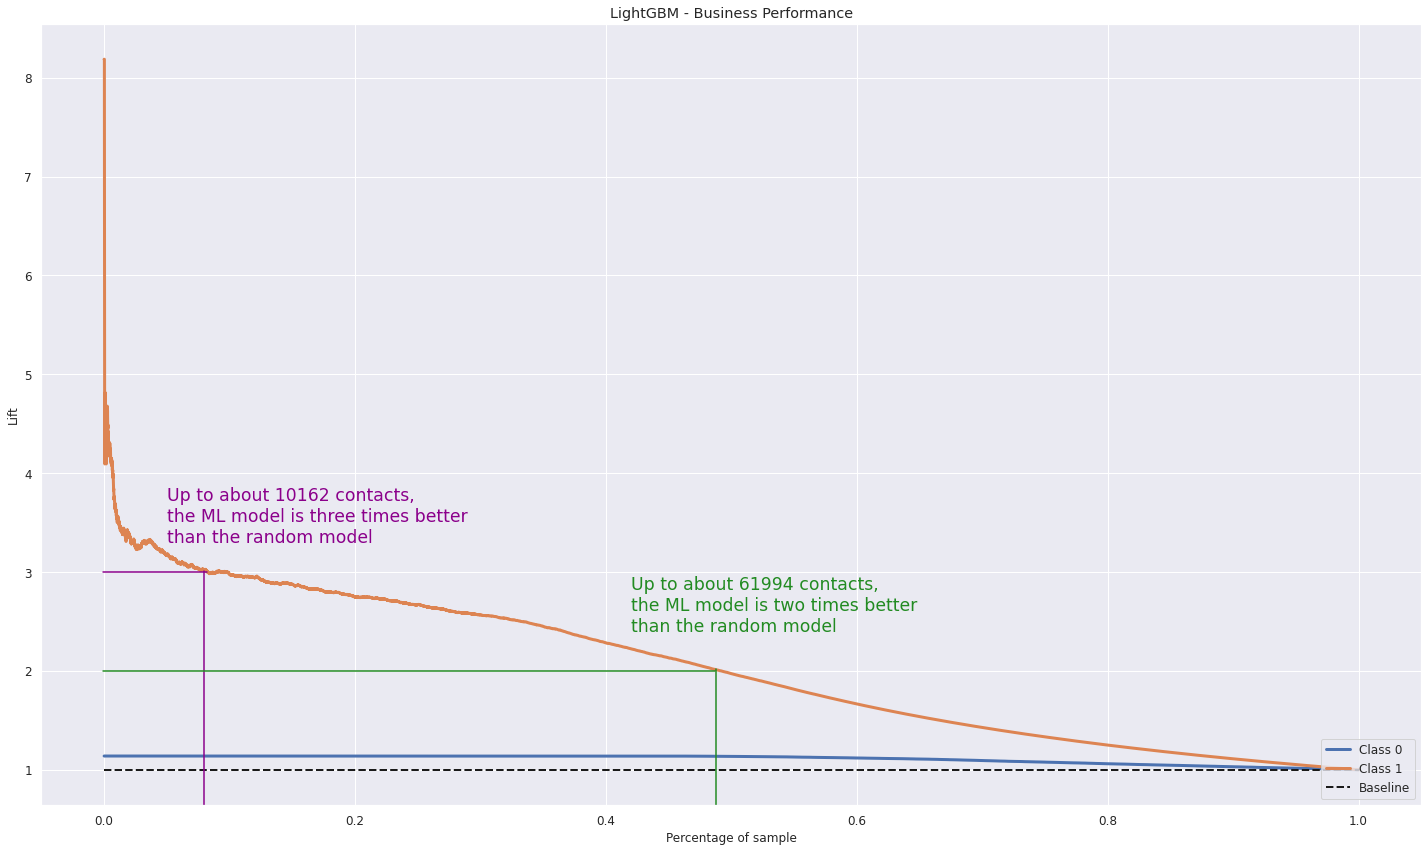

In [172]:
# prepare figure
fig = plt.figure( figsize = (20,12), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_lift_curve( y_test_model, yhat_model_health_insurance, 
                               title = 'LightGBM - Business Performance', ax = ax1 );

# draw lift equals to three
ax1.axvline( 0.08, ymax = 0.3, color = 'darkmagenta', label = '20k' )
ax1.axhline( 3 , xmin = 0.045, xmax = 0.12, color = 'darkmagenta' )
plt.text( 0.05 , 3.3, f'Up to about {int( 0.08*df_production.shape[0])} contacts,\nthe ML model is three times better\nthan the random model',
         color = 'darkmagenta', fontsize = 'x-large' )

# draw lift equals to two
ax1.axvline( 0.488, ymax = 0.175, color = 'forestgreen', label = '40k' )
ax1.axhline( 2, xmin = 0.045, xmax = 0.488, color = 'forestgreen' )
plt.text( 0.42 , 2.4, f'Up to about {int( 0.488*df_production.shape[0])} contacts,\nthe ML model is two times better\nthan the random model',
          color = 'forestgreen', fontsize = 'x-large' );

# # save image
# with open( '../reports/figures/lift_business_question.png', 'wb' ) as img:
#     plt.savefig( img )

# DEPLOYMENT

## Health Insurance Class

In [173]:
# import pickle
# import numpy  as np
# import pandas as pd

# class HealthInsurance:
#     def __init__( self ): # class constructor
#         # set home path
#         self.home_path = '/home/gustavo/projects/pa004_health_insurance_cross_sell/pa004_gustavo_cunha/'

#         # load scalers
#         with open( self.home_path + 'src/features/annual_premium_rs.pkl', 'rb' ) as premium_scaler:
#             self.annual_premium_scaler = pickle.load( premium_scaler )
#         with open( self.home_path + 'src/features/age_mms.pkl', 'rb' ) as age_scaler:
#             self.age_scaler = pickle.load( age_scaler )
#         with open( self.home_path + 'src/features/vintage_mms.pkl', 'rb' ) as vintage_scaler:
#             self.vintage_scaler = pickle.load( vintage_scaler )


#     def data_cleaning( self, df_to_clean ):
#         """df_to_clean is the data(frame) to be cleaned"""

#         # lower case column names to avoid errors
#         df_to_clean.columns = df_to_clean.columns.str.lower()

#         # Data Cleaning is done -> df_dc_done
#         df_dc_done = df_to_clean


#         return df_dc_done


#     def feature_engineering( self, df_to_fe ):
#         """df_to_fe is the data(frame) to be engineered"""

#         # convert region_code column to integer
#         df_to_fe[ 'region_code' ] = df_to_fe[ 'region_code' ].astype( int );

#         # convert region_code column to integer
#         df_to_fe[ 'policy_sales_channel' ] = df_to_fe[ 'policy_sales_channel' ].astype( int );

#         # convert region_code column to integer
#         df_to_fe[ 'annual_premium' ] = df_to_fe[ 'annual_premium' ].astype( int );

#         # convert damage column from Yes-No to True-False format
#         df_to_fe['vehicle_damage'] = df_to_fe[ 'vehicle_damage' ].apply(
#                                                                     lambda x: True if x == 'Yes'else False )

#         # Feature Engineering is done -> df_fe_done
#         df_fe_done = df_to_fe


#         return df_fe_done


#     def data_preparation( self, df_to_dp ):
#         """df_to_dp is the data(frame) be (data) prepared"""

#         # apply min-max scaler on age column of training dataset
#         df_to_dp['age'] = self.age_scaler.transform( df_to_dp['age'].values.reshape(-1,1) )

#         # apply min-max scaler on vintage column of training dataset
#         df_to_dp['vintage'] = self.vintage_scaler.transform( df_to_dp['vintage'].values.reshape(-1,1) )

#         # apply robust scaler on annual_premium column of training dataset
#         df_to_dp['annual_premium'] = self.annual_premium_scaler.transform( df_to_dp['annual_premium'].values.reshape(-1,1) )

#         # encode gender column -> convert to number
#         df_to_dp[ 'gender' ] = df_to_dp[ 'gender' ].map( { 'Male': 1,
#                                                            'Female': 0 } )

#         # encode vehicle_damage column -> convert boolean to integers
#         df_to_dp[ 'vehicle_damage'] = df_to_dp[ 'vehicle_damage'].astype( int )

#         # encode vehicle_age column -> ordinal encoding
#         df_to_dp[ 'vehicle_age' ] = df_to_dp[ 'vehicle_age' ].map( {'< 1 Year': 0  ,
#                                                                     '1-2 Year': 1  ,
#                                                                     '> 2 Years': 2   } )

#         # encode policy_sales_channel -> frequency encoding
#         df_to_dp['policy_sales_channel'] = df_to_dp.groupby( 'policy_sales_channel' ).size() / len( df_to_dp )
#         df_to_dp['policy_sales_channel'] = df_to_dp['policy_sales_channel'].fillna( 0 )

#         # encode region_code -> frequency encoding
#         df_to_dp['region_code'] = df_to_dp.groupby( 'region_code' ).size() / len( df_to_dp )
#         df_to_dp['region_code'] = df_to_dp['region_code'].fillna( 0 )

#         # cols selection on feature selection
#         cols_selected = [ 'vintage',
#                           'annual_premium',
#                           'age',
#                           'vehicle_damage',
#                           'previously_insured',
#                           'vehicle_age']

#         # Data Preparation (and feature selection) is is done -> df_dp_done
#         df_dp_done = df_to_dp[ cols_selected ]


#         return df_dp_done


#     def get_prediction( self, model, original_data, test_data ):
#         """
#         Args:
#             model: model trained
#             original_data: original data sent on request
#             test_data: transformed data, ready for prediction
#         """

#         # model prediction
#         pred = model.predict_proba( test_data )

#         # join prediction into original data
#         original_data['score'] = pred[:, 1].tolist()

#         # convert the result to json (API transferring format)
#         df_prediction = original_data.to_json( orient = 'records', date_format = 'iso' )


#         return df_prediction

## API Handler

In [174]:
# import pickle
# import os
# import pandas        as     pd
# from flask           import Flask, request, Response

# # healthinsurance is the directory, on the same tree directory level as handler.py
# # HealthInsurance is the file (HealthInsurance.py) inside the directory
# # -> healthinsurance.HealthInsurance
# # HealthInsurance is the class inside HealthInsurance.py
# # from: directory. import: class.
# from healthinsurance.HealthInsurance import HealthInsurance

# # set home path
# path = '/home/gustavo/projects/pa004_health_insurance_cross_sell/pa004_gustavo_cunha/'

# # load final model to API memory
# with open( path + 'src/models/model_health_insurance.pkl', 'rb' ) as production_model:
#     model = pickle.load( production_model )

# # initialize API
# app = Flask( __name__ )

# # create url for request
# # GET: ask for data
# # POST: send data to receive data
# @app.route( '/heathinsurance/predict', methods=['POST'] )
# def health_insurance_predict(): # first function to run when receive a request
#     # get json data on request
#     test_json = request.get_json()

#     # check if data was sent on request
#     if test_json:
#     # unique row given on the request made: json = dictionary
#         if isinstance( test_json, dict ): 
#             test_raw = pd.DataFrame( test_json, index=[0] )

#         # multiple rows given on the request made
#         else:
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

#         # create a copy of original data
#         original_data = test_raw.copy()

#         # Instantiate HealthInsurance class
#         pipeline = HealthInsurance()

#         # clean data
#         df_dc_done = pipeline.data_cleaning( test_raw )

#         # engineer data
#         df_fe_done = pipeline.feature_engineering( df_dc_done )

#         # prepare data
#         df_dp_done = pipeline.data_preparation( df_fe_done )

#         # predict
#         df_response = pipeline.get_prediction( model, original_data, df_dp_done )

#         # return data to API request
#         return df_response

#     # data was not sent on request
#     else:
#         # mimetype -> from a json application
#         return Response( '{}', status = 200, mimetype = 'application/json' )

# # when handler.py script is run, run flask
# if __name__ == '__main__':
#     port = os.environ.get('PORT', 5000)
#     # '0.0.0.0' is the local host
#     app.run( '0.0.0.0', debug = True )

## API Tester

In [175]:
# import requests

# loading api test dataset - e.g. production data
# df_api_test = df_production.copy()

# select a random sample to check api
# df_api_test_random_sample = df_api_test.sample(10)
# df_api_test_random_sample.dtypes

In [176]:
# convert dataframe to json (data transferring format among APIs)
# data = json.dumps( df_api_test_random_sample.to_dict( orient = 'records' ) )

In [177]:
# API Call

# local endpoint. 5000: flask port
# url = 'http://0.0.0.0:5000/heathinsurance/predict'
# heroku endpoint - https://health-insurance-cross-sell.herokuapp.com/ 
# url = 'https://health-insurance-cross-sell.herokuapp.com/heathinsurance/predict'

# indicate to API what type of data is being sent
# header = {'Content-type': 'application/json' }

In [178]:
# make request sending data (post)
# r = requests.post( url, data = data, headers = header )
# print( f'Status Code {r.status_code}' )

In [179]:
# create a dataframe from request output
# d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )
# d1

In [180]:
# show response ordered by score
# d1.sort_values( 'score', ascending = False )